### Modeling

In [48]:
import pandas as pd
import numpy as np
import seaborn as plt
import matplotlib.pyplot as plt


import pickle
import re

from nltk.corpus import brown
import nltk
from nltk.corpus import stopwords

from gensim.models import Phrases
from gensim.models.phrases import Phraser


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from corextopic import corextopic, vis_topic




In [3]:
review_data = pd.read_pickle('updated_lem_review1.pickle')
review_data.shape

(100317, 6)

In [4]:
corpus = review_data['reviewText'] 
corpus.head()

0    texture concealer pallet fantastic coverage wi...
1    small expect okay lasted long think coverage p...
2    please do not rachett palette size picture col...
3    chalky pigment wear easily coastal scent dupe ...
4    nothing sting put whole tube nothing lighten b...
Name: reviewText, dtype: object

### Functions 

In [5]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

### LSA using CountVectorizer

In [7]:
cv = CountVectorizer(stop_words='english',max_df= 0.80, min_df=0.1, ngram_range=(1,2) )
doc_word= cv.fit_transform(corpus)

n = 5
lsa = TruncatedSVD(n)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_
dtm = pd.DataFrame(doc_word.toarray(),index= corpus, columns=cv.get_feature_names())


display_topics(lsa, cv.get_feature_names(), 10)


Topic  0
love, feel, make, smell, dry, face, leave, nice, long, look

Topic  1
love, price, look, long, try, smell, nice, leave, dry, face

Topic  2
smell, nice, leave, price, long, try, dry, look, feel, love

Topic  3
make, smell, long, price, nice, look, try, love, leave, dry

Topic  4
dry, long, look, try, leave, price, nice, love, make, smell


In [8]:
doc_topic.shape

(100317, 5)

In [9]:
Vt = pd.DataFrame(doc_topic.round(5),
                 index = corpus,
                 columns = ['comp_1','comp_2',
                            'comp_3','comp_4','comp_5'])

Vt.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
reviewText,,,,,
texture concealer pallet fantastic coverage wide variety use guess mean professional makeup artist colour least two regular basis two occasionally reason give star feel range color kind waste wonderful cakey give natural conceal imperfection therefore highly,0.40335,-0.36092,-0.11664,-0.41151,-0.36805
small expect okay lasted long think coverage price pay heavy wear within kinda dry people look cheap coverage beginner learn conceal,0.69466,-0.25504,-0.12115,-0.08483,1.16241
please do not rachett palette size picture color go sheer slide face wax expect makeup stay put spend money stuff thumb,0.24521,-0.24474,-0.20889,-0.35480,-0.25657
chalky pigment wear easily coastal scent dupe many highlighter color show dark skinned woman coastal scent currently sale worth extra buck,-0.00000,-0.00000,-0.00000,-0.00000,0.00000
nothing sting put whole tube nothing lighten brighten nothing tend dry make face feel weird next stuck hoping lighten,1.31584,-1.07406,-0.71720,-0.17376,0.13427


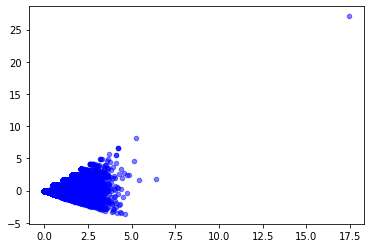

In [10]:
display_cluster(doc_topic)

### Vizualization using WordCloud

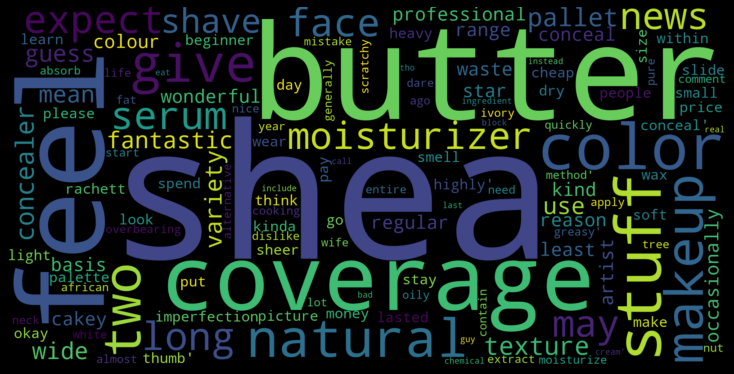

In [11]:
from wordcloud import WordCloud, STOPWORDS


# all documents and see what words seems to show up more in our documents

text = review_data["reviewText"].values
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 6),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Tokenization Unigram, Bi_gramm

In [12]:
corpora = review_data["reviewText"].values
tokenized = [corpus.split(" ") for corpus in corpora]

print(tokenized[0:5])

[['texture', 'concealer', 'pallet', 'fantastic', 'coverage', 'wide', 'variety', 'use', 'guess', 'mean', 'professional', 'makeup', 'artist', 'colour', 'least', 'two', 'regular', 'basis', 'two', 'occasionally', 'reason', 'give', 'star', 'feel', 'range', 'color', 'kind', 'waste', 'wonderful', 'cakey', 'give', 'natural', 'conceal', 'imperfection', 'therefore', 'highly'], ['small', 'expect', 'okay', 'lasted', 'long', 'think', 'coverage', 'price', 'pay', 'heavy', 'wear', 'within', 'kinda', 'dry', 'people', 'look', 'cheap', 'coverage', 'beginner', 'learn', 'conceal'], ['please', 'do', 'not', 'rachett', 'palette', 'size', 'picture', 'color', 'go', 'sheer', 'slide', 'face', 'wax', 'expect', 'makeup', 'stay', 'put', 'spend', 'money', 'stuff', 'thumb'], ['chalky', 'pigment', 'wear', 'easily', 'coastal', 'scent', 'dupe', 'many', 'highlighter', 'color', 'show', 'dark', 'skinned', 'woman', 'coastal', 'scent', 'currently', 'sale', 'worth', 'extra', 'buck'], ['nothing', 'sting', 'put', 'whole', 'tube'

In [13]:
tokenized_1 = [list(filter(lambda x: len(x) > 1, document)) \
             for document in tokenized]

In [14]:
uni_gram_tokens = set([token for text in tokenized_1 for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:50])

['habia', 'palatte', 'pudesse', 'result', 'lash', 'starsgrease', 'soften', 'ither', 'sweettexture', 'borrowing', 'exfoilation', 'thum', 'squeezable', 'unkind', 'matrixyl', 'ib', 'crew', 'enamour', 'instinctual', 'nonirritate', 'silicome', 'belly', 'cable', 'cinco', 'teethe', 'homestuckit', 'believ', 'oj', 'ingredientsi', 'wella', 'multipleye', 'pose', 'slowed', 'evn', 'nooks', 'triangular', 'suoppose', 'tallow', 'suchwouldn', 'vein', 'poppingly', 'standing', 'glycerin', 'invoice', 'referene', 'lashline', 'itchyness', 'rocky', 'rosie', 'kinking']


In [15]:
bi_gram = Phrases(tokenized, min_count=300, threshold=50)
bigram_min = bi_gram.min_count

bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set([token.decode("utf-8") \
                      for token in bi_gram_tokens])

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only)[:50])

['nice_smell', 'smell_strong', '-PRON-_be', 'makeup_remover', 'feel_dry', 'year_ago', 'dark_spot', 'feel_well', 'natural_look', 'blow_dry', 'non_greasy', 'two_coat', 'soft_shiny', 'u', 'leave_face', 'make_difference', 'light_weight', 'around_eye', 'nail_polish', 'love_love', 'dark_brown', 'see_result', 'make_easy', 'deep_conditioner', 'love_scent', 'stay_long', 'leave_residue', 'stretch_mark', 'shea_butter', 'nail_art', 'make_eye', 'soft_smooth', 'make_sure', 'make_soft', 'face_neck', 'look_nice', 'highly_recommend', 'smell_wonderful', 'long_thick', 'right_amount', 'go_wrong', 'easy_clean', 'body_lotion', 'go_long', 'eye_area', 'try_many', 'long_last', 'look_natural', 'decide_give', 'love_make']


In [16]:
# creating list


bi_grams = []
for i in bi_grams_only:
    bi_grams.append(i)
    

In [17]:
bi_grams[0:2]

['nice_smell', 'smell_strong']

In [18]:
# Topic moding using bi_gram

cv = CountVectorizer()
doc_word3= cv.fit_transform(bi_grams)

n = 5
lsa = TruncatedSVD(n)
doc_topic3 = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_
dtm = pd.DataFrame(doc_word3.toarray(),index= bi_grams, columns=cv.get_feature_names())


display_topics(lsa, cv.get_feature_names(), 5)


Topic  0
anti_age, absolutely_love, anything_else, bar_soap, _be

Topic  1
anti_age, around_eye, african_american, acne_prone, base_coat

Topic  2
bar_soap, argan_oil, absorb_quickly, around_eye, acne_prone

Topic  3
anything_else, bar_soap, acne_prone, around_eye, argan_oil

Topic  4
_be, acne_prone, african_american, base_coat, absorb_quickly


### LSA with Tf-idf

In [19]:
# tf-idf Vectorizer 

dt = TfidfVectorizer(stop_words='english',max_df= 0.50, min_df=0.1,
                      strip_accents = 'ascii', analyzer = 'word',
                     token_pattern='(?u)\\b\\w\\w+\\b' )
doc_word1= dt.fit_transform(corpus)
n = 5
lsa = TruncatedSVD(n)
doc_topic1 = lsa.fit_transform(doc_word1)
lsa.explained_variance_ratio_
dtm = pd.DataFrame(doc_word1.toarray(),index= corpus, 
                       columns=dt.get_feature_names())


display_topics(lsa, dt.get_feature_names(), 10)



Topic  0
love, make, feel, smell, dry, long, look, face, nice, leave

Topic  1
love, price, look, try, long, leave, nice, smell, face, dry

Topic  2
make, love, look, price, try, long, face, nice, leave, feel

Topic  3
smell, make, nice, price, love, leave, try, long, face, feel

Topic  4
long, look, price, nice, try, smell, make, leave, love, dry


In [20]:
Vt = pd.DataFrame(doc_topic1.round(5),
                 index = corpus,
                 columns = ['comp_1','comp_2',
                            'comp_3','comp_4','comp_5'])

Vt.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
reviewText,,,,,
texture concealer pallet fantastic coverage wide variety use guess mean professional makeup artist colour least two regular basis two occasionally reason give star feel range color kind waste wonderful cakey give natural conceal imperfection therefore highly,0.31243,-0.23996,-0.23766,-0.25122,-0.42842
small expect okay lasted long think coverage price pay heavy wear within kinda dry people look cheap coverage beginner learn conceal,0.40080,-0.17475,-0.21146,-0.38884,0.67734
please do not rachett palette size picture color go sheer slide face wax expect makeup stay put spend money stuff thumb,0.18040,-0.12601,-0.09941,-0.24449,-0.22754
chalky pigment wear easily coastal scent dupe many highlighter color show dark skinned woman coastal scent currently sale worth extra buck,-0.00000,-0.00000,-0.00000,-0.00000,0.00000
nothing sting put whole tube nothing lighten brighten nothing tend dry make face feel weird next stuck hoping lighten,0.57133,-0.49058,0.01657,-0.36055,-0.41614


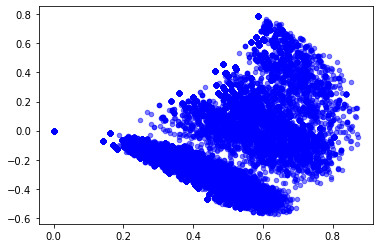

In [21]:
display_cluster(doc_topic1)

### Non - Negative Matrix Factorization (NMF)

In [22]:
corpus 

ex_label = [e[:30]+'...' for e in corpus]

In [23]:
corpus

0         texture concealer pallet fantastic coverage wi...
1         small expect okay lasted long think coverage p...
2         please do not rachett palette size picture col...
3         chalky pigment wear easily coastal scent dupe ...
4         nothing sting put whole tube nothing lighten b...
                                ...                        
100312    serum time far twice like far light silky feel...
100313    happy extremely sensitive cautious try new go ...
100314    serum day make feel soft serum smell light ove...
100315    shea butter white ivory color fat extract nut ...
100316    pure shea butter mistake shea butter may conta...
Name: reviewText, Length: 100317, dtype: object

In [24]:
vectorizer_nmf = CountVectorizer (stop_words ='english', max_df= 0.60, min_df=0.1,
                     strip_accents = 'ascii', analyzer ='word',
                     token_pattern='(?u)\\b\\w\\w+\\b')
doc_word_nmf = vectorizer_nmf.fit_transform(corpus)
nmf_model = NMF(5)
doc_topic_nmf = nmf_model.fit_transform(doc_word)


display_topics(nmf_model, vectorizer_nmf.get_feature_names(), 10)


Topic  0
feel, face, leave, nice, look, try, price, long, smell, make

Topic  1
love, look, price, long, try, leave, nice, smell, make, feel

Topic  2
smell, nice, leave, price, long, try, feel, make, love, look

Topic  3
make, long, look, nice, try, price, smell, love, leave, feel

Topic  4
dry, long, leave, look, try, nice, price, smell, make, love


In [25]:

H = pd.DataFrame(doc_topic_nmf.round(5),
             index = ex_label,
             columns = ['comp_1','comp_2',
                        'comp_3','comp_4','comp_5' ])
H

,comp_1,comp_2,comp_3,comp_4,comp_5
texture concealer pallet fanta...,0.04811,0.00000,0.00000,0.00000,0.00000
small expect okay lasted long ...,0.00127,0.01178,0.00349,0.01726,0.10808
please do not rachett palette ...,0.03210,0.00000,0.00000,0.00000,0.00000
chalky pigment wear easily coa...,0.00000,0.00000,0.00000,0.00000,0.00000
nothing sting put whole tube n...,0.07675,0.00000,0.00000,0.07523,0.07167
...,...,...,...,...,...
serum time far twice like far ...,0.11174,0.00638,0.00131,0.01430,0.02084
happy extremely sensitive caut...,0.05404,0.00627,0.00000,0.01139,0.01493
serum day make feel soft serum...,0.07707,0.00000,0.07081,0.07680,0.00000
shea butter white ivory color ...,0.10124,0.00000,0.00784,0.00289,0.00000


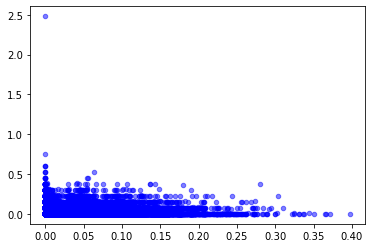

In [26]:
display_cluster(doc_topic_nmf)

### LDA 

In [27]:
#genism

from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim

#logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)



In [28]:
reviews = review_data['reviewText'].values.tolist()

In [29]:
texts = [(line.strip()).split() for line in reviews]

In [30]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [31]:
dictionary = corpora.Dictionary(texts)

2020-09-16 15:36:30,021 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-09-16 15:36:30,406 : INFO : adding document #10000 to Dictionary(10048 unique tokens: ['artist', 'basis', 'cakey', 'color', 'colour']...)
2020-09-16 15:36:30,776 : INFO : adding document #20000 to Dictionary(12868 unique tokens: ['artist', 'basis', 'cakey', 'color', 'colour']...)
2020-09-16 15:36:31,093 : INFO : adding document #30000 to Dictionary(14529 unique tokens: ['artist', 'basis', 'cakey', 'color', 'colour']...)
2020-09-16 15:36:31,418 : INFO : adding document #40000 to Dictionary(15734 unique tokens: ['artist', 'basis', 'cakey', 'color', 'colour']...)
2020-09-16 15:36:31,732 : INFO : adding document #50000 to Dictionary(16629 unique tokens: ['artist', 'basis', 'cakey', 'color', 'colour']...)
2020-09-16 15:36:32,046 : INFO : adding document #60000 to Dictionary(17261 unique tokens: ['artist', 'basis', 'cakey', 'color', 'colour']...)
2020-09-16 15:36:32,392 : INFO : adding document #70000

In [32]:
print(dictionary)

Dictionary(18423 unique tokens: ['artist', 'basis', 'cakey', 'color', 'colour']...)


In [33]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [34]:
num_topics = 5
ldamodel = LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)

2020-09-16 15:36:35,884 : INFO : using symmetric alpha at 0.2
2020-09-16 15:36:35,886 : INFO : using symmetric eta at 0.2
2020-09-16 15:36:35,895 : INFO : using serial LDA version on this node
2020-09-16 15:36:35,912 : INFO : running online (multi-pass) LDA training, 5 topics, 15 passes over the supplied corpus of 100317 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-16 15:36:35,914 : INFO : PROGRESS: pass 0, at document #2000/100317
2020-09-16 15:36:37,499 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:36:37,511 : INFO : topic #0 (0.200): 0.012*"dry" + 0.011*"love" + 0.011*"face" + 0.010*"hand" + 0.010*"lotion" + 0.008*"moisturizer" + 0.008*"year" + 0.007*"smell" + 0.007*"make" + 0.007*"feel"
2020-09-16 15:36:37,513 : INFO : topic #1 (0.200): 0.014*"face" + 0.010*"make" + 0.009*"cream" + 0.009*"mascara" + 0.009*"feel" + 0.008*"d

2020-09-16 15:36:46,337 : INFO : topic #1 (0.200): 0.018*"nail" + 0.012*"look" + 0.010*"make" + 0.010*"go" + 0.010*"polish" + 0.009*"eye" + 0.008*"coat" + 0.008*"love" + 0.008*"not" + 0.008*"dark"
2020-09-16 15:36:46,339 : INFO : topic #2 (0.200): 0.017*"make" + 0.014*"smell" + 0.012*"love" + 0.012*"dry" + 0.012*"feel" + 0.012*"long" + 0.009*"soap" + 0.009*"scent" + 0.007*"nice" + 0.007*"soft"
2020-09-16 15:36:46,340 : INFO : topic #3 (0.200): 0.022*"brush" + 0.013*"love" + 0.011*"feel" + 0.011*"dry" + 0.009*"make" + 0.009*"conditioner" + 0.009*"shampoo" + 0.009*"leave" + 0.008*"clean" + 0.007*"long"
2020-09-16 15:36:46,341 : INFO : topic #4 (0.200): 0.016*"face" + 0.016*"smell" + 0.012*"feel" + 0.012*"oil" + 0.011*"go" + 0.011*"love" + 0.009*"dry" + 0.009*"make" + 0.009*"cream" + 0.008*"acne"
2020-09-16 15:36:46,342 : INFO : topic diff=0.321660, rho=0.377964
2020-09-16 15:36:46,344 : INFO : PROGRESS: pass 0, at document #16000/100317
2020-09-16 15:36:47,544 : INFO : merging changes fr

2020-09-16 15:36:54,644 : INFO : topic #4 (0.200): 0.021*"face" + 0.017*"feel" + 0.014*"oil" + 0.011*"dry" + 0.010*"make" + 0.010*"smell" + 0.010*"cream" + 0.009*"love" + 0.009*"go" + 0.009*"leave"
2020-09-16 15:36:54,645 : INFO : topic diff=0.247049, rho=0.277350
2020-09-16 15:36:54,647 : INFO : PROGRESS: pass 0, at document #28000/100317
2020-09-16 15:36:56,001 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:36:56,007 : INFO : topic #0 (0.200): 0.025*"smell" + 0.019*"love" + 0.016*"scent" + 0.013*"lotion" + 0.011*"price" + 0.010*"bottle" + 0.010*"amazon" + 0.008*"wear" + 0.008*"buy" + 0.008*"fragrance"
2020-09-16 15:36:56,008 : INFO : topic #1 (0.200): 0.026*"nail" + 0.015*"polish" + 0.011*"look" + 0.011*"coat" + 0.011*"go" + 0.011*"make" + 0.010*"eye" + 0.009*"love" + 0.009*"top" + 0.008*"not"
2020-09-16 15:36:56,010 : INFO : topic #2 (0.200): 0.016*"make" + 0.013*"dry" + 0.013*"feel" + 0.012*"smell" + 0.011*"long" + 0.010*"love" + 0.009*"

2020-09-16 15:37:05,639 : INFO : topic #1 (0.200): 0.014*"nail" + 0.014*"eye" + 0.012*"look" + 0.012*"make" + 0.012*"color" + 0.011*"go" + 0.011*"love" + 0.009*"dark" + 0.008*"apply" + 0.008*"polish"
2020-09-16 15:37:05,641 : INFO : topic #2 (0.200): 0.015*"make" + 0.013*"dry" + 0.012*"feel" + 0.012*"smell" + 0.011*"love" + 0.010*"leave" + 0.010*"long" + 0.009*"nice" + 0.008*"soap" + 0.008*"soft"
2020-09-16 15:37:05,643 : INFO : topic #3 (0.200): 0.045*"brush" + 0.018*"conditioner" + 0.015*"shampoo" + 0.012*"love" + 0.011*"palette" + 0.010*"make" + 0.010*"blush" + 0.008*"soft" + 0.007*"end" + 0.007*"eyeshadow"
2020-09-16 15:37:05,646 : INFO : topic #4 (0.200): 0.022*"face" + 0.020*"feel" + 0.013*"cream" + 0.013*"oil" + 0.012*"dry" + 0.011*"make" + 0.010*"smell" + 0.009*"go" + 0.009*"love" + 0.008*"leave"
2020-09-16 15:37:05,647 : INFO : topic diff=0.206861, rho=0.223607
2020-09-16 15:37:05,650 : INFO : PROGRESS: pass 0, at document #42000/100317
2020-09-16 15:37:06,789 : INFO : merging

2020-09-16 15:37:13,395 : INFO : topic #4 (0.200): 0.023*"face" + 0.021*"feel" + 0.012*"make" + 0.012*"oil" + 0.012*"dry" + 0.011*"cream" + 0.009*"go" + 0.009*"love" + 0.008*"leave" + 0.008*"smell"
2020-09-16 15:37:13,397 : INFO : topic diff=0.180497, rho=0.196116
2020-09-16 15:37:13,403 : INFO : PROGRESS: pass 0, at document #54000/100317
2020-09-16 15:37:14,427 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:37:14,434 : INFO : topic #0 (0.200): 0.022*"love" + 0.021*"smell" + 0.015*"price" + 0.011*"buy" + 0.011*"amazon" + 0.010*"scent" + 0.010*"order" + 0.009*"purchase" + 0.008*"bottle" + 0.008*"go"
2020-09-16 15:37:14,436 : INFO : topic #1 (0.200): 0.015*"nail" + 0.014*"love" + 0.013*"look" + 0.013*"eye" + 0.012*"make" + 0.011*"go" + 0.011*"color" + 0.010*"polish" + 0.010*"lash" + 0.009*"apply"
2020-09-16 15:37:14,438 : INFO : topic #2 (0.200): 0.015*"make" + 0.012*"dry" + 0.011*"feel" + 0.011*"curl" + 0.011*"smell" + 0.011*"long" + 0.010*"

2020-09-16 15:37:21,383 : INFO : topic #0 (0.200): 0.021*"love" + 0.018*"smell" + 0.016*"price" + 0.012*"order" + 0.011*"purchase" + 0.010*"buy" + 0.009*"scent" + 0.009*"amazon" + 0.008*"bottle" + 0.008*"say"
2020-09-16 15:37:21,384 : INFO : topic #1 (0.200): 0.021*"nail" + 0.014*"polish" + 0.014*"love" + 0.013*"look" + 0.012*"eye" + 0.012*"color" + 0.012*"go" + 0.011*"make" + 0.010*"lash" + 0.009*"apply"
2020-09-16 15:37:21,385 : INFO : topic #2 (0.200): 0.015*"make" + 0.013*"dry" + 0.010*"love" + 0.010*"long" + 0.010*"feel" + 0.009*"smell" + 0.009*"leave" + 0.008*"nice" + 0.008*"curl" + 0.007*"thick"
2020-09-16 15:37:21,387 : INFO : topic #3 (0.200): 0.082*"brush" + 0.013*"soft" + 0.013*"love" + 0.012*"conditioner" + 0.012*"shampoo" + 0.010*"make" + 0.007*"easy" + 0.007*"set" + 0.007*"end" + 0.007*"plate"
2020-09-16 15:37:21,389 : INFO : topic #4 (0.200): 0.026*"face" + 0.022*"feel" + 0.013*"make" + 0.013*"dry" + 0.012*"oil" + 0.011*"cream" + 0.009*"leave" + 0.009*"go" + 0.008*"love"

2020-09-16 15:37:26,611 : INFO : topic #3 (0.200): 0.072*"brush" + 0.018*"shampoo" + 0.015*"conditioner" + 0.012*"love" + 0.011*"soft" + 0.010*"plate" + 0.010*"set" + 0.010*"make" + 0.008*"palette" + 0.008*"easy"
2020-09-16 15:37:26,613 : INFO : topic #4 (0.200): 0.024*"feel" + 0.022*"face" + 0.013*"dry" + 0.012*"make" + 0.012*"oil" + 0.011*"leave" + 0.010*"cream" + 0.010*"smell" + 0.009*"clean" + 0.008*"go"
2020-09-16 15:37:26,614 : INFO : topic diff=0.141421, rho=0.160128
2020-09-16 15:37:27,745 : INFO : -7.405 per-word bound, 169.4 perplexity estimate based on a held-out corpus of 2000 documents with 47029 words
2020-09-16 15:37:27,746 : INFO : PROGRESS: pass 0, at document #80000/100317
2020-09-16 15:37:28,568 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:37:28,574 : INFO : topic #0 (0.200): 0.020*"love" + 0.017*"price" + 0.015*"smell" + 0.013*"order" + 0.010*"buy" + 0.010*"purchase" + 0.009*"come" + 0.008*"say" + 0.008*"scent" + 0.008*

2020-09-16 15:37:32,888 : INFO : PROGRESS: pass 0, at document #92000/100317
2020-09-16 15:37:33,637 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:37:33,643 : INFO : topic #0 (0.200): 0.019*"love" + 0.017*"price" + 0.013*"smell" + 0.012*"order" + 0.010*"come" + 0.009*"say" + 0.009*"purchase" + 0.008*"buy" + 0.007*"go" + 0.007*"scent"
2020-09-16 15:37:33,644 : INFO : topic #1 (0.200): 0.029*"nail" + 0.017*"polish" + 0.015*"love" + 0.015*"color" + 0.013*"look" + 0.011*"make" + 0.010*"go" + 0.009*"eye" + 0.009*"coat" + 0.008*"apply"
2020-09-16 15:37:33,645 : INFO : topic #2 (0.200): 0.016*"shampoo" + 0.014*"make" + 0.013*"conditioner" + 0.012*"dry" + 0.011*"smell" + 0.011*"leave" + 0.010*"nice" + 0.010*"feel" + 0.010*"long" + 0.009*"scent"
2020-09-16 15:37:33,647 : INFO : topic #3 (0.200): 0.058*"brush" + 0.013*"plate" + 0.013*"shampoo" + 0.012*"conditioner" + 0.012*"love" + 0.010*"set" + 0.010*"soft" + 0.010*"make" + 0.009*"easy" + 0.008*"qua

2020-09-16 15:37:39,442 : INFO : topic #1 (0.200): 0.021*"nail" + 0.017*"eye" + 0.015*"love" + 0.013*"look" + 0.012*"dark" + 0.011*"color" + 0.011*"polish" + 0.011*"make" + 0.010*"go" + 0.009*"apply"
2020-09-16 15:37:39,444 : INFO : topic #2 (0.200): 0.018*"shampoo" + 0.014*"conditioner" + 0.014*"smell" + 0.013*"dry" + 0.013*"make" + 0.012*"scent" + 0.012*"leave" + 0.012*"nice" + 0.011*"feel" + 0.010*"soap"
2020-09-16 15:37:39,446 : INFO : topic #3 (0.200): 0.063*"brush" + 0.013*"love" + 0.012*"soft" + 0.010*"make" + 0.010*"shampoo" + 0.010*"plate" + 0.010*"quality" + 0.009*"conditioner" + 0.009*"set" + 0.009*"easy"
2020-09-16 15:37:39,448 : INFO : topic #4 (0.200): 0.027*"feel" + 0.021*"face" + 0.013*"dry" + 0.012*"make" + 0.011*"cream" + 0.011*"love" + 0.011*"oil" + 0.009*"leave" + 0.009*"serum" + 0.009*"help"
2020-09-16 15:37:39,448 : INFO : topic diff=0.125004, rho=0.138464
2020-09-16 15:37:39,453 : INFO : PROGRESS: pass 1, at document #4000/100317
2020-09-16 15:37:40,515 : INFO : 

2020-09-16 15:37:44,976 : INFO : topic #4 (0.200): 0.023*"feel" + 0.020*"face" + 0.013*"dry" + 0.013*"make" + 0.012*"oil" + 0.012*"cream" + 0.010*"love" + 0.009*"smell" + 0.009*"leave" + 0.009*"help"
2020-09-16 15:37:44,977 : INFO : topic diff=0.127259, rho=0.138464
2020-09-16 15:37:44,978 : INFO : PROGRESS: pass 1, at document #16000/100317
2020-09-16 15:37:45,785 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:37:45,792 : INFO : topic #0 (0.200): 0.023*"smell" + 0.021*"love" + 0.013*"price" + 0.012*"scent" + 0.011*"buy" + 0.010*"bottle" + 0.009*"amazon" + 0.009*"perfume" + 0.009*"purchase" + 0.009*"order"
2020-09-16 15:37:45,793 : INFO : topic #1 (0.200): 0.024*"nail" + 0.014*"polish" + 0.014*"love" + 0.013*"look" + 0.012*"eye" + 0.011*"go" + 0.011*"make" + 0.010*"dark" + 0.009*"coat" + 0.008*"apply"
2020-09-16 15:37:45,795 : INFO : topic #2 (0.200): 0.015*"shampoo" + 0.015*"dry" + 0.014*"smell" + 0.013*"make" + 0.011*"conditioner" + 0.011*

2020-09-16 15:37:52,628 : INFO : topic #0 (0.200): 0.023*"smell" + 0.020*"love" + 0.015*"price" + 0.012*"scent" + 0.011*"buy" + 0.010*"amazon" + 0.010*"bottle" + 0.009*"purchase" + 0.009*"order" + 0.008*"say"
2020-09-16 15:37:52,629 : INFO : topic #1 (0.200): 0.028*"nail" + 0.016*"polish" + 0.012*"look" + 0.012*"love" + 0.012*"go" + 0.012*"coat" + 0.011*"make" + 0.011*"eye" + 0.009*"dark" + 0.009*"top"
2020-09-16 15:37:52,630 : INFO : topic #2 (0.200): 0.015*"dry" + 0.013*"make" + 0.013*"smell" + 0.013*"shampoo" + 0.013*"conditioner" + 0.012*"leave" + 0.010*"long" + 0.010*"feel" + 0.009*"nice" + 0.008*"love"
2020-09-16 15:37:52,632 : INFO : topic #3 (0.200): 0.042*"brush" + 0.011*"make" + 0.009*"love" + 0.009*"end" + 0.008*"soft" + 0.007*"brow" + 0.007*"easy" + 0.007*"cuticle" + 0.007*"cut" + 0.007*"grow"
2020-09-16 15:37:52,633 : INFO : topic #4 (0.200): 0.022*"feel" + 0.021*"face" + 0.014*"dry" + 0.013*"make" + 0.013*"oil" + 0.012*"lotion" + 0.011*"cream" + 0.009*"love" + 0.009*"leav

2020-09-16 15:37:58,370 : INFO : topic #3 (0.200): 0.061*"brush" + 0.011*"make" + 0.010*"soft" + 0.009*"love" + 0.009*"palette" + 0.009*"blush" + 0.009*"set" + 0.008*"end" + 0.008*"easy" + 0.007*"quality"
2020-09-16 15:37:58,374 : INFO : topic #4 (0.200): 0.022*"feel" + 0.022*"face" + 0.013*"dry" + 0.013*"make" + 0.013*"oil" + 0.012*"cream" + 0.012*"lotion" + 0.009*"love" + 0.009*"leave" + 0.009*"go"
2020-09-16 15:37:58,391 : INFO : topic diff=0.125704, rho=0.138464
2020-09-16 15:37:58,397 : INFO : PROGRESS: pass 1, at document #42000/100317
2020-09-16 15:37:59,497 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:37:59,510 : INFO : topic #0 (0.200): 0.022*"smell" + 0.020*"love" + 0.015*"price" + 0.012*"buy" + 0.011*"scent" + 0.010*"amazon" + 0.010*"purchase" + 0.010*"order" + 0.009*"bottle" + 0.008*"say"
2020-09-16 15:37:59,511 : INFO : topic #1 (0.200): 0.017*"nail" + 0.013*"love" + 0.013*"eye" + 0.013*"look" + 0.013*"color" + 0.012*"go" + 0.

2020-09-16 15:38:07,663 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:38:07,673 : INFO : topic #0 (0.200): 0.020*"love" + 0.019*"smell" + 0.016*"price" + 0.012*"buy" + 0.011*"order" + 0.011*"purchase" + 0.010*"amazon" + 0.009*"say" + 0.008*"review" + 0.008*"go"
2020-09-16 15:38:07,674 : INFO : topic #1 (0.200): 0.017*"nail" + 0.015*"love" + 0.014*"look" + 0.013*"eye" + 0.012*"color" + 0.012*"go" + 0.012*"make" + 0.011*"polish" + 0.010*"lash" + 0.009*"apply"
2020-09-16 15:38:07,675 : INFO : topic #2 (0.200): 0.014*"shampoo" + 0.014*"make" + 0.014*"conditioner" + 0.013*"dry" + 0.012*"leave" + 0.012*"smell" + 0.011*"feel" + 0.010*"long" + 0.010*"curl" + 0.010*"love"
2020-09-16 15:38:07,680 : INFO : topic #3 (0.200): 0.065*"brush" + 0.011*"make" + 0.010*"soft" + 0.010*"love" + 0.009*"set" + 0.009*"palette" + 0.008*"easy" + 0.008*"quality" + 0.008*"eyeliner" + 0.007*"come"
2020-09-16 15:38:07,683 : INFO : topic #4 (0.200): 0.023*"face" + 0.023*"

2020-09-16 15:38:15,089 : INFO : topic #2 (0.200): 0.014*"dry" + 0.014*"make" + 0.012*"shampoo" + 0.011*"leave" + 0.011*"conditioner" + 0.011*"smell" + 0.010*"feel" + 0.010*"long" + 0.010*"love" + 0.008*"curl"
2020-09-16 15:38:15,091 : INFO : topic #3 (0.200): 0.083*"brush" + 0.013*"set" + 0.012*"soft" + 0.011*"love" + 0.011*"make" + 0.009*"easy" + 0.009*"quality" + 0.008*"come" + 0.007*"eyeliner" + 0.007*"end"
2020-09-16 15:38:15,093 : INFO : topic #4 (0.200): 0.026*"face" + 0.023*"feel" + 0.014*"make" + 0.013*"dry" + 0.012*"oil" + 0.012*"cream" + 0.009*"leave" + 0.009*"go" + 0.009*"love" + 0.008*"lotion"
2020-09-16 15:38:15,094 : INFO : topic diff=0.121152, rho=0.138464
2020-09-16 15:38:15,095 : INFO : PROGRESS: pass 1, at document #68000/100317
2020-09-16 15:38:15,866 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:38:15,872 : INFO : topic #0 (0.200): 0.020*"love" + 0.017*"price" + 0.016*"smell" + 0.012*"order" + 0.011*"buy" + 0.011*"purch

2020-09-16 15:38:21,167 : INFO : topic diff=0.110495, rho=0.138464
2020-09-16 15:38:22,954 : INFO : -7.366 per-word bound, 164.9 perplexity estimate based on a held-out corpus of 2000 documents with 47029 words
2020-09-16 15:38:22,955 : INFO : PROGRESS: pass 1, at document #80000/100317
2020-09-16 15:38:24,060 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:38:24,067 : INFO : topic #0 (0.200): 0.019*"love" + 0.017*"price" + 0.013*"order" + 0.013*"smell" + 0.011*"buy" + 0.010*"purchase" + 0.009*"come" + 0.009*"say" + 0.008*"go" + 0.007*"review"
2020-09-16 15:38:24,068 : INFO : topic #1 (0.200): 0.032*"nail" + 0.016*"love" + 0.016*"polish" + 0.016*"color" + 0.013*"look" + 0.012*"go" + 0.011*"make" + 0.010*"eye" + 0.009*"coat" + 0.009*"apply"
2020-09-16 15:38:24,070 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.016*"conditioner" + 0.014*"dry" + 0.013*"make" + 0.012*"leave" + 0.011*"smell" + 0.011*"feel" + 0.010*"long" + 0.010*"nice" + 0.009*"lo

2020-09-16 15:38:32,623 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.017*"conditioner" + 0.013*"make" + 0.013*"dry" + 0.013*"smell" + 0.013*"leave" + 0.011*"feel" + 0.010*"nice" + 0.010*"long" + 0.009*"scent"
2020-09-16 15:38:32,627 : INFO : topic #3 (0.200): 0.059*"brush" + 0.015*"set" + 0.013*"plate" + 0.011*"love" + 0.011*"make" + 0.011*"easy" + 0.010*"come" + 0.010*"quality" + 0.009*"small" + 0.009*"design"
2020-09-16 15:38:32,629 : INFO : topic #4 (0.200): 0.025*"feel" + 0.024*"face" + 0.012*"make" + 0.012*"dry" + 0.011*"cream" + 0.010*"oil" + 0.010*"leave" + 0.009*"smell" + 0.009*"go" + 0.008*"clean"
2020-09-16 15:38:32,633 : INFO : topic diff=0.119586, rho=0.138464
2020-09-16 15:38:32,641 : INFO : PROGRESS: pass 1, at document #94000/100317
2020-09-16 15:38:33,982 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:38:33,989 : INFO : topic #0 (0.200): 0.018*"love" + 0.017*"price" + 0.012*"order" + 0.012*"smell" + 0.010*"say" + 0.010*"com

2020-09-16 15:38:43,833 : INFO : topic #4 (0.200): 0.027*"feel" + 0.021*"face" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"love" + 0.011*"oil" + 0.009*"serum" + 0.009*"help" + 0.009*"leave"
2020-09-16 15:38:43,835 : INFO : topic diff=0.111678, rho=0.137156
2020-09-16 15:38:43,842 : INFO : PROGRESS: pass 2, at document #4000/100317
2020-09-16 15:38:45,691 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:38:45,698 : INFO : topic #0 (0.200): 0.021*"love" + 0.015*"price" + 0.013*"smell" + 0.012*"review" + 0.010*"say" + 0.010*"order" + 0.009*"come" + 0.009*"receive" + 0.009*"buy" + 0.009*"purchase"
2020-09-16 15:38:45,699 : INFO : topic #1 (0.200): 0.023*"nail" + 0.016*"love" + 0.015*"eye" + 0.014*"look" + 0.014*"polish" + 0.012*"dark" + 0.011*"color" + 0.011*"go" + 0.010*"make" + 0.009*"apply"
2020-09-16 15:38:45,701 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.016*"conditioner" + 0.016*"smell" + 0.014*"dry" + 0.014*"scent" + 0.013*"le

2020-09-16 15:38:56,043 : INFO : topic #1 (0.200): 0.025*"nail" + 0.015*"polish" + 0.014*"love" + 0.013*"look" + 0.012*"eye" + 0.012*"go" + 0.011*"dark" + 0.011*"make" + 0.009*"coat" + 0.008*"apply"
2020-09-16 15:38:56,045 : INFO : topic #2 (0.200): 0.018*"shampoo" + 0.016*"smell" + 0.015*"dry" + 0.014*"conditioner" + 0.013*"make" + 0.013*"leave" + 0.011*"scent" + 0.011*"feel" + 0.010*"long" + 0.009*"nice"
2020-09-16 15:38:56,049 : INFO : topic #3 (0.200): 0.057*"brush" + 0.011*"make" + 0.010*"set" + 0.009*"come" + 0.009*"love" + 0.009*"easy" + 0.008*"quality" + 0.007*"soft" + 0.007*"bristle" + 0.007*"plate"
2020-09-16 15:38:56,051 : INFO : topic #4 (0.200): 0.022*"feel" + 0.021*"face" + 0.013*"dry" + 0.013*"make" + 0.012*"oil" + 0.012*"cream" + 0.011*"love" + 0.009*"lotion" + 0.009*"help" + 0.009*"go"
2020-09-16 15:38:56,053 : INFO : topic diff=0.113508, rho=0.137156
2020-09-16 15:38:56,056 : INFO : PROGRESS: pass 2, at document #18000/100317
2020-09-16 15:38:57,583 : INFO : merging c

2020-09-16 15:39:07,183 : INFO : topic #4 (0.200): 0.022*"feel" + 0.022*"face" + 0.014*"dry" + 0.013*"lotion" + 0.013*"oil" + 0.013*"make" + 0.011*"cream" + 0.010*"love" + 0.009*"leave" + 0.009*"go"
2020-09-16 15:39:07,184 : INFO : topic diff=0.112363, rho=0.137156
2020-09-16 15:39:07,185 : INFO : PROGRESS: pass 2, at document #30000/100317
2020-09-16 15:39:08,354 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:39:08,361 : INFO : topic #0 (0.200): 0.020*"smell" + 0.018*"love" + 0.015*"price" + 0.012*"buy" + 0.010*"amazon" + 0.010*"bottle" + 0.010*"purchase" + 0.010*"order" + 0.009*"scent" + 0.009*"say"
2020-09-16 15:39:08,362 : INFO : topic #1 (0.200): 0.030*"nail" + 0.017*"polish" + 0.013*"look" + 0.012*"love" + 0.012*"go" + 0.012*"make" + 0.012*"coat" + 0.011*"eye" + 0.009*"dark" + 0.009*"top"
2020-09-16 15:39:08,364 : INFO : topic #2 (0.200): 0.016*"conditioner" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"smell" + 0.014*"leave" + 0.014*"make"

2020-09-16 15:39:14,443 : INFO : topic #0 (0.200): 0.020*"smell" + 0.019*"love" + 0.015*"price" + 0.013*"buy" + 0.010*"purchase" + 0.010*"amazon" + 0.010*"order" + 0.009*"review" + 0.009*"say" + 0.009*"scent"
2020-09-16 15:39:14,445 : INFO : topic #1 (0.200): 0.018*"nail" + 0.014*"love" + 0.014*"eye" + 0.013*"color" + 0.013*"look" + 0.012*"go" + 0.012*"make" + 0.011*"polish" + 0.010*"dark" + 0.009*"apply"
2020-09-16 15:39:14,447 : INFO : topic #2 (0.200): 0.016*"shampoo" + 0.015*"smell" + 0.015*"dry" + 0.015*"conditioner" + 0.014*"leave" + 0.013*"make" + 0.012*"feel" + 0.010*"long" + 0.010*"love" + 0.009*"soap"
2020-09-16 15:39:14,449 : INFO : topic #3 (0.200): 0.062*"brush" + 0.011*"make" + 0.011*"set" + 0.010*"palette" + 0.010*"blush" + 0.010*"come" + 0.009*"easy" + 0.009*"soft" + 0.009*"quality" + 0.009*"love"
2020-09-16 15:39:14,451 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.013*"lotion" + 0.013*"dry" + 0.013*"make" + 0.012*"oil" + 0.012*"cream" + 0.009*"love" + 0.0

2020-09-16 15:39:19,219 : INFO : topic #3 (0.200): 0.063*"brush" + 0.011*"make" + 0.011*"set" + 0.010*"easy" + 0.010*"come" + 0.009*"quality" + 0.009*"soft" + 0.009*"love" + 0.008*"palette" + 0.008*"small"
2020-09-16 15:39:19,221 : INFO : topic #4 (0.200): 0.024*"face" + 0.023*"feel" + 0.013*"make" + 0.013*"dry" + 0.012*"cream" + 0.012*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:39:19,221 : INFO : topic diff=0.104839, rho=0.137156
2020-09-16 15:39:19,222 : INFO : PROGRESS: pass 2, at document #56000/100317
2020-09-16 15:39:19,991 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:39:19,997 : INFO : topic #0 (0.200): 0.019*"love" + 0.017*"smell" + 0.016*"price" + 0.013*"buy" + 0.011*"order" + 0.010*"purchase" + 0.010*"amazon" + 0.009*"review" + 0.009*"say" + 0.009*"go"
2020-09-16 15:39:19,998 : INFO : topic #1 (0.200): 0.018*"nail" + 0.016*"love" + 0.014*"look" + 0.014*"eye" + 0.013*"color" + 0.013*"go" + 0.01

2020-09-16 15:39:25,270 : INFO : PROGRESS: pass 2, at document #68000/100317
2020-09-16 15:39:26,117 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:39:26,124 : INFO : topic #0 (0.200): 0.019*"love" + 0.017*"price" + 0.015*"smell" + 0.012*"buy" + 0.012*"order" + 0.011*"purchase" + 0.009*"say" + 0.009*"review" + 0.008*"go" + 0.008*"come"
2020-09-16 15:39:26,125 : INFO : topic #1 (0.200): 0.025*"nail" + 0.017*"color" + 0.016*"polish" + 0.016*"love" + 0.014*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"make" + 0.009*"apply" + 0.009*"lash"
2020-09-16 15:39:26,126 : INFO : topic #2 (0.200): 0.015*"dry" + 0.014*"make" + 0.014*"shampoo" + 0.013*"leave" + 0.012*"smell" + 0.012*"conditioner" + 0.011*"feel" + 0.010*"love" + 0.010*"long" + 0.008*"nice"
2020-09-16 15:39:26,128 : INFO : topic #3 (0.200): 0.078*"brush" + 0.018*"set" + 0.012*"make" + 0.011*"easy" + 0.011*"come" + 0.010*"love" + 0.010*"quality" + 0.010*"soft" + 0.010*"small" + 0.009*"design"
20

2020-09-16 15:39:32,976 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.017*"conditioner" + 0.015*"dry" + 0.013*"make" + 0.013*"leave" + 0.013*"smell" + 0.012*"feel" + 0.010*"long" + 0.009*"nice" + 0.009*"love"
2020-09-16 15:39:32,983 : INFO : topic #3 (0.200): 0.068*"brush" + 0.016*"set" + 0.012*"come" + 0.011*"plate" + 0.011*"make" + 0.011*"easy" + 0.010*"design" + 0.010*"small" + 0.010*"quality" + 0.010*"love"
2020-09-16 15:39:32,990 : INFO : topic #4 (0.200): 0.024*"face" + 0.024*"feel" + 0.013*"oil" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.009*"leave" + 0.009*"smell" + 0.008*"go" + 0.008*"love"
2020-09-16 15:39:32,995 : INFO : topic diff=0.112808, rho=0.137156
2020-09-16 15:39:33,001 : INFO : PROGRESS: pass 2, at document #82000/100317
2020-09-16 15:39:34,026 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:39:34,036 : INFO : topic #0 (0.200): 0.018*"love" + 0.018*"price" + 0.013*"order" + 0.011*"smell" + 0.011*"buy" + 0.010*"purch

2020-09-16 15:39:38,691 : INFO : topic diff=0.114876, rho=0.137156
2020-09-16 15:39:38,692 : INFO : PROGRESS: pass 2, at document #94000/100317
2020-09-16 15:39:39,558 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:39:39,565 : INFO : topic #0 (0.200): 0.017*"love" + 0.017*"price" + 0.012*"order" + 0.010*"say" + 0.010*"smell" + 0.010*"come" + 0.009*"purchase" + 0.009*"buy" + 0.009*"review" + 0.008*"go"
2020-09-16 15:39:39,568 : INFO : topic #1 (0.200): 0.029*"nail" + 0.017*"polish" + 0.016*"love" + 0.016*"color" + 0.014*"look" + 0.011*"go" + 0.011*"make" + 0.010*"eye" + 0.010*"coat" + 0.009*"apply"
2020-09-16 15:39:39,571 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.017*"conditioner" + 0.014*"smell" + 0.013*"dry" + 0.013*"make" + 0.013*"leave" + 0.013*"feel" + 0.010*"nice" + 0.010*"scent" + 0.010*"long"
2020-09-16 15:39:39,574 : INFO : topic #3 (0.200): 0.059*"brush" + 0.015*"set" + 0.012*"come" + 0.012*"plate" + 0.012*"easy" + 0.011*"make"

2020-09-16 15:39:46,236 : INFO : topic #1 (0.200): 0.024*"nail" + 0.016*"love" + 0.015*"eye" + 0.015*"polish" + 0.014*"look" + 0.012*"dark" + 0.012*"color" + 0.011*"go" + 0.010*"make" + 0.009*"wear"
2020-09-16 15:39:46,237 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.017*"smell" + 0.016*"conditioner" + 0.015*"dry" + 0.015*"scent" + 0.014*"leave" + 0.013*"feel" + 0.012*"make" + 0.011*"nice" + 0.010*"soap"
2020-09-16 15:39:46,240 : INFO : topic #3 (0.200): 0.062*"brush" + 0.012*"set" + 0.012*"easy" + 0.012*"make" + 0.012*"come" + 0.011*"quality" + 0.010*"small" + 0.010*"love" + 0.008*"soft" + 0.008*"plate"
2020-09-16 15:39:46,241 : INFO : topic #4 (0.200): 0.026*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"love" + 0.011*"oil" + 0.009*"help" + 0.008*"smell" + 0.008*"go"
2020-09-16 15:39:46,242 : INFO : topic diff=0.134555, rho=0.135883
2020-09-16 15:39:46,244 : INFO : PROGRESS: pass 3, at document #6000/100317
2020-09-16 15:39:47,211 : INFO : merging chang

2020-09-16 15:39:51,737 : INFO : topic #4 (0.200): 0.022*"feel" + 0.021*"face" + 0.013*"dry" + 0.013*"make" + 0.012*"oil" + 0.012*"cream" + 0.011*"love" + 0.009*"lotion" + 0.009*"help" + 0.009*"go"
2020-09-16 15:39:51,738 : INFO : topic diff=0.110025, rho=0.135883
2020-09-16 15:39:51,739 : INFO : PROGRESS: pass 3, at document #18000/100317
2020-09-16 15:39:52,558 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:39:52,564 : INFO : topic #0 (0.200): 0.019*"love" + 0.019*"smell" + 0.014*"price" + 0.012*"buy" + 0.010*"review" + 0.010*"bottle" + 0.009*"purchase" + 0.009*"order" + 0.009*"say" + 0.009*"amazon"
2020-09-16 15:39:52,565 : INFO : topic #1 (0.200): 0.026*"nail" + 0.014*"polish" + 0.014*"love" + 0.014*"look" + 0.012*"eye" + 0.012*"go" + 0.012*"dark" + 0.011*"make" + 0.009*"coat" + 0.008*"apply"
2020-09-16 15:39:52,566 : INFO : topic #2 (0.200): 0.017*"smell" + 0.017*"shampoo" + 0.016*"dry" + 0.014*"conditioner" + 0.014*"leave" + 0.013*"mak

2020-09-16 15:39:59,324 : INFO : topic #0 (0.200): 0.019*"smell" + 0.017*"love" + 0.015*"price" + 0.012*"buy" + 0.010*"amazon" + 0.010*"bottle" + 0.010*"order" + 0.010*"purchase" + 0.009*"review" + 0.009*"say"
2020-09-16 15:39:59,325 : INFO : topic #1 (0.200): 0.031*"nail" + 0.017*"polish" + 0.013*"look" + 0.013*"love" + 0.012*"coat" + 0.012*"go" + 0.012*"make" + 0.011*"eye" + 0.010*"dark" + 0.009*"top"
2020-09-16 15:39:59,327 : INFO : topic #2 (0.200): 0.016*"smell" + 0.016*"shampoo" + 0.016*"conditioner" + 0.015*"dry" + 0.015*"leave" + 0.014*"make" + 0.012*"feel" + 0.010*"long" + 0.010*"scent" + 0.009*"love"
2020-09-16 15:39:59,329 : INFO : topic #3 (0.200): 0.045*"brush" + 0.012*"make" + 0.011*"come" + 0.010*"set" + 0.010*"easy" + 0.009*"small" + 0.008*"quality" + 0.008*"size" + 0.007*"end" + 0.007*"love"
2020-09-16 15:39:59,332 : INFO : topic #4 (0.200): 0.022*"face" + 0.022*"feel" + 0.014*"lotion" + 0.014*"dry" + 0.012*"make" + 0.012*"oil" + 0.011*"cream" + 0.009*"love" + 0.008*"l

2020-09-16 15:40:04,726 : INFO : topic #3 (0.200): 0.060*"brush" + 0.012*"set" + 0.012*"make" + 0.011*"come" + 0.010*"palette" + 0.010*"easy" + 0.010*"small" + 0.009*"blush" + 0.009*"quality" + 0.008*"soft"
2020-09-16 15:40:04,727 : INFO : topic #4 (0.200): 0.023*"face" + 0.023*"feel" + 0.014*"lotion" + 0.013*"dry" + 0.013*"make" + 0.012*"oil" + 0.012*"cream" + 0.009*"love" + 0.009*"go" + 0.009*"smell"
2020-09-16 15:40:04,729 : INFO : topic diff=0.111316, rho=0.135883
2020-09-16 15:40:04,731 : INFO : PROGRESS: pass 3, at document #44000/100317
2020-09-16 15:40:05,407 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:40:05,413 : INFO : topic #0 (0.200): 0.018*"love" + 0.017*"smell" + 0.015*"price" + 0.013*"buy" + 0.011*"purchase" + 0.010*"order" + 0.010*"amazon" + 0.009*"review" + 0.009*"say" + 0.009*"not"
2020-09-16 15:40:05,414 : INFO : topic #1 (0.200): 0.019*"nail" + 0.015*"eye" + 0.015*"love" + 0.014*"color" + 0.014*"look" + 0.012*"go" + 0.

2020-09-16 15:40:09,811 : INFO : topic #0 (0.200): 0.019*"love" + 0.016*"price" + 0.016*"smell" + 0.013*"buy" + 0.011*"order" + 0.010*"purchase" + 0.010*"review" + 0.010*"not" + 0.009*"amazon" + 0.009*"say"
2020-09-16 15:40:09,813 : INFO : topic #1 (0.200): 0.018*"nail" + 0.016*"love" + 0.014*"look" + 0.014*"eye" + 0.013*"color" + 0.013*"go" + 0.013*"polish" + 0.012*"make" + 0.010*"apply" + 0.010*"dark"
2020-09-16 15:40:09,814 : INFO : topic #2 (0.200): 0.015*"shampoo" + 0.014*"dry" + 0.014*"smell" + 0.014*"make" + 0.014*"leave" + 0.013*"conditioner" + 0.012*"feel" + 0.011*"love" + 0.010*"long" + 0.009*"curl"
2020-09-16 15:40:09,816 : INFO : topic #3 (0.200): 0.058*"brush" + 0.012*"set" + 0.012*"make" + 0.011*"easy" + 0.011*"come" + 0.010*"small" + 0.009*"quality" + 0.009*"palette" + 0.008*"love" + 0.008*"eyeliner"
2020-09-16 15:40:09,817 : INFO : topic #4 (0.200): 0.025*"face" + 0.023*"feel" + 0.014*"make" + 0.012*"cream" + 0.012*"dry" + 0.012*"oil" + 0.010*"lotion" + 0.009*"love" + 0

2020-09-16 15:40:14,963 : INFO : topic #3 (0.200): 0.075*"brush" + 0.018*"set" + 0.012*"make" + 0.011*"come" + 0.011*"easy" + 0.011*"small" + 0.010*"quality" + 0.010*"love" + 0.009*"soft" + 0.009*"design"
2020-09-16 15:40:14,965 : INFO : topic #4 (0.200): 0.026*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"oil" + 0.012*"cream" + 0.010*"lotion" + 0.009*"go" + 0.009*"love" + 0.009*"leave"
2020-09-16 15:40:14,966 : INFO : topic diff=0.115936, rho=0.135883
2020-09-16 15:40:14,967 : INFO : PROGRESS: pass 3, at document #70000/100317
2020-09-16 15:40:15,628 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:40:15,634 : INFO : topic #0 (0.200): 0.018*"love" + 0.017*"price" + 0.013*"smell" + 0.012*"buy" + 0.012*"order" + 0.011*"purchase" + 0.010*"not" + 0.009*"say" + 0.009*"go" + 0.009*"review"
2020-09-16 15:40:15,635 : INFO : topic #1 (0.200): 0.029*"nail" + 0.019*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.012

2020-09-16 15:40:20,111 : INFO : PROGRESS: pass 3, at document #82000/100317
2020-09-16 15:40:20,809 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:40:20,815 : INFO : topic #0 (0.200): 0.018*"love" + 0.017*"price" + 0.013*"order" + 0.011*"buy" + 0.010*"smell" + 0.010*"purchase" + 0.010*"not" + 0.010*"say" + 0.010*"come" + 0.009*"go"
2020-09-16 15:40:20,816 : INFO : topic #1 (0.200): 0.034*"nail" + 0.017*"love" + 0.017*"color" + 0.017*"polish" + 0.013*"look" + 0.012*"go" + 0.011*"eye" + 0.011*"make" + 0.009*"coat" + 0.009*"apply"
2020-09-16 15:40:20,818 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.016*"conditioner" + 0.015*"dry" + 0.014*"smell" + 0.013*"make" + 0.013*"leave" + 0.013*"feel" + 0.010*"long" + 0.010*"nice" + 0.009*"love"
2020-09-16 15:40:20,820 : INFO : topic #3 (0.200): 0.062*"brush" + 0.016*"set" + 0.013*"come" + 0.012*"easy" + 0.012*"small" + 0.012*"design" + 0.011*"make" + 0.010*"quality" + 0.010*"plate" + 0.010*"size"
2020

2020-09-16 15:40:25,940 : INFO : topic #3 (0.200): 0.057*"brush" + 0.015*"set" + 0.013*"come" + 0.013*"easy" + 0.012*"design" + 0.012*"small" + 0.012*"make" + 0.011*"plate" + 0.010*"quality" + 0.010*"size"
2020-09-16 15:40:25,942 : INFO : topic #4 (0.200): 0.025*"feel" + 0.024*"face" + 0.013*"cream" + 0.012*"make" + 0.011*"dry" + 0.010*"oil" + 0.009*"smell" + 0.009*"go" + 0.009*"leave" + 0.008*"lotion"
2020-09-16 15:40:25,944 : INFO : topic diff=0.109729, rho=0.135883
2020-09-16 15:40:25,945 : INFO : PROGRESS: pass 3, at document #96000/100317
2020-09-16 15:40:26,724 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:40:26,730 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.012*"order" + 0.011*"say" + 0.010*"review" + 0.009*"come" + 0.009*"smell" + 0.009*"purchase" + 0.009*"buy" + 0.009*"not"
2020-09-16 15:40:26,731 : INFO : topic #1 (0.200): 0.029*"nail" + 0.017*"polish" + 0.016*"love" + 0.016*"color" + 0.014*"look" + 0.011*"go" + 0

2020-09-16 15:40:33,148 : INFO : topic diff=0.132335, rho=0.134646
2020-09-16 15:40:33,151 : INFO : PROGRESS: pass 4, at document #6000/100317
2020-09-16 15:40:34,063 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:40:34,070 : INFO : topic #0 (0.200): 0.019*"love" + 0.015*"price" + 0.012*"review" + 0.011*"smell" + 0.010*"say" + 0.010*"buy" + 0.010*"order" + 0.009*"not" + 0.009*"come" + 0.009*"go"
2020-09-16 15:40:34,071 : INFO : topic #1 (0.200): 0.026*"nail" + 0.016*"love" + 0.015*"polish" + 0.014*"eye" + 0.014*"look" + 0.012*"dark" + 0.012*"go" + 0.011*"color" + 0.010*"make" + 0.010*"coat"
2020-09-16 15:40:34,072 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.018*"smell" + 0.016*"conditioner" + 0.015*"dry" + 0.015*"scent" + 0.014*"leave" + 0.013*"feel" + 0.012*"make" + 0.010*"nice" + 0.010*"long"
2020-09-16 15:40:34,074 : INFO : topic #3 (0.200): 0.061*"brush" + 0.013*"set" + 0.012*"easy" + 0.012*"come" + 0.012*"make" + 0.011*"small" + 0.01

2020-09-16 15:40:40,359 : INFO : topic #2 (0.200): 0.018*"smell" + 0.016*"shampoo" + 0.016*"dry" + 0.014*"conditioner" + 0.014*"leave" + 0.013*"make" + 0.012*"scent" + 0.012*"feel" + 0.011*"long" + 0.009*"love"
2020-09-16 15:40:40,360 : INFO : topic #3 (0.200): 0.050*"brush" + 0.012*"come" + 0.012*"set" + 0.011*"make" + 0.011*"easy" + 0.009*"small" + 0.008*"size" + 0.008*"love" + 0.008*"quality" + 0.007*"makeup"
2020-09-16 15:40:40,362 : INFO : topic #4 (0.200): 0.023*"feel" + 0.022*"face" + 0.013*"dry" + 0.013*"make" + 0.012*"oil" + 0.012*"cream" + 0.011*"love" + 0.010*"lotion" + 0.009*"help" + 0.008*"go"
2020-09-16 15:40:40,363 : INFO : topic diff=0.106183, rho=0.134646
2020-09-16 15:40:44,201 : INFO : -7.357 per-word bound, 163.9 perplexity estimate based on a held-out corpus of 2000 documents with 48387 words
2020-09-16 15:40:44,203 : INFO : PROGRESS: pass 4, at document #20000/100317
2020-09-16 15:40:45,513 : INFO : merging changes from 2000 documents into a model of 100317 docume

2020-09-16 15:40:49,916 : INFO : topic diff=0.097286, rho=0.134646
2020-09-16 15:40:49,917 : INFO : PROGRESS: pass 4, at document #32000/100317
2020-09-16 15:40:50,717 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:40:50,723 : INFO : topic #0 (0.200): 0.017*"love" + 0.017*"smell" + 0.016*"price" + 0.013*"buy" + 0.010*"amazon" + 0.010*"order" + 0.010*"purchase" + 0.010*"not" + 0.010*"review" + 0.009*"say"
2020-09-16 15:40:50,725 : INFO : topic #1 (0.200): 0.028*"nail" + 0.016*"polish" + 0.013*"love" + 0.013*"look" + 0.012*"eye" + 0.012*"make" + 0.012*"go" + 0.011*"coat" + 0.010*"dark" + 0.009*"long"
2020-09-16 15:40:50,727 : INFO : topic #2 (0.200): 0.017*"smell" + 0.015*"dry" + 0.014*"leave" + 0.014*"conditioner" + 0.014*"shampoo" + 0.014*"make" + 0.013*"feel" + 0.011*"scent" + 0.010*"long" + 0.010*"love"
2020-09-16 15:40:50,729 : INFO : topic #3 (0.200): 0.056*"brush" + 0.014*"set" + 0.012*"make" + 0.012*"come" + 0.010*"easy" + 0.010*"small

2020-09-16 15:40:56,238 : INFO : topic #1 (0.200): 0.019*"nail" + 0.015*"eye" + 0.015*"love" + 0.014*"color" + 0.014*"look" + 0.013*"go" + 0.012*"make" + 0.011*"polish" + 0.010*"dark" + 0.009*"apply"
2020-09-16 15:40:56,240 : INFO : topic #2 (0.200): 0.017*"smell" + 0.016*"shampoo" + 0.016*"dry" + 0.015*"leave" + 0.014*"conditioner" + 0.014*"make" + 0.013*"feel" + 0.010*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:40:56,242 : INFO : topic #3 (0.200): 0.060*"brush" + 0.014*"set" + 0.012*"make" + 0.011*"come" + 0.011*"easy" + 0.010*"small" + 0.010*"palette" + 0.010*"eyeshadow" + 0.009*"quality" + 0.009*"blush"
2020-09-16 15:40:56,243 : INFO : topic #4 (0.200): 0.023*"face" + 0.023*"feel" + 0.013*"lotion" + 0.013*"make" + 0.013*"cream" + 0.013*"dry" + 0.012*"oil" + 0.009*"love" + 0.009*"go" + 0.008*"smell"
2020-09-16 15:40:56,244 : INFO : topic diff=0.107280, rho=0.134646
2020-09-16 15:40:56,245 : INFO : PROGRESS: pass 4, at document #46000/100317
2020-09-16 15:40:56,977 : INFO : m

2020-09-16 15:41:01,643 : INFO : topic #4 (0.200): 0.025*"face" + 0.023*"feel" + 0.014*"make" + 0.012*"cream" + 0.012*"dry" + 0.011*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:41:01,644 : INFO : topic diff=0.098944, rho=0.134646
2020-09-16 15:41:01,645 : INFO : PROGRESS: pass 4, at document #58000/100317
2020-09-16 15:41:02,632 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:41:02,638 : INFO : topic #0 (0.200): 0.018*"love" + 0.016*"price" + 0.014*"smell" + 0.013*"buy" + 0.011*"not" + 0.011*"order" + 0.010*"purchase" + 0.009*"say" + 0.009*"review" + 0.009*"go"
2020-09-16 15:41:02,639 : INFO : topic #1 (0.200): 0.021*"nail" + 0.016*"love" + 0.014*"polish" + 0.014*"look" + 0.014*"color" + 0.014*"eye" + 0.013*"go" + 0.012*"make" + 0.010*"apply" + 0.009*"dark"
2020-09-16 15:41:02,641 : INFO : topic #2 (0.200): 0.015*"dry" + 0.015*"smell" + 0.015*"shampoo" + 0.014*"make" + 0.014*"leave" + 0.013*"conditioner" + 

2020-09-16 15:41:08,663 : INFO : topic #1 (0.200): 0.029*"nail" + 0.019*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.012*"eye" + 0.011*"make" + 0.010*"coat" + 0.009*"apply"
2020-09-16 15:41:08,664 : INFO : topic #2 (0.200): 0.016*"dry" + 0.015*"smell" + 0.014*"make" + 0.014*"leave" + 0.013*"shampoo" + 0.012*"feel" + 0.012*"conditioner" + 0.011*"love" + 0.010*"long" + 0.009*"spray"
2020-09-16 15:41:08,666 : INFO : topic #3 (0.200): 0.068*"brush" + 0.019*"set" + 0.012*"make" + 0.012*"easy" + 0.012*"come" + 0.011*"small" + 0.010*"design" + 0.010*"quality" + 0.010*"size" + 0.009*"makeup"
2020-09-16 15:41:08,667 : INFO : topic #4 (0.200): 0.026*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"oil" + 0.012*"cream" + 0.011*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:41:08,668 : INFO : topic diff=0.102168, rho=0.134646
2020-09-16 15:41:08,669 : INFO : PROGRESS: pass 4, at document #72000/100317
2020-09-16 15:41:09,499 : INFO : mergin

2020-09-16 15:41:15,027 : INFO : topic #4 (0.200): 0.024*"feel" + 0.024*"face" + 0.012*"make" + 0.012*"oil" + 0.011*"dry" + 0.011*"cream" + 0.009*"smell" + 0.009*"lotion" + 0.008*"leave" + 0.008*"go"
2020-09-16 15:41:15,029 : INFO : topic diff=0.098342, rho=0.134646
2020-09-16 15:41:15,031 : INFO : PROGRESS: pass 4, at document #84000/100317
2020-09-16 15:41:15,925 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:41:15,931 : INFO : topic #0 (0.200): 0.018*"price" + 0.017*"love" + 0.013*"order" + 0.011*"buy" + 0.011*"not" + 0.010*"say" + 0.010*"smell" + 0.010*"purchase" + 0.009*"come" + 0.009*"go"
2020-09-16 15:41:15,933 : INFO : topic #1 (0.200): 0.033*"nail" + 0.017*"love" + 0.017*"color" + 0.017*"polish" + 0.014*"look" + 0.012*"go" + 0.011*"eye" + 0.011*"make" + 0.009*"coat" + 0.009*"apply"
2020-09-16 15:41:15,935 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.017*"conditioner" + 0.015*"smell" + 0.015*"dry" + 0.014*"leave" + 0.013*"feel" + 0

2020-09-16 15:41:21,340 : INFO : topic #1 (0.200): 0.029*"nail" + 0.017*"polish" + 0.017*"love" + 0.016*"color" + 0.014*"look" + 0.011*"go" + 0.011*"make" + 0.010*"eye" + 0.010*"coat" + 0.009*"dark"
2020-09-16 15:41:21,342 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.019*"conditioner" + 0.017*"smell" + 0.014*"dry" + 0.014*"leave" + 0.013*"feel" + 0.013*"make" + 0.013*"scent" + 0.011*"nice" + 0.010*"long"
2020-09-16 15:41:21,344 : INFO : topic #3 (0.200): 0.057*"brush" + 0.015*"set" + 0.013*"easy" + 0.013*"come" + 0.012*"make" + 0.012*"small" + 0.012*"design" + 0.010*"plate" + 0.010*"quality" + 0.010*"size"
2020-09-16 15:41:21,345 : INFO : topic #4 (0.200): 0.025*"feel" + 0.023*"face" + 0.012*"cream" + 0.012*"make" + 0.011*"oil" + 0.011*"dry" + 0.009*"smell" + 0.008*"go" + 0.008*"leave" + 0.008*"lotion"
2020-09-16 15:41:21,346 : INFO : topic diff=0.115999, rho=0.134646
2020-09-16 15:41:21,348 : INFO : PROGRESS: pass 4, at document #98000/100317
2020-09-16 15:41:22,281 : INFO : merging

2020-09-16 15:41:27,544 : INFO : topic #3 (0.200): 0.060*"brush" + 0.013*"set" + 0.013*"easy" + 0.012*"come" + 0.012*"make" + 0.011*"small" + 0.010*"quality" + 0.010*"size" + 0.009*"love" + 0.009*"design"
2020-09-16 15:41:27,546 : INFO : topic #4 (0.200): 0.025*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"dry" + 0.012*"oil" + 0.011*"love" + 0.009*"help" + 0.008*"go" + 0.008*"smell"
2020-09-16 15:41:27,547 : INFO : topic diff=0.109622, rho=0.133442
2020-09-16 15:41:27,548 : INFO : PROGRESS: pass 5, at document #8000/100317
2020-09-16 15:41:28,294 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:41:28,300 : INFO : topic #0 (0.200): 0.018*"love" + 0.015*"price" + 0.012*"review" + 0.011*"smell" + 0.011*"buy" + 0.010*"say" + 0.010*"order" + 0.009*"not" + 0.009*"go" + 0.009*"purchase"
2020-09-16 15:41:28,301 : INFO : topic #1 (0.200): 0.026*"nail" + 0.016*"polish" + 0.016*"love" + 0.014*"eye" + 0.014*"look" + 0.013*"dark" + 0.012*"g

2020-09-16 15:41:33,232 : INFO : PROGRESS: pass 5, at document #20000/100317
2020-09-16 15:41:33,939 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:41:33,946 : INFO : topic #0 (0.200): 0.018*"love" + 0.017*"smell" + 0.014*"price" + 0.012*"buy" + 0.010*"bottle" + 0.010*"review" + 0.010*"say" + 0.009*"not" + 0.009*"order" + 0.009*"purchase"
2020-09-16 15:41:33,947 : INFO : topic #1 (0.200): 0.025*"nail" + 0.015*"polish" + 0.014*"love" + 0.014*"look" + 0.013*"eye" + 0.012*"go" + 0.011*"dark" + 0.011*"make" + 0.010*"mascara" + 0.010*"coat"
2020-09-16 15:41:33,948 : INFO : topic #2 (0.200): 0.019*"smell" + 0.017*"shampoo" + 0.016*"dry" + 0.014*"conditioner" + 0.014*"leave" + 0.013*"make" + 0.013*"scent" + 0.012*"feel" + 0.011*"long" + 0.009*"love"
2020-09-16 15:41:33,950 : INFO : topic #3 (0.200): 0.047*"brush" + 0.012*"come" + 0.012*"make" + 0.011*"set" + 0.011*"easy" + 0.010*"small" + 0.009*"size" + 0.008*"quality" + 0.007*"love" + 0.007*"need"

2020-09-16 15:41:39,052 : INFO : topic #3 (0.200): 0.055*"brush" + 0.014*"set" + 0.012*"make" + 0.012*"come" + 0.011*"easy" + 0.010*"small" + 0.009*"quality" + 0.008*"size" + 0.008*"soft" + 0.008*"need"
2020-09-16 15:41:39,054 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.015*"lotion" + 0.014*"dry" + 0.012*"make" + 0.012*"oil" + 0.011*"cream" + 0.010*"love" + 0.008*"go" + 0.008*"leave"
2020-09-16 15:41:39,055 : INFO : topic diff=0.114796, rho=0.133442
2020-09-16 15:41:39,056 : INFO : PROGRESS: pass 5, at document #34000/100317
2020-09-16 15:41:39,761 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:41:39,767 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.015*"smell" + 0.013*"buy" + 0.010*"not" + 0.010*"purchase" + 0.010*"order" + 0.010*"amazon" + 0.010*"say" + 0.010*"review"
2020-09-16 15:41:39,768 : INFO : topic #1 (0.200): 0.026*"nail" + 0.015*"polish" + 0.014*"love" + 0.013*"look" + 0.013*"eye" + 0.012*"go" + 0.012

2020-09-16 15:41:45,308 : INFO : PROGRESS: pass 5, at document #46000/100317
2020-09-16 15:41:46,188 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:41:46,197 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.015*"smell" + 0.013*"buy" + 0.011*"not" + 0.011*"purchase" + 0.010*"order" + 0.010*"say" + 0.009*"amazon" + 0.009*"review"
2020-09-16 15:41:46,198 : INFO : topic #1 (0.200): 0.018*"nail" + 0.015*"love" + 0.015*"eye" + 0.015*"color" + 0.014*"look" + 0.013*"go" + 0.012*"make" + 0.011*"polish" + 0.010*"dark" + 0.009*"apply"
2020-09-16 15:41:46,201 : INFO : topic #2 (0.200): 0.017*"smell" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"leave" + 0.015*"conditioner" + 0.014*"make" + 0.013*"feel" + 0.011*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:41:46,203 : INFO : topic #3 (0.200): 0.058*"brush" + 0.014*"set" + 0.012*"make" + 0.011*"come" + 0.011*"easy" + 0.010*"small" + 0.009*"palette" + 0.009*"quality" + 0.009*"eyeshadow" + 0.008

2020-09-16 15:41:51,599 : INFO : topic #2 (0.200): 0.015*"smell" + 0.015*"dry" + 0.015*"shampoo" + 0.014*"leave" + 0.014*"make" + 0.013*"conditioner" + 0.013*"feel" + 0.011*"love" + 0.010*"long" + 0.009*"soft"
2020-09-16 15:41:51,600 : INFO : topic #3 (0.200): 0.056*"brush" + 0.015*"set" + 0.013*"make" + 0.012*"easy" + 0.012*"come" + 0.011*"small" + 0.010*"size" + 0.009*"quality" + 0.008*"design" + 0.008*"love"
2020-09-16 15:41:51,603 : INFO : topic #4 (0.200): 0.026*"face" + 0.023*"feel" + 0.014*"make" + 0.012*"cream" + 0.012*"dry" + 0.011*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:41:51,607 : INFO : topic diff=0.105356, rho=0.133442
2020-09-16 15:41:52,980 : INFO : -7.254 per-word bound, 152.6 perplexity estimate based on a held-out corpus of 2000 documents with 48733 words
2020-09-16 15:41:52,981 : INFO : PROGRESS: pass 5, at document #60000/100317
2020-09-16 15:41:53,736 : INFO : merging changes from 2000 documents into a model of 100317 docume

2020-09-16 15:41:58,528 : INFO : topic diff=0.100748, rho=0.133442
2020-09-16 15:41:58,529 : INFO : PROGRESS: pass 5, at document #72000/100317
2020-09-16 15:41:59,402 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:41:59,409 : INFO : topic #0 (0.200): 0.018*"love" + 0.017*"price" + 0.012*"buy" + 0.012*"order" + 0.012*"not" + 0.011*"smell" + 0.011*"purchase" + 0.010*"say" + 0.009*"go" + 0.008*"review"
2020-09-16 15:41:59,410 : INFO : topic #1 (0.200): 0.031*"nail" + 0.018*"color" + 0.017*"polish" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.012*"eye" + 0.011*"make" + 0.009*"apply" + 0.009*"coat"
2020-09-16 15:41:59,411 : INFO : topic #2 (0.200): 0.016*"dry" + 0.015*"smell" + 0.014*"shampoo" + 0.014*"leave" + 0.014*"make" + 0.013*"feel" + 0.012*"conditioner" + 0.011*"love" + 0.010*"long" + 0.009*"spray"
2020-09-16 15:41:59,413 : INFO : topic #3 (0.200): 0.069*"brush" + 0.019*"set" + 0.013*"come" + 0.012*"make" + 0.012*"easy" + 0.012*"design"

2020-09-16 15:42:05,228 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.017*"conditioner" + 0.016*"smell" + 0.015*"dry" + 0.014*"feel" + 0.014*"leave" + 0.013*"make" + 0.010*"long" + 0.010*"nice" + 0.010*"scent"
2020-09-16 15:42:05,230 : INFO : topic #3 (0.200): 0.057*"brush" + 0.017*"set" + 0.014*"come" + 0.013*"small" + 0.013*"easy" + 0.012*"design" + 0.012*"make" + 0.011*"size" + 0.010*"quality" + 0.009*"love"
2020-09-16 15:42:05,233 : INFO : topic #4 (0.200): 0.025*"feel" + 0.024*"face" + 0.012*"cream" + 0.012*"make" + 0.011*"oil" + 0.011*"dry" + 0.011*"lotion" + 0.009*"smell" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:42:05,233 : INFO : topic diff=0.112892, rho=0.133442
2020-09-16 15:42:05,235 : INFO : PROGRESS: pass 5, at document #86000/100317
2020-09-16 15:42:05,957 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:42:05,964 : INFO : topic #0 (0.200): 0.017*"price" + 0.017*"love" + 0.013*"order" + 0.011*"not" + 0.011*"buy" + 0.011*"say" 

2020-09-16 15:42:10,083 : INFO : topic diff=0.114563, rho=0.133442
2020-09-16 15:42:10,086 : INFO : PROGRESS: pass 5, at document #98000/100317
2020-09-16 15:42:10,824 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:42:10,830 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.011*"say" + 0.011*"order" + 0.010*"review" + 0.009*"not" + 0.009*"come" + 0.009*"see" + 0.009*"purchase" + 0.009*"buy"
2020-09-16 15:42:10,831 : INFO : topic #1 (0.200): 0.028*"nail" + 0.017*"love" + 0.016*"polish" + 0.016*"color" + 0.014*"look" + 0.011*"go" + 0.010*"make" + 0.010*"eye" + 0.010*"coat" + 0.010*"dark"
2020-09-16 15:42:10,832 : INFO : topic #2 (0.200): 0.024*"shampoo" + 0.019*"conditioner" + 0.018*"smell" + 0.016*"scent" + 0.015*"dry" + 0.014*"leave" + 0.014*"feel" + 0.012*"make" + 0.012*"nice" + 0.009*"long"
2020-09-16 15:42:10,834 : INFO : topic #3 (0.200): 0.057*"brush" + 0.015*"set" + 0.013*"easy" + 0.013*"come" + 0.012*"make" + 0.012*"small" +

2020-09-16 15:42:15,760 : INFO : topic #1 (0.200): 0.026*"nail" + 0.016*"polish" + 0.016*"love" + 0.014*"eye" + 0.014*"look" + 0.013*"dark" + 0.012*"go" + 0.011*"color" + 0.010*"coat" + 0.010*"make"
2020-09-16 15:42:15,762 : INFO : topic #2 (0.200): 0.019*"shampoo" + 0.019*"smell" + 0.016*"dry" + 0.015*"scent" + 0.015*"conditioner" + 0.014*"leave" + 0.013*"feel" + 0.012*"make" + 0.010*"nice" + 0.010*"long"
2020-09-16 15:42:15,763 : INFO : topic #3 (0.200): 0.055*"brush" + 0.013*"set" + 0.013*"come" + 0.013*"easy" + 0.012*"make" + 0.012*"small" + 0.010*"size" + 0.010*"quality" + 0.009*"love" + 0.008*"design"
2020-09-16 15:42:15,765 : INFO : topic #4 (0.200): 0.024*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"dry" + 0.012*"oil" + 0.011*"love" + 0.009*"help" + 0.008*"go" + 0.008*"smell"
2020-09-16 15:42:15,766 : INFO : topic diff=0.113618, rho=0.132269
2020-09-16 15:42:15,767 : INFO : PROGRESS: pass 6, at document #10000/100317
2020-09-16 15:42:16,454 : INFO : merging cha

2020-09-16 15:42:21,393 : INFO : topic #4 (0.200): 0.022*"feel" + 0.022*"face" + 0.013*"dry" + 0.013*"make" + 0.013*"oil" + 0.012*"cream" + 0.010*"love" + 0.010*"lotion" + 0.009*"help" + 0.008*"go"
2020-09-16 15:42:21,394 : INFO : topic diff=0.104251, rho=0.132269
2020-09-16 15:42:21,395 : INFO : PROGRESS: pass 6, at document #22000/100317
2020-09-16 15:42:22,123 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:42:22,130 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"smell" + 0.014*"price" + 0.012*"buy" + 0.010*"not" + 0.010*"review" + 0.010*"say" + 0.009*"bottle" + 0.009*"order" + 0.009*"amazon"
2020-09-16 15:42:22,131 : INFO : topic #1 (0.200): 0.026*"nail" + 0.015*"polish" + 0.014*"look" + 0.014*"love" + 0.013*"eye" + 0.012*"go" + 0.012*"dark" + 0.011*"make" + 0.009*"coat" + 0.009*"mascara"
2020-09-16 15:42:22,132 : INFO : topic #2 (0.200): 0.020*"smell" + 0.016*"shampoo" + 0.016*"dry" + 0.015*"conditioner" + 0.014*"leave" + 0.013*"scent"

2020-09-16 15:42:27,341 : INFO : topic #1 (0.200): 0.026*"nail" + 0.015*"polish" + 0.014*"love" + 0.013*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"make" + 0.011*"coat" + 0.010*"dark" + 0.009*"long"
2020-09-16 15:42:27,344 : INFO : topic #2 (0.200): 0.018*"smell" + 0.016*"dry" + 0.015*"leave" + 0.014*"conditioner" + 0.014*"shampoo" + 0.013*"make" + 0.013*"feel" + 0.012*"scent" + 0.010*"love" + 0.010*"long"
2020-09-16 15:42:27,345 : INFO : topic #3 (0.200): 0.056*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"come" + 0.011*"easy" + 0.010*"small" + 0.008*"size" + 0.008*"quality" + 0.008*"need" + 0.008*"soft"
2020-09-16 15:42:27,347 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.014*"lotion" + 0.014*"dry" + 0.012*"make" + 0.012*"oil" + 0.012*"cream" + 0.010*"love" + 0.008*"go" + 0.008*"leave"
2020-09-16 15:42:27,348 : INFO : topic diff=0.096516, rho=0.132269
2020-09-16 15:42:27,349 : INFO : PROGRESS: pass 6, at document #36000/100317
2020-09-16 15:42:28,275 : INFO : merging chan

2020-09-16 15:42:34,020 : INFO : topic #4 (0.200): 0.023*"face" + 0.023*"feel" + 0.013*"make" + 0.013*"lotion" + 0.013*"dry" + 0.012*"cream" + 0.012*"oil" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:42:34,022 : INFO : topic diff=0.097814, rho=0.132269
2020-09-16 15:42:34,025 : INFO : PROGRESS: pass 6, at document #48000/100317
2020-09-16 15:42:34,900 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:42:34,908 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"smell" + 0.013*"buy" + 0.012*"not" + 0.010*"purchase" + 0.010*"order" + 0.010*"say" + 0.009*"review" + 0.009*"amazon"
2020-09-16 15:42:34,910 : INFO : topic #1 (0.200): 0.018*"nail" + 0.016*"love" + 0.015*"color" + 0.014*"eye" + 0.014*"look" + 0.013*"go" + 0.012*"make" + 0.011*"polish" + 0.010*"dark" + 0.010*"apply"
2020-09-16 15:42:34,912 : INFO : topic #2 (0.200): 0.017*"smell" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"conditioner" + 0.015*"leave" + 0.013*"make

2020-09-16 15:42:41,410 : INFO : topic #0 (0.200): 0.018*"love" + 0.016*"price" + 0.013*"buy" + 0.012*"smell" + 0.012*"not" + 0.011*"purchase" + 0.011*"order" + 0.010*"say" + 0.009*"review" + 0.009*"go"
2020-09-16 15:42:41,413 : INFO : topic #1 (0.200): 0.020*"nail" + 0.017*"love" + 0.015*"look" + 0.014*"polish" + 0.014*"eye" + 0.013*"color" + 0.013*"go" + 0.012*"make" + 0.010*"apply" + 0.010*"mascara"
2020-09-16 15:42:41,418 : INFO : topic #2 (0.200): 0.016*"smell" + 0.015*"dry" + 0.014*"leave" + 0.014*"make" + 0.014*"shampoo" + 0.013*"feel" + 0.013*"conditioner" + 0.011*"love" + 0.010*"long" + 0.009*"soft"
2020-09-16 15:42:41,424 : INFO : topic #3 (0.200): 0.072*"brush" + 0.017*"set" + 0.013*"make" + 0.012*"easy" + 0.011*"come" + 0.011*"small" + 0.009*"soft" + 0.009*"size" + 0.009*"makeup" + 0.009*"quality"
2020-09-16 15:42:41,426 : INFO : topic #4 (0.200): 0.027*"face" + 0.023*"feel" + 0.014*"make" + 0.013*"cream" + 0.012*"dry" + 0.010*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"

2020-09-16 15:42:46,456 : INFO : topic #3 (0.200): 0.069*"brush" + 0.019*"set" + 0.013*"come" + 0.013*"make" + 0.012*"easy" + 0.011*"design" + 0.011*"small" + 0.010*"quality" + 0.010*"size" + 0.009*"makeup"
2020-09-16 15:42:46,459 : INFO : topic #4 (0.200): 0.027*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"oil" + 0.011*"lotion" + 0.009*"leave" + 0.009*"love" + 0.008*"go"
2020-09-16 15:42:46,460 : INFO : topic diff=0.098810, rho=0.132269
2020-09-16 15:42:46,463 : INFO : PROGRESS: pass 6, at document #74000/100317
2020-09-16 15:42:47,268 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:42:47,276 : INFO : topic #0 (0.200): 0.018*"love" + 0.017*"price" + 0.012*"not" + 0.012*"order" + 0.012*"buy" + 0.011*"smell" + 0.010*"purchase" + 0.010*"say" + 0.009*"go" + 0.008*"review"
2020-09-16 15:42:47,278 : INFO : topic #1 (0.200): 0.030*"nail" + 0.018*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.013*"go" + 0.0

2020-09-16 15:42:51,903 : INFO : PROGRESS: pass 6, at document #86000/100317
2020-09-16 15:42:52,631 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:42:52,637 : INFO : topic #0 (0.200): 0.017*"price" + 0.017*"love" + 0.013*"order" + 0.011*"not" + 0.011*"buy" + 0.011*"say" + 0.010*"purchase" + 0.010*"come" + 0.009*"go" + 0.009*"smell"
2020-09-16 15:42:52,639 : INFO : topic #1 (0.200): 0.032*"nail" + 0.018*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.010*"eye" + 0.010*"make" + 0.010*"coat" + 0.009*"apply"
2020-09-16 15:42:52,640 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.019*"conditioner" + 0.017*"smell" + 0.014*"feel" + 0.014*"leave" + 0.014*"dry" + 0.013*"make" + 0.013*"scent" + 0.010*"nice" + 0.009*"long"
2020-09-16 15:42:52,642 : INFO : topic #3 (0.200): 0.053*"brush" + 0.017*"set" + 0.014*"come" + 0.013*"small" + 0.013*"easy" + 0.012*"design" + 0.012*"make" + 0.011*"size" + 0.010*"quality" + 0.009*"love"
2020

2020-09-16 15:42:57,046 : INFO : topic #3 (0.200): 0.056*"brush" + 0.015*"set" + 0.013*"easy" + 0.013*"come" + 0.012*"make" + 0.012*"small" + 0.011*"design" + 0.010*"plate" + 0.010*"quality" + 0.010*"size"
2020-09-16 15:42:57,048 : INFO : topic #4 (0.200): 0.025*"feel" + 0.023*"face" + 0.012*"make" + 0.012*"oil" + 0.012*"cream" + 0.011*"dry" + 0.008*"serum" + 0.008*"go" + 0.008*"smell" + 0.008*"love"
2020-09-16 15:42:57,050 : INFO : topic diff=0.116718, rho=0.132269
2020-09-16 15:42:58,084 : INFO : -7.175 per-word bound, 144.5 perplexity estimate based on a held-out corpus of 2000 documents with 52857 words
2020-09-16 15:42:58,085 : INFO : PROGRESS: pass 6, at document #100000/100317
2020-09-16 15:42:58,930 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:42:58,936 : INFO : topic #0 (0.200): 0.018*"love" + 0.015*"price" + 0.012*"review" + 0.011*"say" + 0.011*"order" + 0.010*"receive" + 0.009*"see" + 0.009*"not" + 0.009*"come" + 0.009*"go"
2020

2020-09-16 15:43:02,626 : INFO : topic diff=0.112304, rho=0.131127
2020-09-16 15:43:02,628 : INFO : PROGRESS: pass 7, at document #10000/100317
2020-09-16 15:43:03,328 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:43:03,335 : INFO : topic #0 (0.200): 0.018*"love" + 0.014*"price" + 0.013*"smell" + 0.011*"buy" + 0.011*"review" + 0.010*"say" + 0.009*"not" + 0.009*"order" + 0.009*"bottle" + 0.009*"purchase"
2020-09-16 15:43:03,336 : INFO : topic #1 (0.200): 0.025*"nail" + 0.016*"love" + 0.016*"polish" + 0.014*"eye" + 0.014*"look" + 0.013*"dark" + 0.012*"go" + 0.011*"color" + 0.010*"coat" + 0.010*"make"
2020-09-16 15:43:03,338 : INFO : topic #2 (0.200): 0.020*"smell" + 0.019*"shampoo" + 0.017*"scent" + 0.015*"dry" + 0.015*"conditioner" + 0.014*"leave" + 0.013*"feel" + 0.012*"make" + 0.010*"nice" + 0.010*"long"
2020-09-16 15:43:03,339 : INFO : topic #3 (0.200): 0.052*"brush" + 0.013*"set" + 0.012*"easy" + 0.012*"make" + 0.012*"come" + 0.011*"smal

2020-09-16 15:43:09,286 : INFO : topic #2 (0.200): 0.020*"smell" + 0.016*"shampoo" + 0.016*"dry" + 0.015*"conditioner" + 0.014*"leave" + 0.014*"scent" + 0.013*"feel" + 0.013*"make" + 0.010*"long" + 0.010*"love"
2020-09-16 15:43:09,293 : INFO : topic #3 (0.200): 0.043*"brush" + 0.012*"make" + 0.012*"come" + 0.012*"set" + 0.011*"easy" + 0.010*"small" + 0.009*"size" + 0.008*"brow" + 0.008*"quality" + 0.008*"need"
2020-09-16 15:43:09,297 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.013*"dry" + 0.013*"make" + 0.013*"cream" + 0.012*"oil" + 0.010*"love" + 0.010*"lotion" + 0.009*"help" + 0.008*"go"
2020-09-16 15:43:09,298 : INFO : topic diff=0.096830, rho=0.131127
2020-09-16 15:43:09,299 : INFO : PROGRESS: pass 7, at document #24000/100317
2020-09-16 15:43:10,260 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:43:10,266 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"smell" + 0.014*"price" + 0.012*"buy" + 0.011*"not" + 0.010*"bottle" +

2020-09-16 15:43:14,587 : INFO : topic diff=0.095222, rho=0.131127
2020-09-16 15:43:14,592 : INFO : PROGRESS: pass 7, at document #36000/100317
2020-09-16 15:43:15,384 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:43:15,390 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.015*"smell" + 0.013*"buy" + 0.011*"not" + 0.010*"purchase" + 0.010*"order" + 0.010*"say" + 0.010*"review" + 0.010*"amazon"
2020-09-16 15:43:15,391 : INFO : topic #1 (0.200): 0.023*"nail" + 0.014*"love" + 0.014*"eye" + 0.014*"polish" + 0.013*"look" + 0.012*"go" + 0.012*"make" + 0.011*"dark" + 0.010*"mascara" + 0.010*"long"
2020-09-16 15:43:15,393 : INFO : topic #2 (0.200): 0.020*"smell" + 0.015*"shampoo" + 0.015*"dry" + 0.015*"leave" + 0.014*"conditioner" + 0.013*"make" + 0.013*"feel" + 0.013*"scent" + 0.010*"love" + 0.010*"long"
2020-09-16 15:43:15,394 : INFO : topic #3 (0.200): 0.058*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"come" + 0.011*"easy" + 0.010*"sm

2020-09-16 15:43:22,003 : INFO : topic #1 (0.200): 0.017*"nail" + 0.016*"love" + 0.015*"color" + 0.015*"eye" + 0.014*"look" + 0.013*"go" + 0.012*"make" + 0.012*"polish" + 0.010*"dark" + 0.010*"apply"
2020-09-16 15:43:22,004 : INFO : topic #2 (0.200): 0.018*"smell" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"conditioner" + 0.015*"leave" + 0.013*"make" + 0.013*"feel" + 0.011*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:43:22,007 : INFO : topic #3 (0.200): 0.054*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"easy" + 0.011*"come" + 0.011*"small" + 0.009*"palette" + 0.009*"quality" + 0.008*"size" + 0.008*"eyeshadow"
2020-09-16 15:43:22,009 : INFO : topic #4 (0.200): 0.023*"face" + 0.023*"feel" + 0.013*"make" + 0.013*"dry" + 0.012*"lotion" + 0.012*"cream" + 0.012*"oil" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:43:22,010 : INFO : topic diff=0.099851, rho=0.131127
2020-09-16 15:43:22,011 : INFO : PROGRESS: pass 7, at document #50000/100317
2020-09-16 15:43:23,041 : INFO : me

2020-09-16 15:43:28,378 : INFO : topic #4 (0.200): 0.027*"face" + 0.023*"feel" + 0.014*"make" + 0.014*"cream" + 0.012*"dry" + 0.010*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:43:28,379 : INFO : topic diff=0.108892, rho=0.131127
2020-09-16 15:43:28,380 : INFO : PROGRESS: pass 7, at document #62000/100317
2020-09-16 15:43:29,072 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:43:29,078 : INFO : topic #0 (0.200): 0.018*"love" + 0.016*"price" + 0.013*"buy" + 0.012*"not" + 0.011*"smell" + 0.011*"order" + 0.011*"purchase" + 0.010*"say" + 0.009*"review" + 0.009*"go"
2020-09-16 15:43:29,079 : INFO : topic #1 (0.200): 0.019*"nail" + 0.016*"love" + 0.015*"polish" + 0.015*"look" + 0.014*"eye" + 0.013*"color" + 0.013*"go" + 0.013*"lash" + 0.012*"make" + 0.010*"apply"
2020-09-16 15:43:29,080 : INFO : topic #2 (0.200): 0.016*"smell" + 0.015*"dry" + 0.014*"make" + 0.013*"leave" + 0.013*"shampoo" + 0.013*"feel" + 0.012*"

2020-09-16 15:43:33,776 : INFO : topic #1 (0.200): 0.026*"nail" + 0.018*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.013*"go" + 0.012*"eye" + 0.011*"make" + 0.009*"apply" + 0.009*"coat"
2020-09-16 15:43:33,778 : INFO : topic #2 (0.200): 0.016*"dry" + 0.016*"smell" + 0.015*"shampoo" + 0.014*"leave" + 0.014*"make" + 0.013*"feel" + 0.012*"conditioner" + 0.011*"love" + 0.010*"long" + 0.009*"soft"
2020-09-16 15:43:33,780 : INFO : topic #3 (0.200): 0.066*"brush" + 0.019*"set" + 0.013*"come" + 0.013*"make" + 0.013*"easy" + 0.011*"small" + 0.011*"design" + 0.010*"quality" + 0.010*"size" + 0.009*"love"
2020-09-16 15:43:33,782 : INFO : topic #4 (0.200): 0.027*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"leave" + 0.008*"go"
2020-09-16 15:43:33,784 : INFO : topic diff=0.095651, rho=0.131127
2020-09-16 15:43:33,786 : INFO : PROGRESS: pass 7, at document #76000/100317
2020-09-16 15:43:34,553 : INFO : merging c

2020-09-16 15:43:39,468 : INFO : topic #4 (0.200): 0.027*"face" + 0.025*"feel" + 0.012*"cream" + 0.012*"make" + 0.011*"dry" + 0.011*"lotion" + 0.010*"oil" + 0.009*"smell" + 0.008*"leave" + 0.008*"go"
2020-09-16 15:43:39,469 : INFO : topic diff=0.116213, rho=0.131127
2020-09-16 15:43:39,470 : INFO : PROGRESS: pass 7, at document #88000/100317
2020-09-16 15:43:40,152 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:43:40,158 : INFO : topic #0 (0.200): 0.017*"price" + 0.016*"love" + 0.012*"order" + 0.011*"say" + 0.011*"not" + 0.010*"buy" + 0.009*"come" + 0.009*"purchase" + 0.009*"go" + 0.009*"see"
2020-09-16 15:43:40,160 : INFO : topic #1 (0.200): 0.028*"nail" + 0.018*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.011*"eye" + 0.010*"make" + 0.010*"coat" + 0.009*"apply"
2020-09-16 15:43:40,161 : INFO : topic #2 (0.200): 0.025*"shampoo" + 0.019*"conditioner" + 0.018*"smell" + 0.014*"feel" + 0.014*"leave" + 0.014*"dry" + 0.0

2020-09-16 15:43:46,415 : INFO : topic #1 (0.200): 0.023*"nail" + 0.017*"love" + 0.016*"polish" + 0.016*"color" + 0.015*"look" + 0.012*"eye" + 0.011*"go" + 0.011*"dark" + 0.011*"make" + 0.010*"coat"
2020-09-16 15:43:46,417 : INFO : topic #2 (0.200): 0.024*"shampoo" + 0.019*"conditioner" + 0.018*"smell" + 0.016*"scent" + 0.015*"dry" + 0.015*"feel" + 0.015*"leave" + 0.012*"make" + 0.012*"nice" + 0.009*"long"
2020-09-16 15:43:46,420 : INFO : topic #3 (0.200): 0.057*"brush" + 0.015*"set" + 0.014*"easy" + 0.013*"come" + 0.013*"make" + 0.012*"small" + 0.011*"design" + 0.010*"quality" + 0.010*"size" + 0.010*"plate"
2020-09-16 15:43:46,422 : INFO : topic #4 (0.200): 0.027*"feel" + 0.024*"face" + 0.012*"make" + 0.012*"oil" + 0.011*"cream" + 0.011*"dry" + 0.010*"love" + 0.010*"serum" + 0.008*"go" + 0.008*"help"
2020-09-16 15:43:46,423 : INFO : topic diff=0.109137, rho=0.131127
2020-09-16 15:43:46,650 : INFO : -7.031 per-word bound, 130.7 perplexity estimate based on a held-out corpus of 317 docu

2020-09-16 15:43:51,884 : INFO : topic #4 (0.200): 0.024*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"dry" + 0.012*"oil" + 0.011*"love" + 0.009*"help" + 0.008*"go" + 0.008*"smell"
2020-09-16 15:43:51,885 : INFO : topic diff=0.119943, rho=0.130014
2020-09-16 15:43:51,886 : INFO : PROGRESS: pass 8, at document #12000/100317
2020-09-16 15:43:52,608 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:43:52,616 : INFO : topic #0 (0.200): 0.018*"love" + 0.014*"price" + 0.013*"smell" + 0.012*"buy" + 0.010*"review" + 0.010*"say" + 0.009*"not" + 0.009*"purchase" + 0.009*"order" + 0.009*"bottle"
2020-09-16 15:43:52,618 : INFO : topic #1 (0.200): 0.022*"nail" + 0.016*"love" + 0.015*"polish" + 0.014*"look" + 0.014*"eye" + 0.013*"dark" + 0.012*"go" + 0.011*"make" + 0.010*"coat" + 0.010*"color"
2020-09-16 15:43:52,620 : INFO : topic #2 (0.200): 0.021*"smell" + 0.018*"shampoo" + 0.017*"scent" + 0.016*"dry" + 0.014*"conditioner" + 0.014*"leave" 

2020-09-16 15:43:59,440 : INFO : topic #1 (0.200): 0.027*"nail" + 0.018*"polish" + 0.014*"love" + 0.013*"look" + 0.013*"coat" + 0.012*"go" + 0.012*"eye" + 0.011*"make" + 0.011*"dark" + 0.010*"top"
2020-09-16 15:43:59,445 : INFO : topic #2 (0.200): 0.021*"smell" + 0.016*"dry" + 0.016*"shampoo" + 0.015*"conditioner" + 0.015*"leave" + 0.013*"scent" + 0.013*"make" + 0.013*"feel" + 0.010*"long" + 0.010*"love"
2020-09-16 15:43:59,449 : INFO : topic #3 (0.200): 0.042*"brush" + 0.012*"make" + 0.012*"come" + 0.012*"set" + 0.011*"easy" + 0.010*"small" + 0.009*"size" + 0.008*"nail" + 0.008*"brow" + 0.008*"need"
2020-09-16 15:43:59,452 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.013*"dry" + 0.013*"make" + 0.013*"oil" + 0.012*"cream" + 0.011*"lotion" + 0.010*"love" + 0.009*"help" + 0.008*"go"
2020-09-16 15:43:59,457 : INFO : topic diff=0.100431, rho=0.130014
2020-09-16 15:43:59,459 : INFO : PROGRESS: pass 8, at document #26000/100317
2020-09-16 15:44:00,742 : INFO : merging changes f

2020-09-16 15:44:06,248 : INFO : topic diff=0.098005, rho=0.130014
2020-09-16 15:44:06,268 : INFO : PROGRESS: pass 8, at document #38000/100317
2020-09-16 15:44:07,198 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:44:07,207 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"smell" + 0.013*"buy" + 0.012*"not" + 0.010*"purchase" + 0.010*"say" + 0.010*"order" + 0.010*"amazon" + 0.009*"review"
2020-09-16 15:44:07,208 : INFO : topic #1 (0.200): 0.020*"nail" + 0.014*"love" + 0.014*"eye" + 0.013*"polish" + 0.013*"look" + 0.012*"go" + 0.012*"make" + 0.011*"dark" + 0.010*"mascara" + 0.009*"apply"
2020-09-16 15:44:07,212 : INFO : topic #2 (0.200): 0.020*"smell" + 0.015*"dry" + 0.015*"leave" + 0.014*"shampoo" + 0.014*"conditioner" + 0.013*"make" + 0.013*"feel" + 0.012*"scent" + 0.011*"love" + 0.010*"long"
2020-09-16 15:44:07,217 : INFO : topic #3 (0.200): 0.060*"brush" + 0.015*"set" + 0.013*"make" + 0.012*"come" + 0.011*"easy" + 0.010*"s

2020-09-16 15:44:14,457 : INFO : topic #1 (0.200): 0.016*"love" + 0.016*"nail" + 0.015*"color" + 0.015*"look" + 0.013*"polish" + 0.013*"eye" + 0.012*"go" + 0.012*"make" + 0.010*"dark" + 0.010*"apply"
2020-09-16 15:44:14,461 : INFO : topic #2 (0.200): 0.017*"smell" + 0.015*"dry" + 0.015*"shampoo" + 0.014*"leave" + 0.014*"conditioner" + 0.013*"make" + 0.013*"feel" + 0.011*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:44:14,464 : INFO : topic #3 (0.200): 0.056*"brush" + 0.015*"set" + 0.013*"make" + 0.012*"easy" + 0.011*"small" + 0.011*"come" + 0.009*"quality" + 0.008*"palette" + 0.008*"size" + 0.008*"makeup"
2020-09-16 15:44:14,467 : INFO : topic #4 (0.200): 0.024*"face" + 0.023*"feel" + 0.013*"make" + 0.013*"dry" + 0.012*"cream" + 0.012*"lotion" + 0.012*"oil" + 0.009*"love" + 0.009*"go" + 0.008*"oily"
2020-09-16 15:44:14,469 : INFO : topic diff=0.097804, rho=0.130014
2020-09-16 15:44:14,472 : INFO : PROGRESS: pass 8, at document #52000/100317
2020-09-16 15:44:15,292 : INFO : mergin

2020-09-16 15:44:20,476 : INFO : topic #4 (0.200): 0.026*"face" + 0.023*"feel" + 0.013*"make" + 0.013*"cream" + 0.012*"oil" + 0.012*"dry" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:44:20,477 : INFO : topic diff=0.095252, rho=0.130014
2020-09-16 15:44:20,478 : INFO : PROGRESS: pass 8, at document #64000/100317
2020-09-16 15:44:21,420 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:44:21,431 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.013*"buy" + 0.012*"not" + 0.011*"order" + 0.011*"purchase" + 0.011*"smell" + 0.010*"say" + 0.009*"go" + 0.009*"review"
2020-09-16 15:44:21,435 : INFO : topic #1 (0.200): 0.018*"nail" + 0.016*"love" + 0.016*"polish" + 0.015*"look" + 0.014*"color" + 0.014*"eye" + 0.013*"go" + 0.012*"lash" + 0.012*"make" + 0.010*"apply"
2020-09-16 15:44:21,436 : INFO : topic #2 (0.200): 0.016*"smell" + 0.016*"dry" + 0.014*"make" + 0.014*"leave" + 0.013*"shampoo" + 0.013*"feel" + 0.012*"

2020-09-16 15:44:26,446 : INFO : topic #1 (0.200): 0.023*"nail" + 0.018*"color" + 0.018*"polish" + 0.018*"love" + 0.014*"look" + 0.013*"go" + 0.012*"eye" + 0.011*"make" + 0.010*"apply" + 0.010*"coat"
2020-09-16 15:44:26,447 : INFO : topic #2 (0.200): 0.025*"shampoo" + 0.019*"conditioner" + 0.017*"smell" + 0.016*"dry" + 0.015*"leave" + 0.014*"feel" + 0.013*"make" + 0.010*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:44:26,449 : INFO : topic #3 (0.200): 0.065*"brush" + 0.018*"set" + 0.013*"come" + 0.013*"easy" + 0.013*"make" + 0.012*"nail" + 0.011*"small" + 0.011*"design" + 0.010*"size" + 0.010*"quality"
2020-09-16 15:44:26,450 : INFO : topic #4 (0.200): 0.025*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"oil" + 0.010*"lotion" + 0.009*"leave" + 0.008*"love" + 0.008*"go"
2020-09-16 15:44:26,451 : INFO : topic diff=0.115787, rho=0.130014
2020-09-16 15:44:26,452 : INFO : PROGRESS: pass 8, at document #78000/100317
2020-09-16 15:44:27,409 : INFO : merging 

2020-09-16 15:44:32,795 : INFO : topic #4 (0.200): 0.026*"face" + 0.025*"feel" + 0.012*"make" + 0.012*"cream" + 0.011*"dry" + 0.010*"lotion" + 0.010*"oil" + 0.009*"smell" + 0.009*"leave" + 0.008*"go"
2020-09-16 15:44:32,796 : INFO : topic diff=0.122382, rho=0.130014
2020-09-16 15:44:32,799 : INFO : PROGRESS: pass 8, at document #90000/100317
2020-09-16 15:44:33,521 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:44:33,527 : INFO : topic #0 (0.200): 0.017*"price" + 0.016*"love" + 0.012*"order" + 0.011*"say" + 0.011*"not" + 0.010*"buy" + 0.009*"purchase" + 0.009*"come" + 0.009*"go" + 0.009*"see"
2020-09-16 15:44:33,529 : INFO : topic #1 (0.200): 0.025*"nail" + 0.018*"polish" + 0.018*"color" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.011*"eye" + 0.010*"coat" + 0.010*"make" + 0.009*"apply"
2020-09-16 15:44:33,531 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.019*"conditioner" + 0.017*"smell" + 0.015*"leave" + 0.014*"feel" + 0.014*"dry" + 0.0

2020-09-16 15:44:39,639 : INFO : merging changes from 317 documents into a model of 100317 documents
2020-09-16 15:44:39,646 : INFO : topic #0 (0.200): 0.019*"love" + 0.014*"price" + 0.014*"review" + 0.011*"say" + 0.011*"receive" + 0.010*"see" + 0.010*"order" + 0.010*"come" + 0.009*"not" + 0.009*"go"
2020-09-16 15:44:39,647 : INFO : topic #1 (0.200): 0.019*"nail" + 0.018*"love" + 0.017*"eye" + 0.015*"polish" + 0.015*"color" + 0.014*"look" + 0.014*"dark" + 0.011*"go" + 0.010*"make" + 0.009*"apply"
2020-09-16 15:44:39,649 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.019*"smell" + 0.017*"conditioner" + 0.017*"scent" + 0.015*"dry" + 0.015*"leave" + 0.015*"feel" + 0.012*"make" + 0.012*"nice" + 0.009*"love"
2020-09-16 15:44:39,651 : INFO : topic #3 (0.200): 0.056*"brush" + 0.015*"set" + 0.014*"easy" + 0.013*"come" + 0.013*"make" + 0.012*"small" + 0.011*"nail" + 0.011*"quality" + 0.011*"design" + 0.011*"size"
2020-09-16 15:44:39,654 : INFO : topic #4 (0.200): 0.028*"feel" + 0.022*"face" + 0

2020-09-16 15:44:44,477 : INFO : topic #3 (0.200): 0.051*"brush" + 0.014*"set" + 0.013*"make" + 0.013*"easy" + 0.012*"come" + 0.011*"small" + 0.010*"nail" + 0.010*"size" + 0.009*"quality" + 0.008*"sponge"
2020-09-16 15:44:44,479 : INFO : topic #4 (0.200): 0.023*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"oil" + 0.011*"love" + 0.009*"help" + 0.008*"go" + 0.008*"lotion"
2020-09-16 15:44:44,480 : INFO : topic diff=0.101379, rho=0.128929
2020-09-16 15:44:44,481 : INFO : PROGRESS: pass 9, at document #14000/100317
2020-09-16 15:44:45,215 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:44:45,221 : INFO : topic #0 (0.200): 0.018*"love" + 0.014*"price" + 0.013*"smell" + 0.012*"buy" + 0.010*"review" + 0.010*"say" + 0.009*"not" + 0.009*"bottle" + 0.009*"purchase" + 0.009*"order"
2020-09-16 15:44:45,222 : INFO : topic #1 (0.200): 0.020*"nail" + 0.016*"love" + 0.015*"polish" + 0.014*"look" + 0.013*"eye" + 0.013*"dark" + 0.

2020-09-16 15:44:50,968 : INFO : PROGRESS: pass 9, at document #26000/100317
2020-09-16 15:44:51,899 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:44:51,906 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"smell" + 0.014*"price" + 0.013*"buy" + 0.011*"not" + 0.010*"say" + 0.010*"bottle" + 0.010*"review" + 0.010*"order" + 0.009*"purchase"
2020-09-16 15:44:51,907 : INFO : topic #1 (0.200): 0.027*"nail" + 0.019*"polish" + 0.014*"coat" + 0.014*"love" + 0.013*"look" + 0.012*"go" + 0.011*"make" + 0.011*"eye" + 0.011*"dark" + 0.010*"top"
2020-09-16 15:44:51,908 : INFO : topic #2 (0.200): 0.021*"smell" + 0.016*"dry" + 0.016*"shampoo" + 0.015*"conditioner" + 0.015*"leave" + 0.013*"scent" + 0.013*"make" + 0.013*"feel" + 0.010*"long" + 0.010*"love"
2020-09-16 15:44:51,910 : INFO : topic #3 (0.200): 0.039*"brush" + 0.013*"make" + 0.012*"come" + 0.012*"nail" + 0.012*"set" + 0.011*"easy" + 0.011*"small" + 0.009*"size" + 0.008*"need" + 0.007*"cuticle"
202

2020-09-16 15:44:57,535 : INFO : topic #3 (0.200): 0.060*"brush" + 0.015*"set" + 0.013*"make" + 0.012*"come" + 0.011*"easy" + 0.010*"small" + 0.008*"size" + 0.008*"quality" + 0.008*"soft" + 0.008*"nail"
2020-09-16 15:44:57,537 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.015*"lotion" + 0.013*"dry" + 0.013*"cream" + 0.012*"make" + 0.011*"oil" + 0.010*"love" + 0.008*"go" + 0.008*"smell"
2020-09-16 15:44:57,539 : INFO : topic diff=0.103553, rho=0.128929
2020-09-16 15:44:58,549 : INFO : -7.312 per-word bound, 159.0 perplexity estimate based on a held-out corpus of 2000 documents with 47345 words
2020-09-16 15:44:58,549 : INFO : PROGRESS: pass 9, at document #40000/100317
2020-09-16 15:44:59,205 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:44:59,212 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"buy" + 0.013*"smell" + 0.012*"not" + 0.011*"purchase" + 0.010*"say" + 0.010*"order" + 0.009*"amazon" + 0.009*"review"
2

2020-09-16 15:45:03,673 : INFO : PROGRESS: pass 9, at document #52000/100317
2020-09-16 15:45:04,497 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:45:04,503 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.013*"buy" + 0.012*"smell" + 0.012*"not" + 0.010*"purchase" + 0.010*"order" + 0.010*"say" + 0.009*"review" + 0.009*"go"
2020-09-16 15:45:04,505 : INFO : topic #1 (0.200): 0.016*"love" + 0.016*"nail" + 0.015*"look" + 0.014*"color" + 0.013*"polish" + 0.013*"eye" + 0.012*"go" + 0.012*"make" + 0.011*"lash" + 0.010*"dark"
2020-09-16 15:45:04,506 : INFO : topic #2 (0.200): 0.018*"smell" + 0.015*"shampoo" + 0.015*"dry" + 0.014*"leave" + 0.014*"conditioner" + 0.013*"make" + 0.013*"feel" + 0.011*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:45:04,508 : INFO : topic #3 (0.200): 0.058*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"easy" + 0.011*"small" + 0.011*"come" + 0.009*"quality" + 0.008*"size" + 0.008*"soft" + 0.008*"palette"
20

2020-09-16 15:45:11,414 : INFO : topic #2 (0.200): 0.016*"smell" + 0.016*"dry" + 0.014*"make" + 0.014*"leave" + 0.013*"shampoo" + 0.013*"feel" + 0.012*"conditioner" + 0.012*"love" + 0.010*"long" + 0.009*"curl"
2020-09-16 15:45:11,416 : INFO : topic #3 (0.200): 0.064*"brush" + 0.018*"set" + 0.013*"make" + 0.012*"easy" + 0.012*"come" + 0.012*"small" + 0.010*"size" + 0.009*"design" + 0.009*"nail" + 0.009*"makeup"
2020-09-16 15:45:11,420 : INFO : topic #4 (0.200): 0.026*"face" + 0.023*"feel" + 0.014*"make" + 0.013*"cream" + 0.013*"oil" + 0.012*"dry" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:45:11,424 : INFO : topic diff=0.094617, rho=0.128929
2020-09-16 15:45:11,426 : INFO : PROGRESS: pass 9, at document #66000/100317
2020-09-16 15:45:12,458 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:45:12,466 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.013*"buy" + 0.012*"not" + 0.012*"order" + 0.011*"purchase

2020-09-16 15:45:16,263 : INFO : PROGRESS: pass 9, at document #78000/100317
2020-09-16 15:45:16,999 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:45:17,008 : INFO : topic #0 (0.200): 0.017*"love" + 0.017*"price" + 0.012*"order" + 0.012*"not" + 0.012*"buy" + 0.010*"say" + 0.010*"purchase" + 0.009*"go" + 0.009*"smell" + 0.009*"come"
2020-09-16 15:45:17,011 : INFO : topic #1 (0.200): 0.024*"nail" + 0.019*"polish" + 0.018*"color" + 0.018*"love" + 0.014*"look" + 0.013*"go" + 0.011*"eye" + 0.011*"make" + 0.010*"coat" + 0.010*"apply"
2020-09-16 15:45:17,015 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.017*"conditioner" + 0.017*"smell" + 0.016*"dry" + 0.015*"leave" + 0.014*"feel" + 0.013*"make" + 0.010*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:45:17,018 : INFO : topic #3 (0.200): 0.062*"brush" + 0.018*"set" + 0.015*"nail" + 0.014*"come" + 0.012*"easy" + 0.012*"make" + 0.011*"small" + 0.011*"design" + 0.010*"size" + 0.010*"quality"
2020

2020-09-16 15:45:23,866 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.019*"conditioner" + 0.018*"smell" + 0.015*"leave" + 0.014*"feel" + 0.014*"dry" + 0.013*"scent" + 0.013*"make" + 0.011*"nice" + 0.009*"long"
2020-09-16 15:45:23,869 : INFO : topic #3 (0.200): 0.046*"brush" + 0.017*"set" + 0.016*"nail" + 0.014*"come" + 0.013*"easy" + 0.013*"small" + 0.013*"make" + 0.012*"design" + 0.011*"size" + 0.011*"plate"
2020-09-16 15:45:23,873 : INFO : topic #4 (0.200): 0.026*"face" + 0.025*"feel" + 0.013*"cream" + 0.012*"make" + 0.011*"dry" + 0.010*"lotion" + 0.009*"oil" + 0.009*"leave" + 0.008*"smell" + 0.008*"go"
2020-09-16 15:45:23,874 : INFO : topic diff=0.095949, rho=0.128929
2020-09-16 15:45:23,890 : INFO : PROGRESS: pass 9, at document #92000/100317
2020-09-16 15:45:25,024 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:45:25,031 : INFO : topic #0 (0.200): 0.016*"love" + 0.016*"price" + 0.012*"order" + 0.011*"say" + 0.011*"not" + 0.010*"buy" + 

2020-09-16 15:45:34,429 : INFO : topic #4 (0.200): 0.028*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"love" + 0.012*"cream" + 0.011*"dry" + 0.011*"oil" + 0.010*"serum" + 0.009*"help" + 0.008*"go"
2020-09-16 15:45:34,430 : INFO : topic diff=0.104288, rho=0.128929
2020-09-16 15:45:34,434 : INFO : PROGRESS: pass 10, at document #2000/100317
2020-09-16 15:45:36,521 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:45:36,531 : INFO : topic #0 (0.200): 0.019*"love" + 0.015*"price" + 0.013*"review" + 0.011*"say" + 0.010*"see" + 0.010*"order" + 0.010*"receive" + 0.010*"not" + 0.009*"come" + 0.009*"buy"
2020-09-16 15:45:36,536 : INFO : topic #1 (0.200): 0.017*"love" + 0.017*"eye" + 0.017*"nail" + 0.014*"look" + 0.014*"color" + 0.014*"dark" + 0.013*"polish" + 0.012*"go" + 0.010*"make" + 0.010*"mascara"
2020-09-16 15:45:36,540 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.019*"smell" + 0.017*"conditioner" + 0.016*"scent" + 0.015*"dry" + 0.015*"leave" + 

2020-09-16 15:45:45,017 : INFO : topic #1 (0.200): 0.020*"nail" + 0.016*"love" + 0.015*"polish" + 0.014*"look" + 0.013*"eye" + 0.013*"dark" + 0.012*"go" + 0.011*"coat" + 0.010*"make" + 0.010*"color"
2020-09-16 15:45:45,019 : INFO : topic #2 (0.200): 0.021*"smell" + 0.018*"shampoo" + 0.016*"scent" + 0.016*"dry" + 0.014*"conditioner" + 0.014*"leave" + 0.013*"feel" + 0.013*"make" + 0.010*"long" + 0.010*"love"
2020-09-16 15:45:45,023 : INFO : topic #3 (0.200): 0.055*"brush" + 0.013*"set" + 0.012*"make" + 0.012*"come" + 0.012*"easy" + 0.011*"small" + 0.010*"nail" + 0.010*"size" + 0.008*"quality" + 0.008*"love"
2020-09-16 15:45:45,026 : INFO : topic #4 (0.200): 0.023*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"dry" + 0.012*"oil" + 0.011*"love" + 0.009*"help" + 0.008*"lotion" + 0.008*"go"
2020-09-16 15:45:45,028 : INFO : topic diff=0.095678, rho=0.127871
2020-09-16 15:45:45,031 : INFO : PROGRESS: pass 10, at document #16000/100317
2020-09-16 15:45:46,275 : INFO : merging cha

2020-09-16 15:45:52,001 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.013*"dry" + 0.013*"oil" + 0.013*"make" + 0.012*"cream" + 0.011*"lotion" + 0.010*"love" + 0.009*"help" + 0.008*"go"
2020-09-16 15:45:52,003 : INFO : topic diff=0.100982, rho=0.127871
2020-09-16 15:45:52,006 : INFO : PROGRESS: pass 10, at document #28000/100317
2020-09-16 15:45:52,815 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:45:52,821 : INFO : topic #0 (0.200): 0.016*"love" + 0.015*"price" + 0.014*"smell" + 0.013*"buy" + 0.011*"not" + 0.010*"say" + 0.010*"bottle" + 0.010*"order" + 0.010*"purchase" + 0.010*"review"
2020-09-16 15:45:52,822 : INFO : topic #1 (0.200): 0.025*"nail" + 0.018*"polish" + 0.014*"love" + 0.013*"look" + 0.013*"coat" + 0.012*"go" + 0.011*"make" + 0.011*"eye" + 0.011*"dark" + 0.010*"top"
2020-09-16 15:45:52,824 : INFO : topic #2 (0.200): 0.021*"smell" + 0.016*"dry" + 0.015*"shampoo" + 0.014*"leave" + 0.014*"scent" + 0.014*"conditioner" 

2020-09-16 15:45:58,806 : INFO : topic #1 (0.200): 0.017*"nail" + 0.015*"love" + 0.014*"eye" + 0.014*"look" + 0.013*"color" + 0.013*"go" + 0.012*"polish" + 0.012*"make" + 0.011*"dark" + 0.009*"mascara"
2020-09-16 15:45:58,809 : INFO : topic #2 (0.200): 0.020*"smell" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"leave" + 0.014*"conditioner" + 0.013*"make" + 0.013*"feel" + 0.013*"scent" + 0.011*"love" + 0.010*"long"
2020-09-16 15:45:58,810 : INFO : topic #3 (0.200): 0.055*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"come" + 0.012*"easy" + 0.011*"small" + 0.009*"nail" + 0.008*"size" + 0.008*"quality" + 0.008*"blush"
2020-09-16 15:45:58,813 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.014*"lotion" + 0.013*"dry" + 0.013*"cream" + 0.013*"make" + 0.012*"oil" + 0.010*"love" + 0.009*"go" + 0.008*"smell"
2020-09-16 15:45:58,820 : INFO : topic diff=0.104497, rho=0.127871
2020-09-16 15:45:58,821 : INFO : PROGRESS: pass 10, at document #42000/100317
2020-09-16 15:45:59,570 : INFO : mergin

2020-09-16 15:46:04,014 : INFO : topic #4 (0.200): 0.025*"face" + 0.023*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.012*"oil" + 0.011*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:46:04,015 : INFO : topic diff=0.092125, rho=0.127871
2020-09-16 15:46:04,016 : INFO : PROGRESS: pass 10, at document #54000/100317
2020-09-16 15:46:04,866 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:46:04,873 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"buy" + 0.012*"not" + 0.012*"smell" + 0.011*"order" + 0.010*"purchase" + 0.010*"say" + 0.010*"review" + 0.009*"go"
2020-09-16 15:46:04,875 : INFO : topic #1 (0.200): 0.016*"love" + 0.015*"nail" + 0.015*"look" + 0.014*"eye" + 0.013*"color" + 0.013*"polish" + 0.012*"go" + 0.012*"make" + 0.011*"lash" + 0.011*"dark"
2020-09-16 15:46:04,876 : INFO : topic #2 (0.200): 0.018*"smell" + 0.015*"shampoo" + 0.015*"dry" + 0.014*"conditioner" + 0.014*"leave" + 0.013*"make" + 

2020-09-16 15:46:10,344 : INFO : topic #1 (0.200): 0.019*"nail" + 0.017*"love" + 0.016*"polish" + 0.015*"look" + 0.014*"color" + 0.014*"eye" + 0.013*"go" + 0.011*"make" + 0.011*"lash" + 0.010*"apply"
2020-09-16 15:46:10,345 : INFO : topic #2 (0.200): 0.017*"smell" + 0.016*"dry" + 0.014*"make" + 0.014*"leave" + 0.013*"shampoo" + 0.013*"feel" + 0.012*"conditioner" + 0.011*"love" + 0.010*"long" + 0.009*"soft"
2020-09-16 15:46:10,347 : INFO : topic #3 (0.200): 0.071*"brush" + 0.017*"set" + 0.013*"make" + 0.012*"easy" + 0.012*"small" + 0.012*"come" + 0.010*"size" + 0.009*"nail" + 0.009*"soft" + 0.009*"love"
2020-09-16 15:46:10,348 : INFO : topic #4 (0.200): 0.028*"face" + 0.024*"feel" + 0.014*"make" + 0.013*"dry" + 0.012*"cream" + 0.012*"oil" + 0.010*"lotion" + 0.009*"love" + 0.008*"go" + 0.008*"leave"
2020-09-16 15:46:10,349 : INFO : topic diff=0.101665, rho=0.127871
2020-09-16 15:46:10,350 : INFO : PROGRESS: pass 10, at document #68000/100317
2020-09-16 15:46:11,097 : INFO : merging chang

2020-09-16 15:46:14,990 : INFO : topic #4 (0.200): 0.025*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"oil" + 0.012*"dry" + 0.012*"cream" + 0.009*"lotion" + 0.009*"leave" + 0.008*"love" + 0.008*"smell"
2020-09-16 15:46:14,991 : INFO : topic diff=0.095826, rho=0.127871
2020-09-16 15:46:16,066 : INFO : -7.340 per-word bound, 162.0 perplexity estimate based on a held-out corpus of 2000 documents with 47029 words
2020-09-16 15:46:16,067 : INFO : PROGRESS: pass 10, at document #80000/100317
2020-09-16 15:46:16,923 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:46:16,929 : INFO : topic #0 (0.200): 0.017*"love" + 0.017*"price" + 0.013*"order" + 0.012*"not" + 0.012*"buy" + 0.010*"say" + 0.010*"purchase" + 0.009*"go" + 0.009*"come" + 0.008*"smell"
2020-09-16 15:46:16,930 : INFO : topic #1 (0.200): 0.024*"nail" + 0.018*"polish" + 0.018*"color" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.011*"eye" + 0.011*"make" + 0.010*"coat" + 0.010*"apply"
2020-0

2020-09-16 15:46:23,853 : INFO : topic #1 (0.200): 0.023*"nail" + 0.019*"polish" + 0.018*"color" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.011*"coat" + 0.011*"eye" + 0.010*"make" + 0.009*"apply"
2020-09-16 15:46:23,855 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.017*"conditioner" + 0.017*"smell" + 0.014*"leave" + 0.014*"dry" + 0.014*"feel" + 0.013*"make" + 0.013*"scent" + 0.010*"nice" + 0.010*"long"
2020-09-16 15:46:23,857 : INFO : topic #3 (0.200): 0.048*"brush" + 0.017*"set" + 0.016*"nail" + 0.014*"come" + 0.013*"easy" + 0.013*"small" + 0.012*"make" + 0.012*"design" + 0.011*"size" + 0.010*"plate"
2020-09-16 15:46:23,860 : INFO : topic #4 (0.200): 0.026*"face" + 0.025*"feel" + 0.012*"make" + 0.012*"cream" + 0.011*"dry" + 0.009*"oil" + 0.009*"lotion" + 0.009*"leave" + 0.008*"go" + 0.008*"smell"
2020-09-16 15:46:23,861 : INFO : topic diff=0.103599, rho=0.127871
2020-09-16 15:46:23,862 : INFO : PROGRESS: pass 10, at document #94000/100317
2020-09-16 15:46:24,658 : INFO : merging 

2020-09-16 15:46:29,183 : INFO : topic #3 (0.200): 0.054*"brush" + 0.015*"set" + 0.014*"easy" + 0.014*"come" + 0.013*"make" + 0.012*"small" + 0.012*"nail" + 0.011*"size" + 0.011*"quality" + 0.010*"design"
2020-09-16 15:46:29,185 : INFO : topic #4 (0.200): 0.027*"feel" + 0.023*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"love" + 0.012*"dry" + 0.010*"oil" + 0.009*"serum" + 0.009*"help" + 0.008*"go"
2020-09-16 15:46:29,185 : INFO : topic diff=0.098696, rho=0.126838
2020-09-16 15:46:29,187 : INFO : PROGRESS: pass 11, at document #4000/100317
2020-09-16 15:46:29,874 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:46:29,880 : INFO : topic #0 (0.200): 0.018*"love" + 0.015*"price" + 0.012*"review" + 0.011*"say" + 0.010*"buy" + 0.010*"order" + 0.010*"see" + 0.009*"not" + 0.009*"go" + 0.009*"come"
2020-09-16 15:46:29,881 : INFO : topic #1 (0.200): 0.018*"nail" + 0.017*"love" + 0.016*"polish" + 0.015*"eye" + 0.015*"look" + 0.013*"dark" + 0.013*"color"

2020-09-16 15:46:34,238 : INFO : topic #0 (0.200): 0.018*"love" + 0.014*"price" + 0.013*"smell" + 0.012*"buy" + 0.010*"review" + 0.010*"not" + 0.009*"say" + 0.009*"bottle" + 0.009*"purchase" + 0.009*"order"
2020-09-16 15:46:34,239 : INFO : topic #1 (0.200): 0.021*"nail" + 0.016*"polish" + 0.015*"love" + 0.014*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"dark" + 0.011*"make" + 0.010*"coat" + 0.009*"wear"
2020-09-16 15:46:34,240 : INFO : topic #2 (0.200): 0.022*"smell" + 0.017*"shampoo" + 0.017*"scent" + 0.016*"dry" + 0.013*"conditioner" + 0.013*"leave" + 0.013*"feel" + 0.013*"make" + 0.010*"long" + 0.010*"love"
2020-09-16 15:46:34,242 : INFO : topic #3 (0.200): 0.051*"brush" + 0.013*"set" + 0.012*"make" + 0.012*"come" + 0.012*"easy" + 0.011*"nail" + 0.011*"small" + 0.009*"size" + 0.008*"quality" + 0.008*"love"
2020-09-16 15:46:34,243 : INFO : topic #4 (0.200): 0.023*"feel" + 0.022*"face" + 0.013*"make" + 0.013*"dry" + 0.012*"cream" + 0.011*"oil" + 0.011*"love" + 0.010*"lotion" + 0.009*"he

2020-09-16 15:46:40,079 : INFO : topic #3 (0.200): 0.039*"brush" + 0.013*"make" + 0.012*"nail" + 0.012*"come" + 0.012*"easy" + 0.012*"set" + 0.011*"small" + 0.010*"size" + 0.008*"need" + 0.007*"quality"
2020-09-16 15:46:40,082 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.014*"lotion" + 0.014*"dry" + 0.013*"make" + 0.012*"oil" + 0.011*"cream" + 0.010*"love" + 0.008*"help" + 0.008*"go"
2020-09-16 15:46:40,083 : INFO : topic diff=0.099506, rho=0.126838
2020-09-16 15:46:40,084 : INFO : PROGRESS: pass 11, at document #30000/100317
2020-09-16 15:46:40,850 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:46:40,856 : INFO : topic #0 (0.200): 0.016*"love" + 0.015*"price" + 0.014*"smell" + 0.013*"buy" + 0.011*"not" + 0.010*"say" + 0.010*"amazon" + 0.010*"order" + 0.010*"purchase" + 0.009*"review"
2020-09-16 15:46:40,857 : INFO : topic #1 (0.200): 0.025*"nail" + 0.018*"polish" + 0.014*"love" + 0.013*"look" + 0.013*"coat" + 0.012*"go" + 0.01

2020-09-16 15:46:45,374 : INFO : PROGRESS: pass 11, at document #42000/100317
2020-09-16 15:46:46,021 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:46:46,027 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"buy" + 0.013*"smell" + 0.011*"not" + 0.010*"purchase" + 0.010*"say" + 0.010*"order" + 0.009*"review" + 0.009*"amazon"
2020-09-16 15:46:46,029 : INFO : topic #1 (0.200): 0.015*"nail" + 0.015*"love" + 0.014*"eye" + 0.014*"look" + 0.014*"color" + 0.013*"go" + 0.012*"polish" + 0.012*"make" + 0.011*"dark" + 0.010*"light"
2020-09-16 15:46:46,030 : INFO : topic #2 (0.200): 0.021*"smell" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"leave" + 0.014*"conditioner" + 0.014*"feel" + 0.013*"scent" + 0.013*"make" + 0.011*"love" + 0.010*"long"
2020-09-16 15:46:46,031 : INFO : topic #3 (0.200): 0.056*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"come" + 0.011*"easy" + 0.011*"small" + 0.009*"palette" + 0.009*"nail" + 0.009*"blush" + 0.009*"qual

2020-09-16 15:46:50,582 : INFO : topic #2 (0.200): 0.018*"smell" + 0.015*"shampoo" + 0.015*"dry" + 0.014*"conditioner" + 0.014*"leave" + 0.013*"make" + 0.013*"feel" + 0.011*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:46:50,583 : INFO : topic #3 (0.200): 0.058*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"easy" + 0.011*"come" + 0.011*"small" + 0.008*"quality" + 0.008*"size" + 0.008*"makeup" + 0.008*"palette"
2020-09-16 15:46:50,585 : INFO : topic #4 (0.200): 0.025*"face" + 0.023*"feel" + 0.013*"make" + 0.013*"cream" + 0.012*"dry" + 0.011*"oil" + 0.011*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:46:50,586 : INFO : topic diff=0.093380, rho=0.126838
2020-09-16 15:46:50,588 : INFO : PROGRESS: pass 11, at document #56000/100317
2020-09-16 15:46:51,365 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:46:51,373 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.014*"buy" + 0.012*"smell" + 0.012*"not" + 0.010*"or

2020-09-16 15:46:56,736 : INFO : topic diff=0.100676, rho=0.126838
2020-09-16 15:46:56,738 : INFO : PROGRESS: pass 11, at document #68000/100317
2020-09-16 15:46:57,422 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:46:57,428 : INFO : topic #0 (0.200): 0.018*"love" + 0.016*"price" + 0.013*"buy" + 0.012*"not" + 0.011*"order" + 0.010*"purchase" + 0.010*"smell" + 0.010*"say" + 0.009*"go" + 0.009*"review"
2020-09-16 15:46:57,429 : INFO : topic #1 (0.200): 0.020*"nail" + 0.018*"color" + 0.017*"polish" + 0.017*"love" + 0.015*"look" + 0.014*"eye" + 0.013*"go" + 0.011*"make" + 0.010*"lash" + 0.010*"apply"
2020-09-16 15:46:57,430 : INFO : topic #2 (0.200): 0.018*"smell" + 0.016*"dry" + 0.014*"leave" + 0.014*"shampoo" + 0.014*"make" + 0.013*"feel" + 0.012*"conditioner" + 0.011*"love" + 0.010*"long" + 0.009*"scent"
2020-09-16 15:46:57,432 : INFO : topic #3 (0.200): 0.070*"brush" + 0.020*"set" + 0.013*"make" + 0.012*"easy" + 0.012*"come" + 0.012*"small"

2020-09-16 15:47:02,324 : INFO : topic #2 (0.200): 0.022*"shampoo" + 0.017*"smell" + 0.016*"conditioner" + 0.016*"dry" + 0.014*"leave" + 0.014*"feel" + 0.013*"make" + 0.010*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:47:02,326 : INFO : topic #3 (0.200): 0.060*"brush" + 0.017*"set" + 0.017*"nail" + 0.014*"come" + 0.013*"easy" + 0.012*"small" + 0.012*"make" + 0.011*"design" + 0.011*"size" + 0.010*"plate"
2020-09-16 15:47:02,327 : INFO : topic #4 (0.200): 0.026*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"cream" + 0.012*"oil" + 0.012*"dry" + 0.009*"leave" + 0.009*"lotion" + 0.008*"smell" + 0.008*"go"
2020-09-16 15:47:02,328 : INFO : topic diff=0.101905, rho=0.126838
2020-09-16 15:47:02,329 : INFO : PROGRESS: pass 11, at document #82000/100317
2020-09-16 15:47:03,011 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:03,016 : INFO : topic #0 (0.200): 0.017*"price" + 0.017*"love" + 0.013*"order" + 0.012*"buy" + 0.012*"not" + 0.010*"say" +

2020-09-16 15:47:06,462 : INFO : PROGRESS: pass 11, at document #94000/100317
2020-09-16 15:47:07,111 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:07,117 : INFO : topic #0 (0.200): 0.016*"love" + 0.016*"price" + 0.012*"order" + 0.011*"say" + 0.010*"not" + 0.010*"buy" + 0.009*"purchase" + 0.009*"see" + 0.009*"review" + 0.009*"come"
2020-09-16 15:47:07,119 : INFO : topic #1 (0.200): 0.021*"nail" + 0.019*"polish" + 0.017*"love" + 0.017*"color" + 0.014*"look" + 0.012*"go" + 0.011*"coat" + 0.011*"eye" + 0.010*"make" + 0.009*"wear"
2020-09-16 15:47:07,120 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.018*"smell" + 0.017*"conditioner" + 0.014*"feel" + 0.014*"leave" + 0.014*"dry" + 0.013*"make" + 0.013*"scent" + 0.011*"nice" + 0.010*"long"
2020-09-16 15:47:07,122 : INFO : topic #3 (0.200): 0.052*"brush" + 0.016*"set" + 0.015*"nail" + 0.014*"come" + 0.014*"easy" + 0.013*"make" + 0.013*"small" + 0.012*"design" + 0.010*"size" + 0.010*"plate"
2020

2020-09-16 15:47:12,312 : INFO : topic #1 (0.200): 0.018*"nail" + 0.017*"love" + 0.016*"polish" + 0.015*"eye" + 0.015*"look" + 0.013*"color" + 0.013*"dark" + 0.012*"go" + 0.010*"make" + 0.009*"wear"
2020-09-16 15:47:12,314 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.020*"smell" + 0.017*"scent" + 0.016*"conditioner" + 0.015*"dry" + 0.015*"leave" + 0.014*"feel" + 0.012*"make" + 0.011*"nice" + 0.010*"soap"
2020-09-16 15:47:12,316 : INFO : topic #3 (0.200): 0.056*"brush" + 0.014*"easy" + 0.014*"set" + 0.013*"come" + 0.013*"make" + 0.012*"nail" + 0.012*"small" + 0.010*"size" + 0.010*"quality" + 0.009*"design"
2020-09-16 15:47:12,318 : INFO : topic #4 (0.200): 0.026*"feel" + 0.023*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"dry" + 0.011*"love" + 0.011*"oil" + 0.009*"help" + 0.008*"serum" + 0.008*"go"
2020-09-16 15:47:12,319 : INFO : topic diff=0.120476, rho=0.125830
2020-09-16 15:47:12,320 : INFO : PROGRESS: pass 12, at document #6000/100317
2020-09-16 15:47:12,992 : INFO : merging cha

2020-09-16 15:47:16,539 : INFO : topic diff=0.097920, rho=0.125830
2020-09-16 15:47:16,540 : INFO : PROGRESS: pass 12, at document #18000/100317
2020-09-16 15:47:17,364 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:17,371 : INFO : topic #0 (0.200): 0.017*"love" + 0.014*"price" + 0.013*"smell" + 0.013*"buy" + 0.010*"review" + 0.010*"not" + 0.010*"say" + 0.009*"purchase" + 0.009*"order" + 0.009*"bottle"
2020-09-16 15:47:17,372 : INFO : topic #1 (0.200): 0.020*"nail" + 0.015*"polish" + 0.015*"love" + 0.014*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"dark" + 0.011*"make" + 0.010*"coat" + 0.009*"light"
2020-09-16 15:47:17,373 : INFO : topic #2 (0.200): 0.021*"smell" + 0.016*"shampoo" + 0.016*"dry" + 0.016*"scent" + 0.014*"leave" + 0.014*"conditioner" + 0.013*"feel" + 0.013*"make" + 0.010*"long" + 0.010*"love"
2020-09-16 15:47:17,375 : INFO : topic #3 (0.200): 0.048*"brush" + 0.013*"set" + 0.012*"come" + 0.012*"make" + 0.012*"easy" + 0.012*"nai

2020-09-16 15:47:24,527 : INFO : topic #2 (0.200): 0.021*"smell" + 0.016*"dry" + 0.015*"shampoo" + 0.015*"conditioner" + 0.015*"leave" + 0.015*"scent" + 0.013*"feel" + 0.013*"make" + 0.010*"long" + 0.010*"love"
2020-09-16 15:47:24,529 : INFO : topic #3 (0.200): 0.042*"brush" + 0.013*"make" + 0.013*"nail" + 0.013*"set" + 0.012*"come" + 0.011*"easy" + 0.011*"small" + 0.010*"size" + 0.008*"need" + 0.008*"quality"
2020-09-16 15:47:24,534 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.015*"lotion" + 0.014*"dry" + 0.012*"make" + 0.011*"oil" + 0.011*"cream" + 0.010*"love" + 0.008*"go" + 0.008*"leave"
2020-09-16 15:47:24,535 : INFO : topic diff=0.088753, rho=0.125830
2020-09-16 15:47:24,537 : INFO : PROGRESS: pass 12, at document #32000/100317
2020-09-16 15:47:25,202 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:25,208 : INFO : topic #0 (0.200): 0.016*"love" + 0.015*"price" + 0.013*"smell" + 0.013*"buy" + 0.011*"not" + 0.010*"say" + 

2020-09-16 15:47:30,183 : INFO : topic diff=0.100263, rho=0.125830
2020-09-16 15:47:30,185 : INFO : PROGRESS: pass 12, at document #44000/100317
2020-09-16 15:47:30,893 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:30,899 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"buy" + 0.012*"smell" + 0.011*"not" + 0.010*"purchase" + 0.010*"say" + 0.010*"order" + 0.009*"review" + 0.009*"amazon"
2020-09-16 15:47:30,901 : INFO : topic #1 (0.200): 0.016*"love" + 0.015*"eye" + 0.015*"nail" + 0.014*"color" + 0.014*"look" + 0.013*"go" + 0.012*"make" + 0.012*"polish" + 0.011*"dark" + 0.010*"light"
2020-09-16 15:47:30,902 : INFO : topic #2 (0.200): 0.021*"smell" + 0.016*"shampoo" + 0.016*"dry" + 0.015*"leave" + 0.014*"conditioner" + 0.014*"feel" + 0.013*"make" + 0.013*"scent" + 0.011*"love" + 0.010*"long"
2020-09-16 15:47:30,903 : INFO : topic #3 (0.200): 0.057*"brush" + 0.015*"set" + 0.013*"make" + 0.012*"easy" + 0.012*"come" + 0.011*"sm

2020-09-16 15:47:35,178 : INFO : topic #2 (0.200): 0.018*"smell" + 0.015*"shampoo" + 0.015*"dry" + 0.014*"leave" + 0.014*"make" + 0.013*"conditioner" + 0.013*"feel" + 0.011*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:47:35,181 : INFO : topic #3 (0.200): 0.055*"brush" + 0.015*"set" + 0.013*"make" + 0.012*"easy" + 0.012*"come" + 0.011*"small" + 0.008*"nail" + 0.008*"quality" + 0.008*"makeup" + 0.008*"size"
2020-09-16 15:47:35,182 : INFO : topic #4 (0.200): 0.026*"face" + 0.023*"feel" + 0.014*"make" + 0.013*"cream" + 0.012*"dry" + 0.011*"oil" + 0.011*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"oily"
2020-09-16 15:47:35,183 : INFO : topic diff=0.090334, rho=0.125830
2020-09-16 15:47:35,184 : INFO : PROGRESS: pass 12, at document #58000/100317
2020-09-16 15:47:35,868 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:35,874 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"buy" + 0.012*"not" + 0.011*"smell" + 0.010*"order"

2020-09-16 15:47:40,339 : INFO : topic diff=0.104501, rho=0.125830
2020-09-16 15:47:40,340 : INFO : PROGRESS: pass 12, at document #70000/100317
2020-09-16 15:47:41,640 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:41,655 : INFO : topic #0 (0.200): 0.017*"love" + 0.017*"price" + 0.013*"buy" + 0.012*"not" + 0.011*"order" + 0.011*"purchase" + 0.010*"say" + 0.010*"smell" + 0.009*"go" + 0.009*"review"
2020-09-16 15:47:41,661 : INFO : topic #1 (0.200): 0.022*"nail" + 0.019*"color" + 0.018*"polish" + 0.017*"love" + 0.015*"look" + 0.013*"go" + 0.012*"eye" + 0.011*"make" + 0.010*"coat" + 0.009*"apply"
2020-09-16 15:47:41,666 : INFO : topic #2 (0.200): 0.018*"smell" + 0.016*"dry" + 0.014*"leave" + 0.014*"make" + 0.013*"shampoo" + 0.013*"feel" + 0.012*"conditioner" + 0.011*"love" + 0.010*"long" + 0.009*"spray"
2020-09-16 15:47:41,672 : INFO : topic #3 (0.200): 0.065*"brush" + 0.020*"set" + 0.013*"make" + 0.013*"easy" + 0.012*"nail" + 0.012*"come" 

2020-09-16 15:47:47,086 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.017*"smell" + 0.016*"conditioner" + 0.015*"dry" + 0.014*"leave" + 0.014*"feel" + 0.013*"make" + 0.010*"love" + 0.010*"scent" + 0.010*"long"
2020-09-16 15:47:47,087 : INFO : topic #3 (0.200): 0.056*"brush" + 0.018*"nail" + 0.017*"set" + 0.014*"come" + 0.013*"easy" + 0.013*"small" + 0.012*"make" + 0.011*"design" + 0.011*"size" + 0.010*"quality"
2020-09-16 15:47:47,088 : INFO : topic #4 (0.200): 0.025*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"cream" + 0.011*"dry" + 0.011*"oil" + 0.009*"lotion" + 0.008*"leave" + 0.008*"go" + 0.008*"smell"
2020-09-16 15:47:47,089 : INFO : topic diff=0.090022, rho=0.125830
2020-09-16 15:47:47,091 : INFO : PROGRESS: pass 12, at document #84000/100317
2020-09-16 15:47:47,757 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:47,763 : INFO : topic #0 (0.200): 0.017*"price" + 0.017*"love" + 0.013*"order" + 0.012*"buy" + 0.011*"not" + 0.010*"say"

2020-09-16 15:47:51,204 : INFO : PROGRESS: pass 12, at document #96000/100317
2020-09-16 15:47:51,897 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:47:51,903 : INFO : topic #0 (0.200): 0.016*"love" + 0.016*"price" + 0.012*"order" + 0.011*"say" + 0.010*"not" + 0.010*"review" + 0.010*"see" + 0.010*"buy" + 0.009*"purchase" + 0.009*"come"
2020-09-16 15:47:51,904 : INFO : topic #1 (0.200): 0.021*"nail" + 0.018*"polish" + 0.017*"color" + 0.017*"love" + 0.014*"look" + 0.011*"go" + 0.011*"eye" + 0.010*"make" + 0.010*"coat" + 0.010*"dark"
2020-09-16 15:47:51,905 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.019*"conditioner" + 0.018*"smell" + 0.014*"feel" + 0.014*"dry" + 0.014*"leave" + 0.014*"scent" + 0.013*"make" + 0.011*"nice" + 0.009*"long"
2020-09-16 15:47:51,907 : INFO : topic #3 (0.200): 0.054*"brush" + 0.015*"set" + 0.015*"nail" + 0.014*"easy" + 0.013*"come" + 0.013*"make" + 0.012*"small" + 0.011*"design" + 0.010*"size" + 0.010*"plate"
2020

2020-09-16 15:47:56,501 : INFO : topic #1 (0.200): 0.019*"nail" + 0.017*"love" + 0.016*"polish" + 0.015*"look" + 0.014*"eye" + 0.013*"dark" + 0.012*"color" + 0.012*"go" + 0.010*"coat" + 0.010*"make"
2020-09-16 15:47:56,502 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.020*"smell" + 0.017*"scent" + 0.016*"conditioner" + 0.015*"dry" + 0.015*"leave" + 0.014*"feel" + 0.012*"make" + 0.011*"nice" + 0.010*"long"
2020-09-16 15:47:56,505 : INFO : topic #3 (0.200): 0.057*"brush" + 0.014*"set" + 0.013*"easy" + 0.013*"come" + 0.013*"make" + 0.012*"nail" + 0.012*"small" + 0.010*"size" + 0.010*"quality" + 0.009*"love"
2020-09-16 15:47:56,507 : INFO : topic #4 (0.200): 0.025*"feel" + 0.023*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"dry" + 0.011*"love" + 0.011*"oil" + 0.009*"help" + 0.008*"go" + 0.008*"lotion"
2020-09-16 15:47:56,508 : INFO : topic diff=0.099694, rho=0.124846
2020-09-16 15:47:56,510 : INFO : PROGRESS: pass 13, at document #8000/100317
2020-09-16 15:47:57,320 : INFO : merging chan

2020-09-16 15:48:00,933 : INFO : topic #4 (0.200): 0.023*"feel" + 0.022*"face" + 0.013*"dry" + 0.013*"make" + 0.012*"cream" + 0.012*"oil" + 0.010*"love" + 0.010*"lotion" + 0.009*"help" + 0.008*"go"
2020-09-16 15:48:00,934 : INFO : topic diff=0.094835, rho=0.124846
2020-09-16 15:48:01,840 : INFO : -7.352 per-word bound, 163.3 perplexity estimate based on a held-out corpus of 2000 documents with 48387 words
2020-09-16 15:48:01,841 : INFO : PROGRESS: pass 13, at document #20000/100317
2020-09-16 15:48:02,480 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:48:02,486 : INFO : topic #0 (0.200): 0.017*"love" + 0.014*"price" + 0.014*"smell" + 0.013*"buy" + 0.010*"not" + 0.010*"say" + 0.010*"review" + 0.009*"order" + 0.009*"bottle" + 0.009*"purchase"
2020-09-16 15:48:02,487 : INFO : topic #1 (0.200): 0.020*"nail" + 0.015*"polish" + 0.015*"love" + 0.014*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"dark" + 0.011*"make" + 0.010*"coat" + 0.010*"mascara"
202

2020-09-16 15:48:06,548 : INFO : topic #1 (0.200): 0.023*"nail" + 0.017*"polish" + 0.014*"love" + 0.013*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"make" + 0.012*"coat" + 0.010*"dark" + 0.009*"long"
2020-09-16 15:48:06,549 : INFO : topic #2 (0.200): 0.020*"smell" + 0.015*"dry" + 0.015*"leave" + 0.014*"scent" + 0.014*"shampoo" + 0.014*"conditioner" + 0.013*"feel" + 0.013*"make" + 0.010*"love" + 0.010*"long"
2020-09-16 15:48:06,551 : INFO : topic #3 (0.200): 0.053*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"come" + 0.011*"easy" + 0.011*"nail" + 0.011*"small" + 0.009*"size" + 0.008*"quality" + 0.008*"need"
2020-09-16 15:48:06,552 : INFO : topic #4 (0.200): 0.023*"face" + 0.022*"feel" + 0.015*"lotion" + 0.014*"dry" + 0.012*"make" + 0.012*"cream" + 0.011*"oil" + 0.010*"love" + 0.008*"go" + 0.008*"help"
2020-09-16 15:48:06,553 : INFO : topic diff=0.104812, rho=0.124846
2020-09-16 15:48:06,554 : INFO : PROGRESS: pass 13, at document #34000/100317
2020-09-16 15:48:07,207 : INFO : merging chan

2020-09-16 15:48:12,328 : INFO : topic #4 (0.200): 0.024*"face" + 0.023*"feel" + 0.014*"lotion" + 0.013*"make" + 0.013*"cream" + 0.013*"dry" + 0.011*"oil" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:48:12,329 : INFO : topic diff=0.097960, rho=0.124846
2020-09-16 15:48:12,330 : INFO : PROGRESS: pass 13, at document #46000/100317
2020-09-16 15:48:12,992 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:48:12,998 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"buy" + 0.012*"smell" + 0.011*"not" + 0.011*"purchase" + 0.010*"say" + 0.010*"order" + 0.009*"review" + 0.009*"amazon"
2020-09-16 15:48:12,999 : INFO : topic #1 (0.200): 0.016*"love" + 0.015*"eye" + 0.015*"color" + 0.014*"look" + 0.014*"nail" + 0.013*"go" + 0.012*"make" + 0.011*"polish" + 0.011*"dark" + 0.010*"light"
2020-09-16 15:48:13,000 : INFO : topic #2 (0.200): 0.020*"smell" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"leave" + 0.015*"conditioner" + 0.013*"fee

2020-09-16 15:48:17,043 : INFO : topic #1 (0.200): 0.017*"nail" + 0.017*"love" + 0.015*"polish" + 0.015*"look" + 0.014*"color" + 0.014*"eye" + 0.013*"go" + 0.012*"make" + 0.010*"apply" + 0.010*"dark"
2020-09-16 15:48:17,045 : INFO : topic #2 (0.200): 0.018*"smell" + 0.015*"dry" + 0.015*"shampoo" + 0.014*"leave" + 0.014*"make" + 0.013*"feel" + 0.013*"conditioner" + 0.012*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:48:17,047 : INFO : topic #3 (0.200): 0.054*"brush" + 0.016*"set" + 0.014*"make" + 0.012*"easy" + 0.012*"come" + 0.011*"small" + 0.010*"size" + 0.010*"nail" + 0.008*"quality" + 0.008*"design"
2020-09-16 15:48:17,048 : INFO : topic #4 (0.200): 0.026*"face" + 0.023*"feel" + 0.014*"make" + 0.013*"cream" + 0.012*"dry" + 0.010*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:48:17,049 : INFO : topic diff=0.097694, rho=0.124846
2020-09-16 15:48:18,011 : INFO : -7.248 per-word bound, 152.0 perplexity estimate based on a held-out corpus of 2000 d

2020-09-16 15:48:23,062 : INFO : topic #4 (0.200): 0.026*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"oil" + 0.011*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:48:23,063 : INFO : topic diff=0.093076, rho=0.124846
2020-09-16 15:48:23,066 : INFO : PROGRESS: pass 13, at document #72000/100317
2020-09-16 15:48:24,041 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:48:24,050 : INFO : topic #0 (0.200): 0.017*"love" + 0.017*"price" + 0.012*"buy" + 0.012*"not" + 0.012*"order" + 0.011*"purchase" + 0.010*"say" + 0.010*"smell" + 0.009*"go" + 0.008*"review"
2020-09-16 15:48:24,051 : INFO : topic #1 (0.200): 0.022*"nail" + 0.019*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.013*"eye" + 0.013*"go" + 0.011*"make" + 0.010*"apply" + 0.009*"coat"
2020-09-16 15:48:24,052 : INFO : topic #2 (0.200): 0.018*"smell" + 0.016*"dry" + 0.014*"leave" + 0.014*"shampoo" + 0.014*"make" + 0.013*"feel" + 0.012*

2020-09-16 15:48:30,705 : INFO : topic #1 (0.200): 0.023*"nail" + 0.018*"color" + 0.018*"polish" + 0.018*"love" + 0.014*"look" + 0.012*"go" + 0.011*"eye" + 0.010*"make" + 0.010*"coat" + 0.010*"apply"
2020-09-16 15:48:30,707 : INFO : topic #2 (0.200): 0.021*"shampoo" + 0.018*"smell" + 0.017*"conditioner" + 0.015*"dry" + 0.014*"feel" + 0.014*"leave" + 0.013*"make" + 0.011*"scent" + 0.010*"nice" + 0.010*"long"
2020-09-16 15:48:30,708 : INFO : topic #3 (0.200): 0.055*"brush" + 0.018*"nail" + 0.017*"set" + 0.014*"come" + 0.013*"easy" + 0.013*"small" + 0.012*"make" + 0.011*"design" + 0.011*"size" + 0.009*"quality"
2020-09-16 15:48:30,710 : INFO : topic #4 (0.200): 0.025*"face" + 0.025*"feel" + 0.013*"cream" + 0.012*"make" + 0.011*"dry" + 0.011*"oil" + 0.011*"lotion" + 0.009*"go" + 0.009*"smell" + 0.008*"leave"
2020-09-16 15:48:30,711 : INFO : topic diff=0.103832, rho=0.124846
2020-09-16 15:48:30,712 : INFO : PROGRESS: pass 13, at document #86000/100317
2020-09-16 15:48:31,399 : INFO : mergin

2020-09-16 15:48:35,039 : INFO : topic diff=0.106202, rho=0.124846
2020-09-16 15:48:35,040 : INFO : PROGRESS: pass 13, at document #98000/100317
2020-09-16 15:48:35,776 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:48:35,783 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.011*"say" + 0.011*"order" + 0.010*"review" + 0.010*"see" + 0.010*"not" + 0.009*"buy" + 0.009*"come" + 0.009*"purchase"
2020-09-16 15:48:35,784 : INFO : topic #1 (0.200): 0.020*"nail" + 0.017*"polish" + 0.017*"love" + 0.016*"color" + 0.015*"look" + 0.011*"go" + 0.011*"eye" + 0.010*"make" + 0.010*"coat" + 0.010*"dark"
2020-09-16 15:48:35,785 : INFO : topic #2 (0.200): 0.024*"shampoo" + 0.019*"smell" + 0.019*"conditioner" + 0.016*"scent" + 0.015*"dry" + 0.015*"feel" + 0.015*"leave" + 0.012*"make" + 0.012*"nice" + 0.009*"long"
2020-09-16 15:48:35,793 : INFO : topic #3 (0.200): 0.054*"brush" + 0.015*"set" + 0.015*"nail" + 0.014*"easy" + 0.013*"come" + 0.013*"make" +

2020-09-16 15:48:42,589 : INFO : topic #1 (0.200): 0.019*"nail" + 0.016*"polish" + 0.016*"love" + 0.014*"eye" + 0.014*"look" + 0.013*"dark" + 0.012*"go" + 0.011*"color" + 0.010*"coat" + 0.010*"make"
2020-09-16 15:48:42,590 : INFO : topic #2 (0.200): 0.020*"smell" + 0.019*"shampoo" + 0.016*"scent" + 0.016*"dry" + 0.015*"conditioner" + 0.015*"leave" + 0.014*"feel" + 0.012*"make" + 0.010*"nice" + 0.010*"love"
2020-09-16 15:48:42,592 : INFO : topic #3 (0.200): 0.053*"brush" + 0.013*"set" + 0.013*"easy" + 0.013*"come" + 0.013*"make" + 0.012*"nail" + 0.012*"small" + 0.010*"size" + 0.009*"quality" + 0.008*"love"
2020-09-16 15:48:42,596 : INFO : topic #4 (0.200): 0.024*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"dry" + 0.011*"oil" + 0.011*"love" + 0.009*"help" + 0.008*"go" + 0.008*"lotion"
2020-09-16 15:48:42,599 : INFO : topic diff=0.104642, rho=0.123884
2020-09-16 15:48:42,606 : INFO : PROGRESS: pass 14, at document #10000/100317
2020-09-16 15:48:43,342 : INFO : merging cha

2020-09-16 15:48:48,064 : INFO : topic #4 (0.200): 0.023*"feel" + 0.023*"face" + 0.013*"dry" + 0.013*"make" + 0.013*"oil" + 0.012*"cream" + 0.010*"love" + 0.010*"lotion" + 0.009*"help" + 0.008*"go"
2020-09-16 15:48:48,065 : INFO : topic diff=0.095635, rho=0.123884
2020-09-16 15:48:48,067 : INFO : PROGRESS: pass 14, at document #22000/100317
2020-09-16 15:48:48,795 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:48:48,802 : INFO : topic #0 (0.200): 0.017*"love" + 0.014*"price" + 0.014*"smell" + 0.013*"buy" + 0.010*"not" + 0.010*"say" + 0.010*"review" + 0.009*"order" + 0.009*"purchase" + 0.009*"bottle"
2020-09-16 15:48:48,805 : INFO : topic #1 (0.200): 0.020*"nail" + 0.015*"polish" + 0.014*"love" + 0.014*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"dark" + 0.011*"make" + 0.010*"coat" + 0.010*"mascara"
2020-09-16 15:48:48,807 : INFO : topic #2 (0.200): 0.022*"smell" + 0.016*"shampoo" + 0.016*"dry" + 0.015*"scent" + 0.015*"conditioner" + 0.015*"lea

2020-09-16 15:48:53,566 : INFO : topic #1 (0.200): 0.021*"nail" + 0.016*"polish" + 0.014*"love" + 0.013*"look" + 0.013*"eye" + 0.012*"go" + 0.012*"make" + 0.011*"coat" + 0.010*"dark" + 0.010*"mascara"
2020-09-16 15:48:53,568 : INFO : topic #2 (0.200): 0.020*"smell" + 0.016*"dry" + 0.015*"leave" + 0.014*"shampoo" + 0.014*"conditioner" + 0.014*"scent" + 0.013*"make" + 0.013*"feel" + 0.010*"love" + 0.010*"long"
2020-09-16 15:48:53,570 : INFO : topic #3 (0.200): 0.054*"brush" + 0.014*"set" + 0.013*"make" + 0.012*"come" + 0.012*"easy" + 0.010*"small" + 0.010*"nail" + 0.009*"size" + 0.008*"quality" + 0.008*"need"
2020-09-16 15:48:53,572 : INFO : topic #4 (0.200): 0.024*"face" + 0.022*"feel" + 0.014*"lotion" + 0.014*"dry" + 0.012*"make" + 0.012*"oil" + 0.012*"cream" + 0.010*"love" + 0.008*"go" + 0.008*"leave"
2020-09-16 15:48:53,573 : INFO : topic diff=0.088527, rho=0.123884
2020-09-16 15:48:53,576 : INFO : PROGRESS: pass 14, at document #36000/100317
2020-09-16 15:48:54,588 : INFO : merging 

2020-09-16 15:48:59,916 : INFO : topic #4 (0.200): 0.023*"face" + 0.023*"feel" + 0.013*"make" + 0.013*"lotion" + 0.013*"dry" + 0.012*"cream" + 0.012*"oil" + 0.009*"love" + 0.009*"go" + 0.008*"leave"
2020-09-16 15:48:59,917 : INFO : topic diff=0.090145, rho=0.123884
2020-09-16 15:48:59,920 : INFO : PROGRESS: pass 14, at document #48000/100317
2020-09-16 15:49:00,659 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:49:00,665 : INFO : topic #0 (0.200): 0.017*"love" + 0.015*"price" + 0.014*"buy" + 0.012*"smell" + 0.012*"not" + 0.010*"purchase" + 0.010*"order" + 0.010*"say" + 0.009*"review" + 0.009*"go"
2020-09-16 15:49:00,666 : INFO : topic #1 (0.200): 0.016*"love" + 0.015*"color" + 0.015*"eye" + 0.015*"nail" + 0.014*"look" + 0.013*"go" + 0.012*"make" + 0.012*"polish" + 0.011*"dark" + 0.010*"apply"
2020-09-16 15:49:00,667 : INFO : topic #2 (0.200): 0.019*"smell" + 0.016*"shampoo" + 0.015*"dry" + 0.015*"conditioner" + 0.015*"leave" + 0.013*"feel" +

2020-09-16 15:49:05,742 : INFO : topic #1 (0.200): 0.017*"love" + 0.016*"nail" + 0.015*"look" + 0.015*"polish" + 0.014*"eye" + 0.014*"color" + 0.013*"go" + 0.012*"make" + 0.010*"apply" + 0.010*"mascara"
2020-09-16 15:49:05,744 : INFO : topic #2 (0.200): 0.018*"smell" + 0.015*"dry" + 0.014*"leave" + 0.014*"shampoo" + 0.014*"make" + 0.013*"feel" + 0.013*"conditioner" + 0.012*"love" + 0.010*"long" + 0.010*"scent"
2020-09-16 15:49:05,745 : INFO : topic #3 (0.200): 0.070*"brush" + 0.017*"set" + 0.013*"make" + 0.013*"easy" + 0.011*"come" + 0.011*"small" + 0.009*"size" + 0.009*"soft" + 0.009*"nail" + 0.008*"makeup"
2020-09-16 15:49:05,746 : INFO : topic #4 (0.200): 0.027*"face" + 0.023*"feel" + 0.014*"cream" + 0.014*"make" + 0.012*"dry" + 0.010*"oil" + 0.010*"lotion" + 0.009*"love" + 0.009*"go" + 0.008*"oily"
2020-09-16 15:49:05,747 : INFO : topic diff=0.101673, rho=0.123884
2020-09-16 15:49:05,748 : INFO : PROGRESS: pass 14, at document #62000/100317
2020-09-16 15:49:06,421 : INFO : merging 

2020-09-16 15:49:09,826 : INFO : topic #4 (0.200): 0.027*"face" + 0.024*"feel" + 0.013*"make" + 0.012*"dry" + 0.012*"cream" + 0.011*"oil" + 0.011*"lotion" + 0.009*"love" + 0.008*"leave" + 0.008*"go"
2020-09-16 15:49:09,828 : INFO : topic diff=0.091402, rho=0.123884
2020-09-16 15:49:09,830 : INFO : PROGRESS: pass 14, at document #74000/100317
2020-09-16 15:49:10,505 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:49:10,511 : INFO : topic #0 (0.200): 0.017*"love" + 0.016*"price" + 0.012*"not" + 0.012*"buy" + 0.012*"order" + 0.010*"purchase" + 0.010*"say" + 0.009*"go" + 0.009*"smell" + 0.008*"review"
2020-09-16 15:49:10,512 : INFO : topic #1 (0.200): 0.022*"nail" + 0.018*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.013*"go" + 0.012*"eye" + 0.011*"make" + 0.010*"apply" + 0.010*"coat"
2020-09-16 15:49:10,513 : INFO : topic #2 (0.200): 0.018*"smell" + 0.016*"dry" + 0.015*"shampoo" + 0.014*"leave" + 0.014*"make" + 0.013*"feel" + 0.012*

2020-09-16 15:49:16,185 : INFO : topic #1 (0.200): 0.023*"nail" + 0.019*"color" + 0.018*"polish" + 0.017*"love" + 0.014*"look" + 0.012*"go" + 0.011*"eye" + 0.010*"make" + 0.010*"coat" + 0.009*"apply"
2020-09-16 15:49:16,186 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.019*"smell" + 0.018*"conditioner" + 0.014*"feel" + 0.014*"leave" + 0.014*"dry" + 0.014*"scent" + 0.013*"make" + 0.010*"nice" + 0.009*"long"
2020-09-16 15:49:16,187 : INFO : topic #3 (0.200): 0.052*"brush" + 0.018*"nail" + 0.017*"set" + 0.014*"come" + 0.013*"easy" + 0.013*"small" + 0.012*"make" + 0.012*"design" + 0.011*"size" + 0.009*"quality"
2020-09-16 15:49:16,189 : INFO : topic #4 (0.200): 0.028*"face" + 0.025*"feel" + 0.012*"cream" + 0.012*"make" + 0.011*"dry" + 0.011*"lotion" + 0.010*"oil" + 0.009*"smell" + 0.008*"leave" + 0.008*"go"
2020-09-16 15:49:16,190 : INFO : topic diff=0.108997, rho=0.123884
2020-09-16 15:49:16,191 : INFO : PROGRESS: pass 14, at document #88000/100317
2020-09-16 15:49:16,848 : INFO : mergin

2020-09-16 15:49:20,463 : INFO : topic diff=0.109023, rho=0.123884
2020-09-16 15:49:21,407 : INFO : -7.172 per-word bound, 144.2 perplexity estimate based on a held-out corpus of 2000 documents with 52857 words
2020-09-16 15:49:21,408 : INFO : PROGRESS: pass 14, at document #100000/100317
2020-09-16 15:49:22,042 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 15:49:22,049 : INFO : topic #0 (0.200): 0.018*"love" + 0.015*"price" + 0.012*"review" + 0.011*"say" + 0.011*"order" + 0.010*"see" + 0.009*"not" + 0.009*"receive" + 0.009*"come" + 0.009*"go"
2020-09-16 15:49:22,050 : INFO : topic #1 (0.200): 0.019*"nail" + 0.017*"love" + 0.016*"polish" + 0.016*"color" + 0.015*"look" + 0.012*"eye" + 0.011*"go" + 0.011*"dark" + 0.010*"make" + 0.010*"coat"
2020-09-16 15:49:22,051 : INFO : topic #2 (0.200): 0.023*"shampoo" + 0.019*"smell" + 0.019*"conditioner" + 0.016*"scent" + 0.015*"dry" + 0.015*"feel" + 0.015*"leave" + 0.012*"make" + 0.012*"nice" + 0.009*"lon

In [35]:
# Print top 5 topic


topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.019*"love" + 0.014*"price" + 0.014*"review" + 0.011*"say" + 0.011*"receive" + 0.010*"see" + 0.010*"order" + 0.009*"come" + 0.009*"not" + 0.009*"go"')
(1, '0.018*"nail" + 0.018*"love" + 0.017*"eye" + 0.015*"polish" + 0.015*"color" + 0.014*"look" + 0.014*"dark" + 0.011*"go" + 0.010*"make" + 0.009*"apply"')
(2, '0.022*"shampoo" + 0.019*"smell" + 0.017*"conditioner" + 0.017*"scent" + 0.015*"dry" + 0.015*"leave" + 0.015*"feel" + 0.012*"make" + 0.012*"nice" + 0.010*"love"')
(3, '0.055*"brush" + 0.015*"set" + 0.015*"easy" + 0.013*"come" + 0.013*"nail" + 0.013*"make" + 0.012*"small" + 0.011*"design" + 0.011*"quality" + 0.011*"size"')
(4, '0.028*"feel" + 0.022*"face" + 0.013*"make" + 0.012*"cream" + 0.012*"love" + 0.011*"dry" + 0.011*"oil" + 0.010*"serum" + 0.009*"help" + 0.008*"go"')


In [36]:
#Create DataFrame from top 5 topic

word_dict = {};
for i in range(num_topics):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
top_topics = pd.DataFrame(word_dict)
top_topics

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,love,nail,shampoo,brush,feel
1,price,love,smell,set,face
2,review,eye,conditioner,easy,make
3,say,polish,scent,come,cream
4,receive,color,dry,nail,love
5,see,look,leave,make,dry
6,order,dark,feel,small,oil
7,come,go,make,design,serum
8,not,make,nice,quality,help
9,go,apply,love,size,go


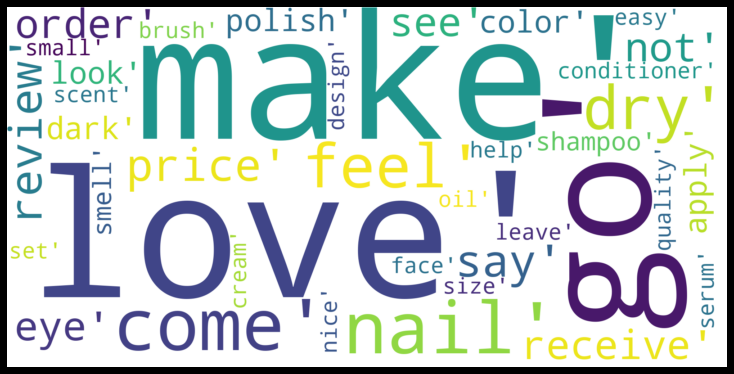

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [37]:
# Using Cloud to see which words are porminent for LDA model


text = ldamodel.show_topics(formatted=False)
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig

### pyLDAvis Vizualization 

In [52]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

2020-09-16 16:30:07,465 : INFO : NumExpr defaulting to 4 threads.


In [53]:
review_doc = review_data['reviewText'].tolist()

In [54]:
#LDA using CountVectorizer and ngram (1,2)

cv = CountVectorizer(ngram_range=(1,2), min_df = .01, max_df =0.8)
cv.fit(review_doc)


CountVectorizer(max_df=0.8, min_df=0.01, ngram_range=(1, 2))

In [55]:
doc_word = cv.transform(review_doc).transpose()


In [56]:
pd.DataFrame(doc_word.toarray(), cv.get_feature_names()).head()


,0,1,2,3,4,5,6,7,8,9,...,100307,100308,100309,100310,100311,100312,100313,100314,100315,100316
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absolutely,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absolutely love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absorb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
acne,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:

# Convert sparse matrix of counts to a gensim corpus
corpus1 = matutils.Sparse2Corpus(doc_word)

In [58]:
lda1 = models.LdaModel(corpus=corpus1, num_topics=5, id2word=dictionary, passes=10)


2020-09-16 16:31:11,227 : INFO : using symmetric alpha at 0.2
2020-09-16 16:31:11,231 : INFO : using symmetric eta at 0.2
2020-09-16 16:31:11,238 : INFO : using serial LDA version on this node
2020-09-16 16:31:11,252 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 100317 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-16 16:31:11,266 : INFO : PROGRESS: pass 0, at document #2000/100317
2020-09-16 16:31:13,688 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:31:13,695 : INFO : topic #0 (0.200): 0.029*"today" + 0.025*"brite" + 0.023*"back" + 0.019*"surprise" + 0.013*"heel" + 0.013*"fragrance" + 0.013*"offer" + 0.012*"stuff" + 0.011*"usage" + 0.010*"liquid"
2020-09-16 16:31:13,697 : INFO : topic #1 (0.200): 0.023*"offer" + 0.020*"surprise" + 0.018*"night" + 0.017*"brite" + 0.016*"tackle

2020-09-16 16:31:20,091 : INFO : topic diff=0.120090, rho=0.408248
2020-09-16 16:31:20,108 : INFO : PROGRESS: pass 0, at document #14000/100317
2020-09-16 16:31:21,220 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:31:21,227 : INFO : topic #0 (0.200): 0.045*"today" + 0.034*"brite" + 0.032*"back" + 0.030*"surprise" + 0.027*"heel" + 0.019*"usage" + 0.017*"stuff" + 0.015*"etc" + 0.014*"previous" + 0.013*"offer"
2020-09-16 16:31:21,229 : INFO : topic #1 (0.200): 0.062*"tackle" + 0.039*"film" + 0.038*"offer" + 0.020*"oil" + 0.017*"hrs" + 0.015*"quick" + 0.014*"long" + 0.013*"okay" + 0.013*"invoke" + 0.012*"surprise"
2020-09-16 16:31:21,230 : INFO : topic #2 (0.200): 0.019*"almost" + 0.013*"remove" + 0.012*"candy" + 0.012*"surprise" + 0.011*"sting" + 0.010*"solid" + 0.010*"benefit" + 0.010*"around" + 0.009*"outrage" + 0.009*"nice"
2020-09-16 16:31:21,232 : INFO : topic #3 (0.200): 0.024*"lotion" + 0.018*"son" + 0.017*"candy" + 0.016*"offer" + 0.01

2020-09-16 16:31:32,607 : INFO : topic #0 (0.200): 0.048*"today" + 0.039*"brite" + 0.030*"heel" + 0.030*"back" + 0.027*"surprise" + 0.020*"usage" + 0.015*"etc" + 0.015*"fragrance" + 0.014*"stuff" + 0.014*"show"
2020-09-16 16:31:32,609 : INFO : topic #1 (0.200): 0.077*"tackle" + 0.040*"offer" + 0.036*"film" + 0.021*"night" + 0.018*"vibe" + 0.015*"invoke" + 0.014*"okay" + 0.014*"hrs" + 0.013*"long" + 0.013*"quick"
2020-09-16 16:31:32,613 : INFO : topic #2 (0.200): 0.021*"almost" + 0.016*"surprise" + 0.014*"candy" + 0.012*"remove" + 0.012*"nice" + 0.010*"dupe" + 0.010*"solid" + 0.009*"compliment" + 0.009*"outrage" + 0.009*"amazon"
2020-09-16 16:31:32,614 : INFO : topic #3 (0.200): 0.024*"lotion" + 0.023*"feminine" + 0.019*"back" + 0.019*"chalky" + 0.018*"candy" + 0.015*"son" + 0.015*"anybody" + 0.015*"offer" + 0.014*"important" + 0.013*"surprise"
2020-09-16 16:31:32,616 : INFO : topic #4 (0.200): 0.037*"another" + 0.032*"feminine" + 0.023*"rather" + 0.022*"do" + 0.018*"actually" + 0.015*"

2020-09-16 16:31:40,296 : INFO : topic #2 (0.200): 0.026*"almost" + 0.018*"surprise" + 0.014*"candy" + 0.012*"offer" + 0.012*"nice" + 0.012*"remove" + 0.011*"amazon" + 0.011*"compliment" + 0.010*"professional" + 0.010*"outrage"
2020-09-16 16:31:40,298 : INFO : topic #3 (0.200): 0.026*"lotion" + 0.019*"back" + 0.018*"anybody" + 0.018*"son" + 0.018*"candy" + 0.014*"offer" + 0.014*"important" + 0.012*"glide" + 0.012*"deep" + 0.012*"surprise"
2020-09-16 16:31:40,299 : INFO : topic #4 (0.200): 0.068*"do" + 0.025*"rather" + 0.021*"feminine" + 0.020*"actually" + 0.020*"another" + 0.017*"offer" + 0.015*"waxy" + 0.013*"apply" + 0.011*"nice" + 0.011*"surprise"
2020-09-16 16:31:40,302 : INFO : topic diff=0.031988, rho=0.229416
2020-09-16 16:31:42,026 : INFO : -5.968 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 2000 documents with 31403 words
2020-09-16 16:31:42,027 : INFO : PROGRESS: pass 0, at document #40000/100317
2020-09-16 16:31:42,972 : INFO : merging changes from 

2020-09-16 16:31:48,499 : INFO : topic #3 (0.200): 0.026*"lotion" + 0.017*"candy" + 0.017*"anybody" + 0.017*"important" + 0.016*"back" + 0.016*"son" + 0.015*"chalky" + 0.015*"glide" + 0.014*"offer" + 0.012*"deep"
2020-09-16 16:31:48,502 : INFO : topic #4 (0.200): 0.055*"do" + 0.026*"another" + 0.025*"feminine" + 0.022*"rather" + 0.022*"offer" + 0.019*"actually" + 0.018*"coastal" + 0.013*"nice" + 0.012*"apply" + 0.011*"dupe"
2020-09-16 16:31:48,510 : INFO : topic diff=0.044743, rho=0.200000
2020-09-16 16:31:48,535 : INFO : PROGRESS: pass 0, at document #52000/100317
2020-09-16 16:31:49,628 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:31:49,634 : INFO : topic #0 (0.200): 0.055*"today" + 0.039*"brite" + 0.030*"heel" + 0.028*"back" + 0.027*"surprise" + 0.021*"usage" + 0.016*"stuff" + 0.015*"etc" + 0.015*"show" + 0.013*"waxy"
2020-09-16 16:31:49,635 : INFO : topic #1 (0.200): 0.082*"tackle" + 0.041*"offer" + 0.033*"film" + 0.020*"invoke" + 0.01

2020-09-16 16:31:58,167 : INFO : topic #4 (0.200): 0.070*"do" + 0.031*"feminine" + 0.027*"another" + 0.024*"offer" + 0.020*"rather" + 0.017*"actually" + 0.015*"coastal" + 0.012*"dupe" + 0.012*"nice" + 0.011*"wearer"
2020-09-16 16:31:58,169 : INFO : topic diff=0.014625, rho=0.179605
2020-09-16 16:31:58,203 : INFO : PROGRESS: pass 0, at document #64000/100317
2020-09-16 16:32:01,315 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:32:01,326 : INFO : topic #0 (0.200): 0.054*"today" + 0.042*"brite" + 0.031*"heel" + 0.030*"back" + 0.028*"surprise" + 0.021*"usage" + 0.015*"stuff" + 0.015*"waxy" + 0.014*"etc" + 0.014*"show"
2020-09-16 16:32:01,331 : INFO : topic #1 (0.200): 0.078*"tackle" + 0.042*"offer" + 0.030*"film" + 0.021*"thank" + 0.020*"invoke" + 0.019*"night" + 0.015*"long" + 0.015*"okay" + 0.014*"beautiful" + 0.014*"vibe"
2020-09-16 16:32:01,336 : INFO : topic #2 (0.200): 0.024*"almost" + 0.020*"surprise" + 0.016*"offer" + 0.016*"will" + 0.0

2020-09-16 16:32:10,259 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:32:10,265 : INFO : topic #0 (0.200): 0.051*"today" + 0.037*"waxy" + 0.032*"brite" + 0.031*"heel" + 0.029*"back" + 0.026*"show" + 0.024*"surprise" + 0.019*"usage" + 0.019*"stuff" + 0.014*"disappointment"
2020-09-16 16:32:10,266 : INFO : topic #1 (0.200): 0.082*"tackle" + 0.042*"film" + 0.037*"offer" + 0.024*"invoke" + 0.018*"night" + 0.018*"thank" + 0.015*"okay" + 0.014*"usual" + 0.014*"long" + 0.013*"quick"
2020-09-16 16:32:10,268 : INFO : topic #2 (0.200): 0.022*"almost" + 0.020*"surprise" + 0.017*"offer" + 0.016*"amazon" + 0.015*"nice" + 0.014*"candy" + 0.013*"professional" + 0.011*"will" + 0.011*"desire" + 0.010*"order"
2020-09-16 16:32:10,269 : INFO : topic #3 (0.200): 0.026*"lotion" + 0.018*"candy" + 0.017*"important" + 0.016*"glide" + 0.015*"back" + 0.015*"anybody" + 0.015*"chalky" + 0.012*"son" + 0.012*"solid" + 0.011*"deep"
2020-09-16 16:32:10,270 : INFO : topic #

2020-09-16 16:32:17,512 : INFO : topic #1 (0.200): 0.082*"tackle" + 0.056*"film" + 0.029*"offer" + 0.026*"invoke" + 0.016*"fact" + 0.016*"night" + 0.016*"quick" + 0.015*"long" + 0.015*"bummer" + 0.014*"previous"
2020-09-16 16:32:17,513 : INFO : topic #2 (0.200): 0.022*"almost" + 0.021*"surprise" + 0.016*"offer" + 0.015*"nice" + 0.014*"candy" + 0.014*"amazon" + 0.012*"professional" + 0.012*"smell" + 0.012*"desire" + 0.010*"hrs"
2020-09-16 16:32:17,514 : INFO : topic #3 (0.200): 0.026*"lotion" + 0.018*"candy" + 0.017*"important" + 0.016*"glide" + 0.015*"back" + 0.014*"anybody" + 0.014*"chalky" + 0.011*"company" + 0.011*"solid" + 0.011*"son"
2020-09-16 16:32:17,515 : INFO : topic #4 (0.200): 0.047*"feminine" + 0.043*"do" + 0.024*"offer" + 0.024*"another" + 0.019*"dupe" + 0.018*"coastal" + 0.016*"rather" + 0.015*"outrage" + 0.014*"actually" + 0.013*"wearer"
2020-09-16 16:32:17,516 : INFO : topic diff=0.062163, rho=0.150756
2020-09-16 16:32:17,534 : INFO : PROGRESS: pass 0, at document #900

2020-09-16 16:32:24,794 : INFO : topic #2 (0.200): 0.025*"almost" + 0.022*"surprise" + 0.016*"offer" + 0.014*"nice" + 0.014*"smell" + 0.014*"amazon" + 0.013*"desire" + 0.013*"professional" + 0.013*"candy" + 0.011*"help"
2020-09-16 16:32:24,795 : INFO : topic #3 (0.200): 0.025*"lotion" + 0.020*"glide" + 0.019*"important" + 0.017*"candy" + 0.015*"ordering" + 0.015*"back" + 0.014*"miracle" + 0.012*"anybody" + 0.012*"solid" + 0.012*"offer"
2020-09-16 16:32:24,797 : INFO : topic #4 (0.200): 0.056*"do" + 0.038*"feminine" + 0.029*"offer" + 0.021*"another" + 0.017*"dupe" + 0.015*"rather" + 0.015*"coastal" + 0.014*"actually" + 0.013*"outrage" + 0.012*"flow"
2020-09-16 16:32:24,798 : INFO : topic diff=0.038141, rho=0.141421
2020-09-16 16:32:25,033 : INFO : -5.798 per-word bound, 55.6 perplexity estimate based on a held-out corpus of 317 documents with 5882 words
2020-09-16 16:32:25,034 : INFO : PROGRESS: pass 0, at document #100317/100317
2020-09-16 16:32:25,180 : INFO : merging changes from 317

2020-09-16 16:32:29,617 : INFO : topic #3 (0.200): 0.023*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.017*"son" + 0.015*"important" + 0.015*"back" + 0.013*"anybody" + 0.012*"prefer" + 0.012*"offer" + 0.012*"miracle"
2020-09-16 16:32:29,619 : INFO : topic #4 (0.200): 0.046*"do" + 0.039*"feminine" + 0.027*"offer" + 0.023*"another" + 0.021*"rather" + 0.018*"actually" + 0.015*"dupe" + 0.013*"outrage" + 0.012*"wearer" + 0.011*"flow"
2020-09-16 16:32:29,619 : INFO : topic diff=0.045564, rho=0.138464
2020-09-16 16:32:29,635 : INFO : PROGRESS: pass 1, at document #12000/100317
2020-09-16 16:32:30,498 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:32:30,504 : INFO : topic #0 (0.200): 0.059*"today" + 0.038*"brite" + 0.033*"heel" + 0.030*"back" + 0.027*"waxy" + 0.025*"surprise" + 0.022*"usage" + 0.021*"show" + 0.018*"stuff" + 0.014*"etc"
2020-09-16 16:32:30,506 : INFO : topic #1 (0.200): 0.084*"tackle" + 0.051*"film" + 0.034*"offer" + 0.020*"previous" 

2020-09-16 16:32:36,000 : INFO : topic #4 (0.200): 0.044*"feminine" + 0.041*"do" + 0.027*"rather" + 0.026*"another" + 0.024*"offer" + 0.021*"actually" + 0.013*"dupe" + 0.013*"wearer" + 0.013*"apply" + 0.013*"outrage"
2020-09-16 16:32:36,001 : INFO : topic diff=0.017753, rho=0.138464
2020-09-16 16:32:36,020 : INFO : PROGRESS: pass 1, at document #24000/100317
2020-09-16 16:32:36,824 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:32:36,830 : INFO : topic #0 (0.200): 0.056*"today" + 0.040*"brite" + 0.034*"heel" + 0.031*"back" + 0.025*"surprise" + 0.023*"waxy" + 0.021*"usage" + 0.021*"show" + 0.015*"stuff" + 0.015*"etc"
2020-09-16 16:32:36,831 : INFO : topic #1 (0.200): 0.091*"tackle" + 0.044*"film" + 0.034*"offer" + 0.023*"night" + 0.018*"long" + 0.018*"invoke" + 0.017*"okay" + 0.017*"previous" + 0.016*"quick" + 0.015*"vibe"
2020-09-16 16:32:36,832 : INFO : topic #2 (0.200): 0.029*"almost" + 0.021*"surprise" + 0.015*"offer" + 0.015*"amazon" + 0

2020-09-16 16:32:42,415 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:32:42,421 : INFO : topic #0 (0.200): 0.057*"today" + 0.040*"brite" + 0.034*"heel" + 0.031*"back" + 0.025*"surprise" + 0.022*"usage" + 0.022*"waxy" + 0.020*"show" + 0.015*"etc" + 0.015*"stuff"
2020-09-16 16:32:42,422 : INFO : topic #1 (0.200): 0.084*"tackle" + 0.041*"film" + 0.033*"offer" + 0.031*"night" + 0.022*"long" + 0.021*"previous" + 0.018*"invoke" + 0.015*"quick" + 0.015*"okay" + 0.013*"vibe"
2020-09-16 16:32:42,424 : INFO : topic #2 (0.200): 0.028*"almost" + 0.022*"surprise" + 0.015*"offer" + 0.014*"amazon" + 0.014*"candy" + 0.014*"nice" + 0.012*"sound" + 0.012*"professional" + 0.012*"help" + 0.012*"compliment"
2020-09-16 16:32:42,425 : INFO : topic #3 (0.200): 0.023*"lotion" + 0.018*"back" + 0.017*"son" + 0.017*"candy" + 0.016*"glide" + 0.014*"anybody" + 0.014*"important" + 0.012*"solid" + 0.012*"deep" + 0.011*"offer"
2020-09-16 16:32:42,427 : INFO : topic #4 (0.2

2020-09-16 16:32:48,777 : INFO : topic #1 (0.200): 0.085*"tackle" + 0.037*"film" + 0.035*"offer" + 0.026*"night" + 0.022*"previous" + 0.019*"invoke" + 0.019*"long" + 0.015*"okay" + 0.015*"thank" + 0.012*"quick"
2020-09-16 16:32:48,778 : INFO : topic #2 (0.200): 0.028*"almost" + 0.022*"surprise" + 0.018*"offer" + 0.016*"amazon" + 0.016*"nice" + 0.015*"candy" + 0.013*"professional" + 0.013*"sound" + 0.012*"help" + 0.012*"compliment"
2020-09-16 16:32:48,779 : INFO : topic #3 (0.200): 0.023*"lotion" + 0.018*"candy" + 0.017*"glide" + 0.017*"back" + 0.016*"son" + 0.015*"important" + 0.014*"anybody" + 0.013*"deep" + 0.013*"solid" + 0.011*"miracle"
2020-09-16 16:32:48,780 : INFO : topic #4 (0.200): 0.056*"do" + 0.035*"feminine" + 0.025*"rather" + 0.024*"offer" + 0.022*"another" + 0.020*"actually" + 0.015*"outrage" + 0.014*"coastal" + 0.014*"dupe" + 0.013*"apply"
2020-09-16 16:32:48,781 : INFO : topic diff=0.017060, rho=0.138464
2020-09-16 16:32:48,798 : INFO : PROGRESS: pass 1, at document #50

2020-09-16 16:32:54,813 : INFO : topic #2 (0.200): 0.028*"almost" + 0.022*"surprise" + 0.019*"offer" + 0.018*"amazon" + 0.017*"nice" + 0.015*"candy" + 0.014*"professional" + 0.013*"compliment" + 0.013*"will" + 0.013*"help"
2020-09-16 16:32:54,815 : INFO : topic #3 (0.200): 0.022*"lotion" + 0.018*"candy" + 0.018*"glide" + 0.016*"back" + 0.015*"important" + 0.014*"son" + 0.014*"anybody" + 0.013*"chalky" + 0.013*"deep" + 0.012*"solid"
2020-09-16 16:32:54,816 : INFO : topic #4 (0.200): 0.070*"do" + 0.037*"feminine" + 0.026*"offer" + 0.026*"another" + 0.021*"rather" + 0.017*"actually" + 0.014*"outrage" + 0.013*"dupe" + 0.013*"coastal" + 0.011*"wearer"
2020-09-16 16:32:54,817 : INFO : topic diff=0.034747, rho=0.138464
2020-09-16 16:32:54,833 : INFO : PROGRESS: pass 1, at document #62000/100317
2020-09-16 16:32:55,629 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:32:55,635 : INFO : topic #0 (0.200): 0.060*"today" + 0.044*"brite" + 0.034*"heel" + 0

2020-09-16 16:32:59,684 : INFO : topic #4 (0.200): 0.061*"do" + 0.045*"feminine" + 0.026*"offer" + 0.025*"another" + 0.017*"dupe" + 0.017*"rather" + 0.016*"coastal" + 0.016*"outrage" + 0.014*"actually" + 0.013*"pine"
2020-09-16 16:32:59,685 : INFO : topic diff=0.020269, rho=0.138464
2020-09-16 16:32:59,701 : INFO : PROGRESS: pass 1, at document #74000/100317
2020-09-16 16:33:00,500 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:33:00,507 : INFO : topic #0 (0.200): 0.058*"today" + 0.042*"brite" + 0.034*"heel" + 0.030*"back" + 0.025*"surprise" + 0.021*"waxy" + 0.020*"usage" + 0.018*"show" + 0.017*"stuff" + 0.015*"etc"
2020-09-16 16:33:00,508 : INFO : topic #1 (0.200): 0.084*"tackle" + 0.036*"offer" + 0.036*"film" + 0.024*"night" + 0.021*"invoke" + 0.020*"thank" + 0.018*"previous" + 0.018*"long" + 0.016*"usual" + 0.015*"okay"
2020-09-16 16:33:00,509 : INFO : topic #2 (0.200): 0.026*"almost" + 0.021*"surprise" + 0.019*"offer" + 0.018*"amazon" + 

2020-09-16 16:33:06,377 : INFO : topic diff=0.045932, rho=0.138464
2020-09-16 16:33:06,394 : INFO : PROGRESS: pass 1, at document #86000/100317
2020-09-16 16:33:07,177 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:33:07,183 : INFO : topic #0 (0.200): 0.057*"today" + 0.038*"brite" + 0.037*"waxy" + 0.034*"heel" + 0.030*"show" + 0.027*"back" + 0.022*"surprise" + 0.020*"stuff" + 0.019*"usage" + 0.015*"etc"
2020-09-16 16:33:07,185 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.052*"film" + 0.030*"offer" + 0.024*"invoke" + 0.021*"night" + 0.017*"long" + 0.016*"fact" + 0.015*"okay" + 0.015*"quick" + 0.014*"thank"
2020-09-16 16:33:07,186 : INFO : topic #2 (0.200): 0.022*"almost" + 0.021*"surprise" + 0.019*"offer" + 0.018*"nice" + 0.015*"amazon" + 0.015*"candy" + 0.014*"professional" + 0.013*"hrs" + 0.013*"help" + 0.013*"sound"
2020-09-16 16:33:07,187 : INFO : topic #3 (0.200): 0.022*"lotion" + 0.018*"glide" + 0.018*"candy" + 0.017*"important" + 0.01

2020-09-16 16:33:12,042 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.061*"film" + 0.028*"offer" + 0.027*"invoke" + 0.023*"long" + 0.017*"fact" + 0.017*"quick" + 0.015*"night" + 0.015*"okay" + 0.015*"usual"
2020-09-16 16:33:12,043 : INFO : topic #2 (0.200): 0.023*"almost" + 0.022*"surprise" + 0.017*"offer" + 0.017*"nice" + 0.015*"smell" + 0.015*"amazon" + 0.015*"professional" + 0.014*"candy" + 0.013*"sound" + 0.012*"hrs"
2020-09-16 16:33:12,044 : INFO : topic #3 (0.200): 0.023*"lotion" + 0.020*"glide" + 0.018*"important" + 0.017*"candy" + 0.015*"back" + 0.013*"miracle" + 0.013*"solid" + 0.012*"company" + 0.011*"well" + 0.011*"anybody"
2020-09-16 16:33:12,046 : INFO : topic #4 (0.200): 0.052*"do" + 0.040*"feminine" + 0.027*"offer" + 0.022*"another" + 0.018*"dupe" + 0.015*"outrage" + 0.015*"rather" + 0.014*"coastal" + 0.013*"actually" + 0.013*"flow"
2020-09-16 16:33:12,047 : INFO : topic diff=0.071592, rho=0.138464
2020-09-16 16:33:13,317 : INFO : -5.827 per-word bound, 56.8 perplexity e

2020-09-16 16:33:17,674 : INFO : topic #2 (0.200): 0.035*"almost" + 0.021*"surprise" + 0.018*"offer" + 0.016*"help" + 0.015*"nice" + 0.015*"amazon" + 0.014*"candy" + 0.013*"professional" + 0.013*"hrs" + 0.012*"smell"
2020-09-16 16:33:17,675 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.019*"glide" + 0.017*"candy" + 0.015*"back" + 0.015*"son" + 0.015*"important" + 0.013*"miracle" + 0.013*"prefer" + 0.012*"solid" + 0.011*"anybody"
2020-09-16 16:33:17,677 : INFO : topic #4 (0.200): 0.048*"do" + 0.038*"feminine" + 0.028*"offer" + 0.024*"another" + 0.020*"rather" + 0.017*"actually" + 0.016*"dupe" + 0.014*"outrage" + 0.013*"flow" + 0.012*"wearer"
2020-09-16 16:33:17,678 : INFO : topic diff=0.027307, rho=0.137156
2020-09-16 16:33:17,696 : INFO : PROGRESS: pass 2, at document #10000/100317
2020-09-16 16:33:18,489 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:33:18,494 : INFO : topic #0 (0.200): 0.062*"today" + 0.039*"brite" + 0.035*"heel" + 0.030*"

2020-09-16 16:33:25,001 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.017*"glide" + 0.017*"candy" + 0.017*"son" + 0.017*"back" + 0.014*"important" + 0.012*"solid" + 0.012*"anybody" + 0.012*"prefer" + 0.011*"deep"
2020-09-16 16:33:25,002 : INFO : topic #4 (0.200): 0.043*"do" + 0.042*"feminine" + 0.025*"offer" + 0.024*"rather" + 0.024*"another" + 0.020*"actually" + 0.015*"outrage" + 0.015*"dupe" + 0.013*"wearer" + 0.012*"apply"
2020-09-16 16:33:25,004 : INFO : topic diff=0.009215, rho=0.137156
2020-09-16 16:33:25,038 : INFO : PROGRESS: pass 2, at document #22000/100317
2020-09-16 16:33:26,036 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:33:26,043 : INFO : topic #0 (0.200): 0.059*"today" + 0.041*"brite" + 0.036*"heel" + 0.031*"back" + 0.025*"surprise" + 0.024*"waxy" + 0.023*"usage" + 0.022*"show" + 0.015*"stuff" + 0.014*"anything"
2020-09-16 16:33:26,045 : INFO : topic #1 (0.200): 0.092*"tackle" + 0.046*"film" + 0.033*"offer" + 0.022*"night" 

2020-09-16 16:33:30,964 : INFO : topic diff=0.043278, rho=0.137156
2020-09-16 16:33:30,981 : INFO : PROGRESS: pass 2, at document #34000/100317
2020-09-16 16:33:31,784 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:33:31,790 : INFO : topic #0 (0.200): 0.059*"today" + 0.041*"brite" + 0.037*"heel" + 0.031*"back" + 0.025*"surprise" + 0.023*"usage" + 0.021*"show" + 0.021*"waxy" + 0.015*"etc" + 0.015*"anything"
2020-09-16 16:33:31,791 : INFO : topic #1 (0.200): 0.085*"tackle" + 0.041*"film" + 0.032*"offer" + 0.032*"night" + 0.023*"long" + 0.022*"previous" + 0.018*"invoke" + 0.016*"quick" + 0.016*"okay" + 0.015*"vibe"
2020-09-16 16:33:31,792 : INFO : topic #2 (0.200): 0.029*"almost" + 0.022*"surprise" + 0.017*"offer" + 0.016*"amazon" + 0.016*"nice" + 0.015*"candy" + 0.014*"sound" + 0.013*"professional" + 0.013*"help" + 0.012*"compliment"
2020-09-16 16:33:31,794 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.018*"back" + 0.017*"candy" + 0.017*"son" 

2020-09-16 16:33:38,526 : INFO : topic #0 (0.200): 0.060*"today" + 0.038*"brite" + 0.038*"heel" + 0.030*"back" + 0.026*"surprise" + 0.026*"waxy" + 0.024*"show" + 0.023*"usage" + 0.014*"etc" + 0.014*"stuff"
2020-09-16 16:33:38,527 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.038*"film" + 0.034*"offer" + 0.028*"night" + 0.024*"previous" + 0.021*"long" + 0.019*"invoke" + 0.015*"okay" + 0.013*"vibe" + 0.013*"etc"
2020-09-16 16:33:38,528 : INFO : topic #2 (0.200): 0.030*"almost" + 0.021*"surprise" + 0.019*"offer" + 0.017*"amazon" + 0.017*"nice" + 0.016*"candy" + 0.014*"sound" + 0.014*"professional" + 0.013*"help" + 0.012*"compliment"
2020-09-16 16:33:38,530 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.018*"candy" + 0.017*"glide" + 0.016*"back" + 0.016*"son" + 0.014*"important" + 0.013*"solid" + 0.012*"deep" + 0.012*"anybody" + 0.011*"company"
2020-09-16 16:33:38,531 : INFO : topic #4 (0.200): 0.059*"do" + 0.034*"feminine" + 0.024*"offer" + 0.023*"rather" + 0.020*"another" + 0.019*"actuall

2020-09-16 16:33:43,671 : INFO : topic #2 (0.200): 0.029*"almost" + 0.022*"surprise" + 0.020*"offer" + 0.018*"nice" + 0.018*"amazon" + 0.016*"candy" + 0.014*"professional" + 0.014*"sound" + 0.013*"help" + 0.013*"hrs"
2020-09-16 16:33:43,673 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"candy" + 0.017*"glide" + 0.016*"back" + 0.015*"important" + 0.014*"son" + 0.013*"anybody" + 0.012*"solid" + 0.012*"deep" + 0.012*"chalky"
2020-09-16 16:33:43,674 : INFO : topic #4 (0.200): 0.051*"do" + 0.040*"feminine" + 0.027*"another" + 0.026*"offer" + 0.021*"rather" + 0.018*"actually" + 0.016*"outrage" + 0.015*"dupe" + 0.012*"wearer" + 0.012*"surprise"
2020-09-16 16:33:43,675 : INFO : topic diff=0.032425, rho=0.137156
2020-09-16 16:33:44,775 : INFO : -5.854 per-word bound, 57.8 perplexity estimate based on a held-out corpus of 2000 documents with 32787 words
2020-09-16 16:33:44,776 : INFO : PROGRESS: pass 2, at document #60000/100317
2020-09-16 16:33:45,500 : INFO : merging changes from 2000 docu

2020-09-16 16:33:49,503 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.017*"glide" + 0.017*"candy" + 0.016*"important" + 0.015*"back" + 0.015*"chalky" + 0.012*"solid" + 0.012*"son" + 0.012*"anybody" + 0.012*"deep"
2020-09-16 16:33:49,504 : INFO : topic #4 (0.200): 0.057*"do" + 0.044*"feminine" + 0.026*"another" + 0.026*"offer" + 0.017*"rather" + 0.016*"dupe" + 0.016*"outrage" + 0.015*"coastal" + 0.014*"actually" + 0.013*"pine"
2020-09-16 16:33:49,505 : INFO : topic diff=0.022287, rho=0.137156
2020-09-16 16:33:49,521 : INFO : PROGRESS: pass 2, at document #72000/100317
2020-09-16 16:33:50,298 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:33:50,304 : INFO : topic #0 (0.200): 0.059*"today" + 0.044*"brite" + 0.035*"heel" + 0.030*"back" + 0.026*"surprise" + 0.021*"usage" + 0.021*"waxy" + 0.018*"show" + 0.018*"stuff" + 0.015*"etc"
2020-09-16 16:33:50,305 : INFO : topic #1 (0.200): 0.085*"tackle" + 0.036*"film" + 0.034*"offer" + 0.025*"night" + 0.0

2020-09-16 16:33:55,372 : INFO : topic #4 (0.200): 0.048*"do" + 0.047*"feminine" + 0.026*"offer" + 0.023*"another" + 0.019*"dupe" + 0.018*"outrage" + 0.015*"rather" + 0.014*"wearer" + 0.013*"actually" + 0.013*"coastal"
2020-09-16 16:33:55,373 : INFO : topic diff=0.008489, rho=0.137156
2020-09-16 16:33:55,390 : INFO : PROGRESS: pass 2, at document #84000/100317
2020-09-16 16:33:56,136 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:33:56,142 : INFO : topic #0 (0.200): 0.059*"today" + 0.036*"brite" + 0.034*"heel" + 0.033*"waxy" + 0.028*"back" + 0.027*"show" + 0.023*"surprise" + 0.020*"usage" + 0.017*"stuff" + 0.014*"decadent"
2020-09-16 16:33:56,142 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.045*"film" + 0.031*"offer" + 0.025*"night" + 0.024*"invoke" + 0.019*"long" + 0.016*"usual" + 0.016*"okay" + 0.015*"thank" + 0.015*"quick"
2020-09-16 16:33:56,144 : INFO : topic #2 (0.200): 0.025*"almost" + 0.021*"surprise" + 0.021*"offer" + 0.019*"nice" 

2020-09-16 16:34:01,085 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:34:01,091 : INFO : topic #0 (0.200): 0.059*"today" + 0.039*"waxy" + 0.036*"heel" + 0.034*"brite" + 0.032*"show" + 0.028*"back" + 0.024*"surprise" + 0.022*"usage" + 0.019*"stuff" + 0.013*"detangle"
2020-09-16 16:34:01,092 : INFO : topic #1 (0.200): 0.090*"tackle" + 0.057*"film" + 0.027*"offer" + 0.027*"invoke" + 0.019*"long" + 0.018*"night" + 0.017*"fact" + 0.016*"usual" + 0.016*"quick" + 0.015*"okay"
2020-09-16 16:34:01,094 : INFO : topic #2 (0.200): 0.024*"almost" + 0.022*"surprise" + 0.019*"offer" + 0.018*"nice" + 0.016*"amazon" + 0.015*"sound" + 0.015*"professional" + 0.015*"candy" + 0.014*"hrs" + 0.013*"smell"
2020-09-16 16:34:01,095 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.020*"glide" + 0.017*"important" + 0.016*"candy" + 0.014*"back" + 0.013*"company" + 0.013*"solid" + 0.013*"miracle" + 0.011*"chalky" + 0.011*"well"
2020-09-16 16:34:01,096 : INFO : topic #4 (0.

2020-09-16 16:34:06,572 : INFO : topic #0 (0.200): 0.064*"today" + 0.040*"brite" + 0.035*"heel" + 0.029*"back" + 0.029*"waxy" + 0.024*"surprise" + 0.023*"usage" + 0.023*"show" + 0.017*"stuff" + 0.014*"offer"
2020-09-16 16:34:06,574 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.055*"film" + 0.031*"offer" + 0.028*"previous" + 0.023*"invoke" + 0.022*"long" + 0.022*"night" + 0.016*"vibe" + 0.016*"quick" + 0.016*"okay"
2020-09-16 16:34:06,575 : INFO : topic #2 (0.200): 0.037*"almost" + 0.021*"surprise" + 0.020*"offer" + 0.017*"nice" + 0.017*"amazon" + 0.016*"help" + 0.015*"hrs" + 0.015*"candy" + 0.014*"professional" + 0.013*"sound"
2020-09-16 16:34:06,576 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.021*"glide" + 0.017*"candy" + 0.016*"important" + 0.014*"son" + 0.014*"back" + 0.013*"miracle" + 0.013*"prefer" + 0.012*"solid" + 0.011*"company"
2020-09-16 16:34:06,577 : INFO : topic #4 (0.200): 0.052*"do" + 0.038*"feminine" + 0.029*"offer" + 0.023*"another" + 0.018*"rather" + 0.017*"dupe" + 

2020-09-16 16:34:11,613 : INFO : topic #2 (0.200): 0.032*"almost" + 0.021*"surprise" + 0.018*"offer" + 0.018*"amazon" + 0.017*"nice" + 0.016*"help" + 0.015*"candy" + 0.015*"sound" + 0.015*"hrs" + 0.014*"tube"
2020-09-16 16:34:11,614 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"son" + 0.017*"candy" + 0.016*"back" + 0.014*"important" + 0.012*"solid" + 0.012*"prefer" + 0.011*"anybody" + 0.011*"deep"
2020-09-16 16:34:11,616 : INFO : topic #4 (0.200): 0.044*"do" + 0.042*"feminine" + 0.025*"offer" + 0.023*"another" + 0.023*"rather" + 0.019*"actually" + 0.015*"outrage" + 0.015*"dupe" + 0.013*"wearer" + 0.012*"flow"
2020-09-16 16:34:11,617 : INFO : topic diff=0.018396, rho=0.135883
2020-09-16 16:34:12,796 : INFO : -5.894 per-word bound, 59.5 perplexity estimate based on a held-out corpus of 2000 documents with 32118 words
2020-09-16 16:34:12,797 : INFO : PROGRESS: pass 3, at document #20000/100317
2020-09-16 16:34:13,553 : INFO : merging changes from 2000 documents into a

2020-09-16 16:34:17,685 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.017*"back" + 0.017*"candy" + 0.017*"son" + 0.017*"glide" + 0.013*"important" + 0.013*"solid" + 0.011*"anybody" + 0.011*"deep" + 0.011*"prefer"
2020-09-16 16:34:17,686 : INFO : topic #4 (0.200): 0.052*"feminine" + 0.037*"do" + 0.029*"another" + 0.024*"rather" + 0.022*"offer" + 0.020*"actually" + 0.016*"outrage" + 0.014*"dupe" + 0.013*"wearer" + 0.012*"surprise"
2020-09-16 16:34:17,687 : INFO : topic diff=0.013675, rho=0.135883
2020-09-16 16:34:17,704 : INFO : PROGRESS: pass 3, at document #32000/100317
2020-09-16 16:34:18,466 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:34:18,473 : INFO : topic #0 (0.200): 0.060*"today" + 0.042*"brite" + 0.038*"heel" + 0.031*"back" + 0.025*"surprise" + 0.023*"usage" + 0.021*"show" + 0.021*"waxy" + 0.015*"anything" + 0.015*"stuff"
2020-09-16 16:34:18,475 : INFO : topic #1 (0.200): 0.084*"tackle" + 0.042*"film" + 0.035*"night" + 0.032*"offe

2020-09-16 16:34:23,778 : INFO : topic #4 (0.200): 0.056*"do" + 0.035*"feminine" + 0.023*"rather" + 0.023*"offer" + 0.021*"another" + 0.019*"actually" + 0.017*"outrage" + 0.015*"dupe" + 0.013*"flow" + 0.013*"wearer"
2020-09-16 16:34:23,780 : INFO : topic diff=0.018108, rho=0.135883
2020-09-16 16:34:23,796 : INFO : PROGRESS: pass 3, at document #44000/100317
2020-09-16 16:34:24,647 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:34:24,653 : INFO : topic #0 (0.200): 0.061*"today" + 0.040*"brite" + 0.038*"heel" + 0.030*"back" + 0.026*"surprise" + 0.025*"waxy" + 0.024*"usage" + 0.022*"show" + 0.015*"stuff" + 0.014*"care"
2020-09-16 16:34:24,655 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.039*"film" + 0.033*"offer" + 0.031*"night" + 0.025*"previous" + 0.022*"long" + 0.019*"invoke" + 0.015*"okay" + 0.014*"quick" + 0.014*"etc"
2020-09-16 16:34:24,656 : INFO : topic #2 (0.200): 0.032*"almost" + 0.021*"surprise" + 0.020*"offer" + 0.018*"amazon" + 0.

2020-09-16 16:34:30,069 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:34:30,075 : INFO : topic #0 (0.200): 0.061*"today" + 0.043*"brite" + 0.037*"heel" + 0.029*"back" + 0.027*"surprise" + 0.024*"waxy" + 0.023*"usage" + 0.022*"show" + 0.015*"care" + 0.015*"stuff"
2020-09-16 16:34:30,077 : INFO : topic #1 (0.200): 0.091*"tackle" + 0.037*"film" + 0.035*"offer" + 0.027*"night" + 0.020*"long" + 0.020*"invoke" + 0.020*"previous" + 0.016*"thank" + 0.015*"okay" + 0.015*"usual"
2020-09-16 16:34:30,078 : INFO : topic #2 (0.200): 0.030*"almost" + 0.021*"surprise" + 0.021*"offer" + 0.019*"nice" + 0.018*"amazon" + 0.016*"candy" + 0.015*"professional" + 0.015*"sound" + 0.014*"hrs" + 0.014*"help"
2020-09-16 16:34:30,080 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.017*"candy" + 0.017*"glide" + 0.015*"back" + 0.015*"son" + 0.014*"important" + 0.013*"solid" + 0.012*"deep" + 0.011*"anybody" + 0.011*"company"
2020-09-16 16:34:30,081 : INFO : topic #4 (0.200)

2020-09-16 16:34:35,886 : INFO : topic #1 (0.200): 0.088*"tackle" + 0.036*"film" + 0.034*"offer" + 0.027*"night" + 0.020*"invoke" + 0.020*"previous" + 0.019*"long" + 0.019*"usual" + 0.017*"thank" + 0.015*"okay"
2020-09-16 16:34:35,887 : INFO : topic #2 (0.200): 0.029*"almost" + 0.021*"offer" + 0.021*"surprise" + 0.021*"amazon" + 0.019*"nice" + 0.017*"candy" + 0.016*"professional" + 0.015*"coastal" + 0.015*"hrs" + 0.014*"will"
2020-09-16 16:34:35,889 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.015*"important" + 0.015*"back" + 0.013*"son" + 0.013*"solid" + 0.012*"chalky" + 0.012*"deep" + 0.011*"anybody"
2020-09-16 16:34:35,890 : INFO : topic #4 (0.200): 0.064*"do" + 0.039*"feminine" + 0.025*"offer" + 0.025*"another" + 0.017*"rather" + 0.016*"dupe" + 0.016*"outrage" + 0.014*"pine" + 0.014*"actually" + 0.013*"flow"
2020-09-16 16:34:35,891 : INFO : topic diff=0.041679, rho=0.135883
2020-09-16 16:34:35,906 : INFO : PROGRESS: pass 3, at document #70000/100317

2020-09-16 16:34:41,498 : INFO : topic #2 (0.200): 0.025*"almost" + 0.022*"offer" + 0.020*"nice" + 0.020*"surprise" + 0.019*"amazon" + 0.017*"candy" + 0.016*"professional" + 0.016*"sound" + 0.016*"hrs" + 0.015*"coastal"
2020-09-16 16:34:41,500 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.016*"important" + 0.014*"back" + 0.014*"chalky" + 0.013*"solid" + 0.012*"son" + 0.012*"company" + 0.011*"deep"
2020-09-16 16:34:41,502 : INFO : topic #4 (0.200): 0.052*"do" + 0.046*"feminine" + 0.025*"offer" + 0.023*"another" + 0.019*"dupe" + 0.018*"outrage" + 0.016*"rather" + 0.013*"wearer" + 0.013*"actually" + 0.013*"flow"
2020-09-16 16:34:41,502 : INFO : topic diff=0.043370, rho=0.135883
2020-09-16 16:34:41,520 : INFO : PROGRESS: pass 3, at document #82000/100317
2020-09-16 16:34:42,287 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:34:42,293 : INFO : topic #0 (0.200): 0.059*"today" + 0.037*"brite" + 0.035*"heel" + 0.033*"

2020-09-16 16:34:46,476 : INFO : topic #4 (0.200): 0.044*"feminine" + 0.042*"do" + 0.026*"another" + 0.026*"offer" + 0.019*"dupe" + 0.017*"outrage" + 0.015*"rather" + 0.014*"flow" + 0.013*"wearer" + 0.012*"actually"
2020-09-16 16:34:46,476 : INFO : topic diff=0.027872, rho=0.135883
2020-09-16 16:34:46,494 : INFO : PROGRESS: pass 3, at document #94000/100317
2020-09-16 16:34:47,307 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:34:47,314 : INFO : topic #0 (0.200): 0.060*"today" + 0.037*"heel" + 0.037*"waxy" + 0.036*"brite" + 0.030*"show" + 0.028*"back" + 0.024*"surprise" + 0.021*"usage" + 0.019*"stuff" + 0.013*"detangle"
2020-09-16 16:34:47,315 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.053*"film" + 0.027*"offer" + 0.025*"invoke" + 0.021*"night" + 0.019*"long" + 0.017*"usual" + 0.017*"fact" + 0.016*"previous" + 0.016*"quick"
2020-09-16 16:34:47,317 : INFO : topic #2 (0.200): 0.024*"almost" + 0.022*"surprise" + 0.021*"offer" + 0.019*"nice" 

2020-09-16 16:34:52,254 : INFO : topic diff=0.022404, rho=0.134646
2020-09-16 16:34:52,275 : INFO : PROGRESS: pass 4, at document #4000/100317
2020-09-16 16:34:53,035 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:34:53,041 : INFO : topic #0 (0.200): 0.066*"today" + 0.040*"brite" + 0.035*"heel" + 0.029*"waxy" + 0.028*"back" + 0.024*"surprise" + 0.023*"usage" + 0.022*"show" + 0.017*"stuff" + 0.014*"detangle"
2020-09-16 16:34:53,042 : INFO : topic #1 (0.200): 0.084*"tackle" + 0.057*"film" + 0.031*"offer" + 0.030*"previous" + 0.024*"night" + 0.024*"invoke" + 0.023*"long" + 0.016*"etc" + 0.016*"quick" + 0.016*"okay"
2020-09-16 16:34:53,043 : INFO : topic #2 (0.200): 0.039*"almost" + 0.021*"offer" + 0.021*"surprise" + 0.019*"nice" + 0.017*"amazon" + 0.017*"help" + 0.015*"hrs" + 0.015*"professional" + 0.015*"candy" + 0.014*"sound"
2020-09-16 16:34:53,044 : INFO : topic #3 (0.200): 0.022*"glide" + 0.020*"lotion" + 0.017*"candy" + 0.016*"important" 

2020-09-16 16:34:58,056 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.050*"film" + 0.032*"offer" + 0.024*"night" + 0.023*"previous" + 0.020*"long" + 0.018*"invoke" + 0.018*"quick" + 0.017*"okay" + 0.017*"usual"
2020-09-16 16:34:58,058 : INFO : topic #2 (0.200): 0.034*"almost" + 0.021*"surprise" + 0.020*"offer" + 0.019*"amazon" + 0.018*"nice" + 0.016*"hrs" + 0.016*"help" + 0.015*"candy" + 0.015*"tube" + 0.014*"professional"
2020-09-16 16:34:58,060 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.018*"glide" + 0.017*"son" + 0.017*"candy" + 0.015*"back" + 0.014*"important" + 0.013*"solid" + 0.012*"prefer" + 0.011*"miracle" + 0.011*"deep"
2020-09-16 16:34:58,062 : INFO : topic #4 (0.200): 0.045*"do" + 0.040*"feminine" + 0.025*"offer" + 0.024*"another" + 0.022*"rather" + 0.018*"actually" + 0.015*"dupe" + 0.015*"outrage" + 0.014*"flow" + 0.013*"wearer"
2020-09-16 16:34:58,063 : INFO : topic diff=0.013023, rho=0.134646
2020-09-16 16:34:58,088 : INFO : PROGRESS: pass 4, at document #18000/100317


2020-09-16 16:35:03,902 : INFO : topic #2 (0.200): 0.031*"almost" + 0.021*"surprise" + 0.019*"offer" + 0.019*"nice" + 0.018*"amazon" + 0.016*"candy" + 0.016*"sound" + 0.015*"help" + 0.015*"hrs" + 0.014*"professional"
2020-09-16 16:35:03,903 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"candy" + 0.017*"glide" + 0.017*"back" + 0.017*"son" + 0.013*"important" + 0.013*"solid" + 0.011*"prefer" + 0.011*"anybody" + 0.011*"surprise"
2020-09-16 16:35:03,904 : INFO : topic #4 (0.200): 0.051*"feminine" + 0.034*"do" + 0.029*"another" + 0.024*"rather" + 0.022*"offer" + 0.020*"actually" + 0.015*"outrage" + 0.015*"dupe" + 0.013*"wearer" + 0.013*"flow"
2020-09-16 16:35:03,905 : INFO : topic diff=0.024367, rho=0.134646
2020-09-16 16:35:03,922 : INFO : PROGRESS: pass 4, at document #30000/100317
2020-09-16 16:35:04,665 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:35:04,679 : INFO : topic #0 (0.200): 0.059*"today" + 0.042*"brite" + 0.038*"heel" + 0.031*

2020-09-16 16:35:09,557 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"candy" + 0.017*"son" + 0.016*"back" + 0.016*"glide" + 0.013*"solid" + 0.012*"important" + 0.011*"anybody" + 0.011*"deep" + 0.011*"liquid"
2020-09-16 16:35:09,559 : INFO : topic #4 (0.200): 0.054*"do" + 0.037*"feminine" + 0.023*"rather" + 0.022*"offer" + 0.021*"another" + 0.019*"actually" + 0.017*"outrage" + 0.015*"dupe" + 0.014*"flow" + 0.013*"wearer"
2020-09-16 16:35:09,560 : INFO : topic diff=0.030442, rho=0.134646
2020-09-16 16:35:09,577 : INFO : PROGRESS: pass 4, at document #42000/100317
2020-09-16 16:35:10,295 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:35:10,301 : INFO : topic #0 (0.200): 0.061*"today" + 0.041*"brite" + 0.039*"heel" + 0.030*"back" + 0.026*"surprise" + 0.025*"waxy" + 0.024*"usage" + 0.022*"show" + 0.015*"stuff" + 0.015*"vibe"
2020-09-16 16:35:10,302 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.041*"film" + 0.034*"night" + 0.032*"offer" + 0.0

2020-09-16 16:35:14,124 : INFO : topic diff=0.011747, rho=0.134646
2020-09-16 16:35:14,141 : INFO : PROGRESS: pass 4, at document #54000/100317
2020-09-16 16:35:14,850 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:35:14,857 : INFO : topic #0 (0.200): 0.062*"today" + 0.042*"brite" + 0.038*"heel" + 0.029*"back" + 0.027*"surprise" + 0.024*"waxy" + 0.023*"usage" + 0.023*"show" + 0.015*"stuff" + 0.014*"vibe"
2020-09-16 16:35:14,858 : INFO : topic #1 (0.200): 0.091*"tackle" + 0.036*"film" + 0.034*"offer" + 0.028*"night" + 0.022*"previous" + 0.020*"long" + 0.019*"invoke" + 0.016*"thank" + 0.016*"usual" + 0.014*"okay"
2020-09-16 16:35:14,859 : INFO : topic #2 (0.200): 0.030*"almost" + 0.022*"offer" + 0.021*"surprise" + 0.020*"nice" + 0.018*"amazon" + 0.016*"candy" + 0.015*"sound" + 0.015*"professional" + 0.015*"hrs" + 0.015*"will"
2020-09-16 16:35:14,860 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.016*"son" + 0.014

2020-09-16 16:35:20,633 : INFO : topic #0 (0.200): 0.061*"today" + 0.047*"brite" + 0.036*"heel" + 0.030*"back" + 0.027*"surprise" + 0.022*"usage" + 0.020*"waxy" + 0.018*"show" + 0.016*"stuff" + 0.015*"etc"
2020-09-16 16:35:20,635 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.036*"film" + 0.034*"offer" + 0.028*"night" + 0.021*"previous" + 0.019*"invoke" + 0.019*"long" + 0.018*"thank" + 0.017*"usual" + 0.015*"okay"
2020-09-16 16:35:20,636 : INFO : topic #2 (0.200): 0.030*"almost" + 0.022*"offer" + 0.021*"surprise" + 0.020*"nice" + 0.019*"amazon" + 0.017*"candy" + 0.016*"professional" + 0.016*"will" + 0.016*"hrs" + 0.015*"sound"
2020-09-16 16:35:20,637 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.015*"important" + 0.015*"back" + 0.013*"son" + 0.013*"solid" + 0.012*"chalky" + 0.012*"deep" + 0.011*"company"
2020-09-16 16:35:20,638 : INFO : topic #4 (0.200): 0.064*"do" + 0.037*"feminine" + 0.025*"another" + 0.025*"offer" + 0.018*"rather" + 0.016*"outrage" + 0

2020-09-16 16:35:25,428 : INFO : topic #2 (0.200): 0.026*"almost" + 0.023*"offer" + 0.021*"nice" + 0.020*"amazon" + 0.020*"surprise" + 0.017*"candy" + 0.017*"professional" + 0.017*"hrs" + 0.016*"coastal" + 0.016*"sound"
2020-09-16 16:35:25,429 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.016*"important" + 0.015*"back" + 0.014*"chalky" + 0.013*"solid" + 0.012*"son" + 0.012*"company" + 0.011*"anybody"
2020-09-16 16:35:25,430 : INFO : topic #4 (0.200): 0.054*"do" + 0.046*"feminine" + 0.025*"another" + 0.025*"offer" + 0.019*"dupe" + 0.017*"outrage" + 0.016*"rather" + 0.014*"flow" + 0.014*"actually" + 0.012*"wearer"
2020-09-16 16:35:25,431 : INFO : topic diff=0.021741, rho=0.134646
2020-09-16 16:35:26,612 : INFO : -5.891 per-word bound, 59.4 perplexity estimate based on a held-out corpus of 2000 documents with 30926 words
2020-09-16 16:35:26,613 : INFO : PROGRESS: pass 4, at document #80000/100317
2020-09-16 16:35:27,343 : INFO : merging changes from 2000 do

2020-09-16 16:35:31,466 : INFO : topic #3 (0.200): 0.021*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.015*"important" + 0.014*"back" + 0.013*"company" + 0.013*"solid" + 0.012*"chalky" + 0.011*"son" + 0.011*"keep"
2020-09-16 16:35:31,467 : INFO : topic #4 (0.200): 0.046*"feminine" + 0.039*"do" + 0.025*"offer" + 0.024*"another" + 0.020*"dupe" + 0.018*"outrage" + 0.015*"rather" + 0.015*"flow" + 0.013*"wearer" + 0.013*"actually"
2020-09-16 16:35:31,468 : INFO : topic diff=0.021236, rho=0.134646
2020-09-16 16:35:31,485 : INFO : PROGRESS: pass 4, at document #92000/100317
2020-09-16 16:35:32,244 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:35:32,250 : INFO : topic #0 (0.200): 0.060*"today" + 0.038*"heel" + 0.037*"waxy" + 0.035*"brite" + 0.031*"show" + 0.028*"back" + 0.024*"surprise" + 0.021*"usage" + 0.020*"stuff" + 0.014*"detangle"
2020-09-16 16:35:32,252 : INFO : topic #1 (0.200): 0.088*"tackle" + 0.053*"film" + 0.026*"offer" + 0.025*"invoke" 

2020-09-16 16:35:36,818 : INFO : topic #4 (0.200): 0.049*"do" + 0.034*"feminine" + 0.029*"offer" + 0.020*"flow" + 0.019*"dupe" + 0.019*"another" + 0.015*"outrage" + 0.015*"rather" + 0.014*"actually" + 0.012*"surprise"
2020-09-16 16:35:36,819 : INFO : topic diff=0.044309, rho=0.134646
2020-09-16 16:35:36,833 : INFO : PROGRESS: pass 5, at document #2000/100317
2020-09-16 16:35:37,644 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:35:37,650 : INFO : topic #0 (0.200): 0.066*"today" + 0.039*"brite" + 0.035*"heel" + 0.029*"waxy" + 0.028*"back" + 0.024*"surprise" + 0.023*"usage" + 0.023*"show" + 0.017*"stuff" + 0.015*"detangle"
2020-09-16 16:35:37,652 : INFO : topic #1 (0.200): 0.083*"tackle" + 0.057*"film" + 0.030*"offer" + 0.030*"previous" + 0.027*"night" + 0.025*"invoke" + 0.025*"long" + 0.017*"etc" + 0.015*"quick" + 0.015*"okay"
2020-09-16 16:35:37,653 : INFO : topic #2 (0.200): 0.043*"almost" + 0.022*"offer" + 0.021*"surprise" + 0.019*"nice" +

2020-09-16 16:35:42,680 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:35:42,686 : INFO : topic #0 (0.200): 0.061*"today" + 0.040*"brite" + 0.036*"heel" + 0.029*"back" + 0.029*"waxy" + 0.025*"surprise" + 0.023*"usage" + 0.022*"show" + 0.016*"stuff" + 0.014*"offer"
2020-09-16 16:35:42,687 : INFO : topic #1 (0.200): 0.090*"tackle" + 0.051*"film" + 0.032*"offer" + 0.024*"previous" + 0.021*"long" + 0.021*"night" + 0.019*"invoke" + 0.018*"quick" + 0.017*"okay" + 0.017*"usual"
2020-09-16 16:35:42,688 : INFO : topic #2 (0.200): 0.035*"almost" + 0.021*"offer" + 0.020*"surprise" + 0.019*"nice" + 0.017*"amazon" + 0.017*"hrs" + 0.017*"help" + 0.016*"candy" + 0.015*"professional" + 0.015*"tube"
2020-09-16 16:35:42,690 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.018*"glide" + 0.017*"son" + 0.017*"candy" + 0.014*"back" + 0.014*"important" + 0.012*"solid" + 0.012*"prefer" + 0.011*"miracle" + 0.011*"company"
2020-09-16 16:35:42,691 : INFO : topic #4 (0.20

2020-09-16 16:35:49,342 : INFO : topic #1 (0.200): 0.094*"tackle" + 0.044*"film" + 0.032*"offer" + 0.029*"night" + 0.020*"long" + 0.019*"previous" + 0.017*"invoke" + 0.017*"usual" + 0.017*"okay" + 0.017*"vibe"
2020-09-16 16:35:49,344 : INFO : topic #2 (0.200): 0.032*"almost" + 0.021*"surprise" + 0.020*"offer" + 0.019*"nice" + 0.018*"amazon" + 0.017*"candy" + 0.016*"hrs" + 0.016*"help" + 0.016*"sound" + 0.015*"professional"
2020-09-16 16:35:49,345 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"candy" + 0.017*"back" + 0.017*"glide" + 0.016*"son" + 0.014*"important" + 0.013*"solid" + 0.011*"chalky" + 0.011*"prefer" + 0.011*"surprise"
2020-09-16 16:35:49,346 : INFO : topic #4 (0.200): 0.054*"feminine" + 0.033*"do" + 0.031*"another" + 0.023*"rather" + 0.022*"offer" + 0.019*"actually" + 0.015*"dupe" + 0.015*"outrage" + 0.013*"flow" + 0.013*"wearer"
2020-09-16 16:35:49,347 : INFO : topic diff=0.022808, rho=0.133442
2020-09-16 16:35:49,365 : INFO : PROGRESS: pass 5, at document #28000/1003

2020-09-16 16:35:54,701 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"son" + 0.017*"candy" + 0.016*"glide" + 0.016*"back" + 0.013*"solid" + 0.012*"important" + 0.011*"deep" + 0.011*"anybody" + 0.011*"company"
2020-09-16 16:35:54,702 : INFO : topic #4 (0.200): 0.057*"do" + 0.038*"feminine" + 0.023*"rather" + 0.022*"another" + 0.022*"offer" + 0.019*"actually" + 0.017*"outrage" + 0.015*"dupe" + 0.014*"flow" + 0.013*"surprise"
2020-09-16 16:35:54,704 : INFO : topic diff=0.020822, rho=0.133442
2020-09-16 16:35:55,903 : INFO : -5.914 per-word bound, 60.3 perplexity estimate based on a held-out corpus of 2000 documents with 31403 words
2020-09-16 16:35:55,904 : INFO : PROGRESS: pass 5, at document #40000/100317
2020-09-16 16:35:56,778 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:35:56,785 : INFO : topic #0 (0.200): 0.060*"today" + 0.041*"brite" + 0.038*"heel" + 0.030*"back" + 0.026*"surprise" + 0.024*"waxy" + 0.023*"usage" + 0.022*"show" + 0

2020-09-16 16:36:01,230 : INFO : topic #4 (0.200): 0.053*"do" + 0.034*"feminine" + 0.024*"another" + 0.024*"offer" + 0.022*"rather" + 0.018*"actually" + 0.017*"outrage" + 0.015*"dupe" + 0.015*"flow" + 0.013*"surprise"
2020-09-16 16:36:01,231 : INFO : topic diff=0.033202, rho=0.133442
2020-09-16 16:36:01,249 : INFO : PROGRESS: pass 5, at document #52000/100317
2020-09-16 16:36:01,980 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:36:01,986 : INFO : topic #0 (0.200): 0.061*"today" + 0.042*"brite" + 0.038*"heel" + 0.029*"back" + 0.027*"surprise" + 0.024*"waxy" + 0.023*"usage" + 0.022*"show" + 0.015*"vibe" + 0.015*"stuff"
2020-09-16 16:36:01,987 : INFO : topic #1 (0.200): 0.092*"tackle" + 0.037*"film" + 0.033*"offer" + 0.029*"night" + 0.022*"previous" + 0.020*"long" + 0.019*"invoke" + 0.016*"usual" + 0.015*"thank" + 0.015*"okay"
2020-09-16 16:36:01,988 : INFO : topic #2 (0.200): 0.028*"almost" + 0.023*"offer" + 0.020*"surprise" + 0.020*"nice" + 

2020-09-16 16:36:07,075 : INFO : topic diff=0.013391, rho=0.133442
2020-09-16 16:36:07,091 : INFO : PROGRESS: pass 5, at document #64000/100317
2020-09-16 16:36:07,842 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:36:07,849 : INFO : topic #0 (0.200): 0.061*"today" + 0.045*"brite" + 0.038*"heel" + 0.030*"back" + 0.028*"surprise" + 0.024*"usage" + 0.022*"waxy" + 0.020*"show" + 0.016*"vibe" + 0.015*"care"
2020-09-16 16:36:07,850 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.035*"offer" + 0.034*"film" + 0.028*"night" + 0.020*"previous" + 0.020*"thank" + 0.020*"long" + 0.019*"invoke" + 0.018*"usual" + 0.016*"okay"
2020-09-16 16:36:07,851 : INFO : topic #2 (0.200): 0.030*"almost" + 0.023*"offer" + 0.021*"nice" + 0.021*"surprise" + 0.019*"amazon" + 0.018*"will" + 0.017*"candy" + 0.016*"hrs" + 0.016*"professional" + 0.015*"sound"
2020-09-16 16:36:07,853 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.018*"glide" + 0.018*"candy" + 0.015*"back" + 0.014

2020-09-16 16:36:12,785 : INFO : topic #1 (0.200): 0.091*"tackle" + 0.043*"film" + 0.032*"offer" + 0.025*"night" + 0.022*"invoke" + 0.019*"previous" + 0.018*"thank" + 0.018*"usual" + 0.018*"long" + 0.016*"okay"
2020-09-16 16:36:12,786 : INFO : topic #2 (0.200): 0.027*"almost" + 0.024*"offer" + 0.021*"nice" + 0.020*"amazon" + 0.020*"surprise" + 0.018*"candy" + 0.018*"coastal" + 0.018*"professional" + 0.017*"hrs" + 0.017*"sound"
2020-09-16 16:36:12,787 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.015*"important" + 0.014*"back" + 0.013*"solid" + 0.012*"son" + 0.012*"chalky" + 0.012*"company" + 0.011*"keep"
2020-09-16 16:36:12,790 : INFO : topic #4 (0.200): 0.057*"do" + 0.042*"feminine" + 0.025*"offer" + 0.024*"another" + 0.018*"dupe" + 0.018*"outrage" + 0.017*"rather" + 0.015*"flow" + 0.015*"actually" + 0.012*"pine"
2020-09-16 16:36:12,790 : INFO : topic diff=0.049911, rho=0.133442
2020-09-16 16:36:12,809 : INFO : PROGRESS: pass 5, at document #78000/10031

2020-09-16 16:36:19,058 : INFO : topic #2 (0.200): 0.027*"almost" + 0.023*"offer" + 0.021*"nice" + 0.021*"surprise" + 0.018*"amazon" + 0.017*"hrs" + 0.017*"candy" + 0.016*"professional" + 0.016*"coastal" + 0.016*"sound"
2020-09-16 16:36:19,059 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.015*"important" + 0.014*"back" + 0.013*"company" + 0.013*"solid" + 0.011*"chalky" + 0.011*"son" + 0.011*"keep"
2020-09-16 16:36:19,060 : INFO : topic #4 (0.200): 0.045*"feminine" + 0.042*"do" + 0.023*"offer" + 0.023*"another" + 0.020*"dupe" + 0.018*"outrage" + 0.015*"flow" + 0.015*"rather" + 0.013*"actually" + 0.013*"wearer"
2020-09-16 16:36:19,061 : INFO : topic diff=0.056813, rho=0.133442
2020-09-16 16:36:19,079 : INFO : PROGRESS: pass 5, at document #90000/100317
2020-09-16 16:36:19,897 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:36:19,903 : INFO : topic #0 (0.200): 0.058*"today" + 0.040*"waxy" + 0.038*"heel" + 0.034*"b

2020-09-16 16:36:26,497 : INFO : topic #3 (0.200): 0.021*"glide" + 0.020*"lotion" + 0.017*"important" + 0.016*"candy" + 0.013*"miracle" + 0.013*"back" + 0.013*"solid" + 0.013*"company" + 0.012*"well" + 0.011*"prefer"
2020-09-16 16:36:26,499 : INFO : topic #4 (0.200): 0.052*"do" + 0.036*"feminine" + 0.027*"offer" + 0.020*"another" + 0.019*"dupe" + 0.018*"flow" + 0.016*"outrage" + 0.014*"rather" + 0.013*"actually" + 0.012*"surprise"
2020-09-16 16:36:26,502 : INFO : topic diff=0.034082, rho=0.133442
2020-09-16 16:36:26,765 : INFO : -5.788 per-word bound, 55.2 perplexity estimate based on a held-out corpus of 317 documents with 5882 words
2020-09-16 16:36:26,766 : INFO : PROGRESS: pass 5, at document #100317/100317
2020-09-16 16:36:26,897 : INFO : merging changes from 317 documents into a model of 100317 documents
2020-09-16 16:36:26,903 : INFO : topic #0 (0.200): 0.068*"today" + 0.037*"brite" + 0.036*"heel" + 0.031*"waxy" + 0.027*"back" + 0.025*"show" + 0.024*"usage" + 0.024*"surprise" + 

2020-09-16 16:36:31,034 : INFO : topic #4 (0.200): 0.044*"do" + 0.037*"feminine" + 0.026*"offer" + 0.022*"another" + 0.020*"rather" + 0.017*"flow" + 0.017*"actually" + 0.017*"dupe" + 0.016*"outrage" + 0.012*"wearer"
2020-09-16 16:36:31,035 : INFO : topic diff=0.041146, rho=0.132269
2020-09-16 16:36:31,053 : INFO : PROGRESS: pass 6, at document #12000/100317
2020-09-16 16:36:31,807 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:36:31,813 : INFO : topic #0 (0.200): 0.062*"today" + 0.040*"brite" + 0.037*"heel" + 0.029*"waxy" + 0.029*"back" + 0.025*"surprise" + 0.023*"usage" + 0.023*"show" + 0.017*"stuff" + 0.014*"offer"
2020-09-16 16:36:31,814 : INFO : topic #1 (0.200): 0.088*"tackle" + 0.053*"film" + 0.031*"offer" + 0.025*"previous" + 0.021*"long" + 0.021*"night" + 0.019*"invoke" + 0.018*"quick" + 0.017*"okay" + 0.015*"usual"
2020-09-16 16:36:31,815 : INFO : topic #2 (0.200): 0.037*"almost" + 0.022*"offer" + 0.020*"surprise" + 0.020*"nice" + 0

2020-09-16 16:36:41,084 : INFO : topic diff=0.014936, rho=0.132269
2020-09-16 16:36:41,119 : INFO : PROGRESS: pass 6, at document #24000/100317
2020-09-16 16:36:42,231 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:36:42,239 : INFO : topic #0 (0.200): 0.059*"today" + 0.042*"brite" + 0.037*"heel" + 0.031*"back" + 0.025*"surprise" + 0.024*"waxy" + 0.023*"usage" + 0.023*"show" + 0.015*"vibe" + 0.015*"anything"
2020-09-16 16:36:42,240 : INFO : topic #1 (0.200): 0.094*"tackle" + 0.045*"film" + 0.032*"offer" + 0.029*"night" + 0.020*"previous" + 0.020*"long" + 0.017*"invoke" + 0.017*"okay" + 0.017*"usual" + 0.017*"quick"
2020-09-16 16:36:42,241 : INFO : topic #2 (0.200): 0.034*"almost" + 0.021*"offer" + 0.020*"surprise" + 0.020*"nice" + 0.019*"amazon" + 0.017*"help" + 0.017*"hrs" + 0.017*"candy" + 0.016*"sound" + 0.015*"professional"
2020-09-16 16:36:42,242 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"candy" + 0.017*"glide" + 0.017*"back" + 0

2020-09-16 16:36:48,655 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.042*"film" + 0.038*"night" + 0.031*"offer" + 0.025*"previous" + 0.023*"long" + 0.018*"invoke" + 0.016*"quick" + 0.015*"fragrance" + 0.015*"okay"
2020-09-16 16:36:48,657 : INFO : topic #2 (0.200): 0.034*"almost" + 0.021*"surprise" + 0.020*"offer" + 0.019*"nice" + 0.019*"amazon" + 0.017*"sound" + 0.016*"candy" + 0.016*"professional" + 0.015*"hrs" + 0.015*"help"
2020-09-16 16:36:48,658 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"son" + 0.017*"candy" + 0.017*"glide" + 0.016*"back" + 0.013*"solid" + 0.012*"important" + 0.011*"deep" + 0.011*"surprise" + 0.011*"company"
2020-09-16 16:36:48,660 : INFO : topic #4 (0.200): 0.053*"do" + 0.039*"feminine" + 0.022*"rather" + 0.022*"another" + 0.021*"offer" + 0.019*"actually" + 0.018*"outrage" + 0.015*"dupe" + 0.015*"flow" + 0.013*"surprise"
2020-09-16 16:36:48,662 : INFO : topic diff=0.022100, rho=0.132269
2020-09-16 16:36:48,679 : INFO : PROGRESS: pass 6, at document #3800

2020-09-16 16:37:01,320 : INFO : topic #2 (0.200): 0.032*"almost" + 0.022*"offer" + 0.021*"surprise" + 0.020*"nice" + 0.019*"amazon" + 0.017*"candy" + 0.016*"sound" + 0.016*"professional" + 0.015*"coastal" + 0.015*"help"
2020-09-16 16:37:01,322 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"glide" + 0.017*"candy" + 0.016*"son" + 0.015*"back" + 0.013*"important" + 0.013*"solid" + 0.012*"deep" + 0.011*"company" + 0.011*"anybody"
2020-09-16 16:37:01,325 : INFO : topic #4 (0.200): 0.052*"do" + 0.033*"feminine" + 0.023*"offer" + 0.023*"rather" + 0.020*"another" + 0.019*"actually" + 0.017*"outrage" + 0.016*"dupe" + 0.015*"flow" + 0.013*"surprise"
2020-09-16 16:37:01,326 : INFO : topic diff=0.014333, rho=0.132269
2020-09-16 16:37:01,344 : INFO : PROGRESS: pass 6, at document #50000/100317
2020-09-16 16:37:02,303 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:37:02,309 : INFO : topic #0 (0.200): 0.061*"today" + 0.040*"brite" + 0.038*"heel" + 0.0

2020-09-16 16:37:09,041 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.014*"son" + 0.014*"back" + 0.014*"important" + 0.013*"solid" + 0.012*"deep" + 0.012*"chalky" + 0.011*"anybody"
2020-09-16 16:37:09,045 : INFO : topic #4 (0.200): 0.066*"do" + 0.036*"feminine" + 0.025*"another" + 0.025*"offer" + 0.020*"rather" + 0.016*"actually" + 0.016*"outrage" + 0.015*"dupe" + 0.014*"flow" + 0.013*"surprise"
2020-09-16 16:37:09,046 : INFO : topic diff=0.033366, rho=0.132269
2020-09-16 16:37:09,072 : INFO : PROGRESS: pass 6, at document #62000/100317
2020-09-16 16:37:10,105 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:37:10,111 : INFO : topic #0 (0.200): 0.062*"today" + 0.046*"brite" + 0.037*"heel" + 0.029*"back" + 0.027*"surprise" + 0.024*"usage" + 0.022*"waxy" + 0.019*"show" + 0.016*"vibe" + 0.015*"care"
2020-09-16 16:37:10,112 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.035*"film" + 0.035*"offer" + 0.028*"night" + 0.

2020-09-16 16:37:15,817 : INFO : topic diff=0.019536, rho=0.132269
2020-09-16 16:37:15,839 : INFO : PROGRESS: pass 6, at document #74000/100317
2020-09-16 16:37:16,759 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:37:16,769 : INFO : topic #0 (0.200): 0.060*"today" + 0.044*"brite" + 0.037*"heel" + 0.030*"back" + 0.026*"surprise" + 0.022*"waxy" + 0.021*"usage" + 0.018*"show" + 0.017*"stuff" + 0.015*"vibe"
2020-09-16 16:37:16,770 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.036*"film" + 0.034*"offer" + 0.029*"night" + 0.021*"thank" + 0.021*"previous" + 0.020*"invoke" + 0.019*"usual" + 0.019*"long" + 0.015*"fragrance"
2020-09-16 16:37:16,775 : INFO : topic #2 (0.200): 0.029*"almost" + 0.024*"offer" + 0.021*"amazon" + 0.021*"nice" + 0.020*"surprise" + 0.018*"candy" + 0.018*"coastal" + 0.017*"professional" + 0.017*"hrs" + 0.017*"sound"
2020-09-16 16:37:16,778 : INFO : topic #3 (0.200): 0.019*"lotion" + 0.017*"glide" + 0.017*"candy" + 0.015*"impo

2020-09-16 16:37:23,391 : INFO : topic #0 (0.200): 0.058*"today" + 0.039*"brite" + 0.038*"waxy" + 0.035*"heel" + 0.030*"show" + 0.027*"back" + 0.023*"surprise" + 0.020*"usage" + 0.019*"stuff" + 0.014*"etc"
2020-09-16 16:37:23,393 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.052*"film" + 0.028*"offer" + 0.026*"night" + 0.024*"invoke" + 0.018*"long" + 0.016*"fact" + 0.016*"etc" + 0.015*"quick" + 0.015*"okay"
2020-09-16 16:37:23,395 : INFO : topic #2 (0.200): 0.025*"almost" + 0.023*"offer" + 0.022*"nice" + 0.020*"surprise" + 0.018*"amazon" + 0.018*"hrs" + 0.017*"candy" + 0.017*"coastal" + 0.017*"professional" + 0.016*"sound"
2020-09-16 16:37:23,397 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.018*"glide" + 0.017*"candy" + 0.016*"important" + 0.013*"solid" + 0.013*"back" + 0.013*"chalky" + 0.013*"company" + 0.011*"keep" + 0.011*"son"
2020-09-16 16:37:23,400 : INFO : topic #4 (0.200): 0.045*"feminine" + 0.042*"do" + 0.024*"offer" + 0.023*"another" + 0.020*"dupe" + 0.018*"outrage" + 0.015*

2020-09-16 16:37:29,389 : INFO : topic #2 (0.200): 0.026*"almost" + 0.022*"offer" + 0.021*"surprise" + 0.021*"nice" + 0.018*"amazon" + 0.017*"professional" + 0.017*"hrs" + 0.016*"sound" + 0.016*"candy" + 0.014*"smell"
2020-09-16 16:37:29,392 : INFO : topic #3 (0.200): 0.020*"lotion" + 0.020*"glide" + 0.017*"important" + 0.016*"candy" + 0.014*"back" + 0.013*"solid" + 0.013*"company" + 0.012*"miracle" + 0.011*"well" + 0.011*"surprise"
2020-09-16 16:37:29,394 : INFO : topic #4 (0.200): 0.049*"do" + 0.038*"feminine" + 0.025*"offer" + 0.021*"another" + 0.019*"dupe" + 0.017*"flow" + 0.016*"outrage" + 0.014*"rather" + 0.013*"actually" + 0.012*"wearer"
2020-09-16 16:37:29,396 : INFO : topic diff=0.070015, rho=0.132269
2020-09-16 16:37:30,653 : INFO : -5.826 per-word bound, 56.7 perplexity estimate based on a held-out corpus of 2000 documents with 36182 words
2020-09-16 16:37:30,654 : INFO : PROGRESS: pass 6, at document #100000/100317
2020-09-16 16:37:31,493 : INFO : merging changes from 2000 

2020-09-16 16:37:35,581 : INFO : topic #3 (0.200): 0.020*"glide" + 0.019*"lotion" + 0.017*"candy" + 0.015*"son" + 0.014*"important" + 0.014*"back" + 0.013*"solid" + 0.012*"prefer" + 0.012*"miracle" + 0.011*"company"
2020-09-16 16:37:35,582 : INFO : topic #4 (0.200): 0.046*"do" + 0.037*"feminine" + 0.026*"offer" + 0.022*"another" + 0.019*"rather" + 0.018*"flow" + 0.017*"dupe" + 0.016*"actually" + 0.015*"outrage" + 0.012*"surprise"
2020-09-16 16:37:35,584 : INFO : topic diff=0.027161, rho=0.131127
2020-09-16 16:37:35,601 : INFO : PROGRESS: pass 7, at document #10000/100317
2020-09-16 16:37:36,510 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:37:36,519 : INFO : topic #0 (0.200): 0.063*"today" + 0.040*"brite" + 0.037*"heel" + 0.030*"waxy" + 0.029*"back" + 0.025*"surprise" + 0.024*"usage" + 0.023*"show" + 0.017*"stuff" + 0.014*"vibe"
2020-09-16 16:37:36,521 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.054*"film" + 0.031*"offer" + 0.024*"previou

2020-09-16 16:37:42,071 : INFO : topic #4 (0.200): 0.041*"do" + 0.040*"feminine" + 0.023*"offer" + 0.023*"rather" + 0.023*"another" + 0.018*"actually" + 0.016*"outrage" + 0.016*"flow" + 0.015*"dupe" + 0.013*"wearer"
2020-09-16 16:37:42,075 : INFO : topic diff=0.007284, rho=0.131127
2020-09-16 16:37:42,116 : INFO : PROGRESS: pass 7, at document #22000/100317
2020-09-16 16:37:43,687 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:37:43,697 : INFO : topic #0 (0.200): 0.060*"today" + 0.042*"brite" + 0.037*"heel" + 0.030*"back" + 0.025*"surprise" + 0.025*"waxy" + 0.023*"usage" + 0.023*"show" + 0.015*"anything" + 0.015*"vibe"
2020-09-16 16:37:43,699 : INFO : topic #1 (0.200): 0.092*"tackle" + 0.046*"film" + 0.032*"offer" + 0.026*"night" + 0.021*"previous" + 0.019*"long" + 0.018*"invoke" + 0.017*"quick" + 0.016*"okay" + 0.016*"usual"
2020-09-16 16:37:43,701 : INFO : topic #2 (0.200): 0.035*"almost" + 0.021*"offer" + 0.020*"nice" + 0.020*"surprise" +

2020-09-16 16:37:50,011 : INFO : PROGRESS: pass 7, at document #34000/100317
2020-09-16 16:37:51,156 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:37:51,165 : INFO : topic #0 (0.200): 0.060*"today" + 0.042*"brite" + 0.038*"heel" + 0.031*"back" + 0.026*"surprise" + 0.024*"usage" + 0.022*"show" + 0.022*"waxy" + 0.016*"vibe" + 0.015*"anything"
2020-09-16 16:37:51,170 : INFO : topic #1 (0.200): 0.085*"tackle" + 0.042*"film" + 0.036*"night" + 0.031*"offer" + 0.023*"long" + 0.023*"previous" + 0.017*"invoke" + 0.016*"fragrance" + 0.016*"quick" + 0.015*"okay"
2020-09-16 16:37:51,172 : INFO : topic #2 (0.200): 0.033*"almost" + 0.021*"surprise" + 0.021*"offer" + 0.019*"amazon" + 0.019*"nice" + 0.017*"sound" + 0.017*"candy" + 0.016*"hrs" + 0.015*"professional" + 0.015*"help"
2020-09-16 16:37:51,176 : INFO : topic #3 (0.200): 0.018*"lotion" + 0.017*"son" + 0.017*"candy" + 0.016*"back" + 0.016*"glide" + 0.013*"solid" + 0.012*"important" + 0.011*"surpris

2020-09-16 16:37:58,622 : INFO : topic #0 (0.200): 0.061*"today" + 0.039*"heel" + 0.039*"brite" + 0.030*"back" + 0.026*"surprise" + 0.026*"waxy" + 0.024*"show" + 0.023*"usage" + 0.016*"vibe" + 0.014*"care"
2020-09-16 16:37:58,625 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.038*"film" + 0.032*"offer" + 0.031*"night" + 0.025*"previous" + 0.021*"long" + 0.019*"invoke" + 0.015*"okay" + 0.015*"fragrance" + 0.015*"etc"
2020-09-16 16:37:58,627 : INFO : topic #2 (0.200): 0.033*"almost" + 0.022*"offer" + 0.021*"surprise" + 0.020*"nice" + 0.020*"amazon" + 0.017*"candy" + 0.016*"sound" + 0.016*"professional" + 0.016*"coastal" + 0.015*"help"
2020-09-16 16:37:58,629 : INFO : topic #3 (0.200): 0.018*"lotion" + 0.017*"glide" + 0.017*"candy" + 0.016*"son" + 0.015*"back" + 0.013*"solid" + 0.013*"important" + 0.011*"deep" + 0.011*"company" + 0.011*"surprise"
2020-09-16 16:37:58,635 : INFO : topic #4 (0.200): 0.055*"do" + 0.032*"feminine" + 0.022*"offer" + 0.022*"rather" + 0.019*"another" + 0.018*"actu

2020-09-16 16:38:04,560 : INFO : topic #2 (0.200): 0.031*"almost" + 0.024*"offer" + 0.021*"nice" + 0.021*"surprise" + 0.020*"amazon" + 0.017*"candy" + 0.016*"professional" + 0.016*"sound" + 0.016*"hrs" + 0.016*"coastal"
2020-09-16 16:38:04,562 : INFO : topic #3 (0.200): 0.018*"lotion" + 0.017*"glide" + 0.017*"candy" + 0.015*"son" + 0.014*"back" + 0.014*"important" + 0.013*"solid" + 0.012*"deep" + 0.011*"anybody" + 0.011*"chalky"
2020-09-16 16:38:04,563 : INFO : topic #4 (0.200): 0.050*"do" + 0.039*"feminine" + 0.026*"another" + 0.024*"offer" + 0.021*"rather" + 0.017*"actually" + 0.016*"outrage" + 0.016*"dupe" + 0.014*"flow" + 0.013*"surprise"
2020-09-16 16:38:04,564 : INFO : topic diff=0.028658, rho=0.131127
2020-09-16 16:38:06,523 : INFO : -5.848 per-word bound, 57.6 perplexity estimate based on a held-out corpus of 2000 documents with 32787 words
2020-09-16 16:38:06,524 : INFO : PROGRESS: pass 7, at document #60000/100317
2020-09-16 16:38:07,567 : INFO : merging changes from 2000 doc

2020-09-16 16:38:12,475 : INFO : topic #3 (0.200): 0.018*"lotion" + 0.017*"glide" + 0.017*"candy" + 0.015*"important" + 0.014*"back" + 0.014*"chalky" + 0.013*"son" + 0.013*"solid" + 0.011*"company" + 0.011*"deep"
2020-09-16 16:38:12,477 : INFO : topic #4 (0.200): 0.056*"do" + 0.042*"feminine" + 0.026*"another" + 0.024*"offer" + 0.017*"dupe" + 0.017*"outrage" + 0.016*"rather" + 0.014*"flow" + 0.014*"actually" + 0.013*"pine"
2020-09-16 16:38:12,478 : INFO : topic diff=0.019814, rho=0.131127
2020-09-16 16:38:12,497 : INFO : PROGRESS: pass 7, at document #72000/100317
2020-09-16 16:38:13,588 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:38:13,596 : INFO : topic #0 (0.200): 0.060*"today" + 0.045*"brite" + 0.036*"heel" + 0.030*"back" + 0.026*"surprise" + 0.021*"usage" + 0.021*"waxy" + 0.019*"show" + 0.017*"stuff" + 0.015*"vibe"
2020-09-16 16:38:13,597 : INFO : topic #1 (0.200): 0.085*"tackle" + 0.036*"film" + 0.033*"offer" + 0.028*"night" + 0.022

2020-09-16 16:38:21,446 : INFO : topic #4 (0.200): 0.047*"do" + 0.045*"feminine" + 0.024*"offer" + 0.022*"another" + 0.020*"dupe" + 0.018*"outrage" + 0.015*"rather" + 0.015*"flow" + 0.013*"wearer" + 0.013*"actually"
2020-09-16 16:38:21,448 : INFO : topic diff=0.007646, rho=0.131127
2020-09-16 16:38:21,474 : INFO : PROGRESS: pass 7, at document #84000/100317
2020-09-16 16:38:22,502 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:38:22,509 : INFO : topic #0 (0.200): 0.059*"today" + 0.037*"brite" + 0.035*"heel" + 0.033*"waxy" + 0.028*"back" + 0.027*"show" + 0.024*"surprise" + 0.021*"usage" + 0.017*"stuff" + 0.014*"vibe"
2020-09-16 16:38:22,510 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.045*"film" + 0.030*"offer" + 0.029*"night" + 0.023*"invoke" + 0.019*"long" + 0.017*"usual" + 0.015*"okay" + 0.015*"thank" + 0.015*"quick"
2020-09-16 16:38:22,511 : INFO : topic #2 (0.200): 0.027*"almost" + 0.024*"offer" + 0.022*"nice" + 0.020*"surprise" + 0.019

2020-09-16 16:38:28,943 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:38:28,950 : INFO : topic #0 (0.200): 0.059*"today" + 0.039*"waxy" + 0.036*"heel" + 0.034*"brite" + 0.032*"show" + 0.027*"back" + 0.024*"surprise" + 0.022*"usage" + 0.018*"stuff" + 0.014*"detangle"
2020-09-16 16:38:28,951 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.056*"film" + 0.026*"offer" + 0.026*"invoke" + 0.021*"night" + 0.019*"long" + 0.017*"usual" + 0.017*"fact" + 0.016*"quick" + 0.015*"okay"
2020-09-16 16:38:28,952 : INFO : topic #2 (0.200): 0.026*"almost" + 0.023*"offer" + 0.021*"nice" + 0.021*"surprise" + 0.018*"amazon" + 0.017*"hrs" + 0.017*"sound" + 0.017*"professional" + 0.016*"candy" + 0.014*"coastal"
2020-09-16 16:38:28,954 : INFO : topic #3 (0.200): 0.020*"glide" + 0.019*"lotion" + 0.016*"important" + 0.016*"candy" + 0.013*"back" + 0.013*"solid" + 0.013*"company" + 0.012*"miracle" + 0.011*"surprise" + 0.011*"keep"
2020-09-16 16:38:28,956 : INFO : topic #4

2020-09-16 16:38:36,233 : INFO : topic #0 (0.200): 0.064*"today" + 0.040*"brite" + 0.035*"heel" + 0.029*"waxy" + 0.029*"back" + 0.024*"surprise" + 0.023*"usage" + 0.023*"show" + 0.017*"stuff" + 0.014*"offer"
2020-09-16 16:38:36,235 : INFO : topic #1 (0.200): 0.085*"tackle" + 0.054*"film" + 0.030*"offer" + 0.028*"previous" + 0.024*"night" + 0.023*"invoke" + 0.022*"long" + 0.016*"vibe" + 0.016*"etc" + 0.016*"okay"
2020-09-16 16:38:36,236 : INFO : topic #2 (0.200): 0.039*"almost" + 0.024*"offer" + 0.021*"nice" + 0.020*"surprise" + 0.019*"amazon" + 0.018*"hrs" + 0.017*"help" + 0.016*"candy" + 0.016*"professional" + 0.015*"sound"
2020-09-16 16:38:36,239 : INFO : topic #3 (0.200): 0.021*"glide" + 0.018*"lotion" + 0.016*"candy" + 0.015*"important" + 0.015*"son" + 0.013*"back" + 0.013*"solid" + 0.013*"prefer" + 0.012*"miracle" + 0.012*"company"
2020-09-16 16:38:36,242 : INFO : topic #4 (0.200): 0.050*"do" + 0.037*"feminine" + 0.027*"offer" + 0.022*"another" + 0.019*"flow" + 0.018*"dupe" + 0.01

2020-09-16 16:38:42,009 : INFO : topic #2 (0.200): 0.034*"almost" + 0.022*"offer" + 0.020*"nice" + 0.020*"surprise" + 0.020*"amazon" + 0.018*"hrs" + 0.017*"help" + 0.017*"candy" + 0.017*"sound" + 0.015*"tube"
2020-09-16 16:38:42,010 : INFO : topic #3 (0.200): 0.018*"lotion" + 0.018*"son" + 0.017*"glide" + 0.016*"candy" + 0.015*"back" + 0.014*"important" + 0.013*"solid" + 0.012*"prefer" + 0.011*"company" + 0.011*"surprise"
2020-09-16 16:38:42,012 : INFO : topic #4 (0.200): 0.042*"do" + 0.041*"feminine" + 0.024*"offer" + 0.023*"another" + 0.022*"rather" + 0.018*"actually" + 0.016*"dupe" + 0.016*"outrage" + 0.015*"flow" + 0.012*"wearer"
2020-09-16 16:38:42,014 : INFO : topic diff=0.017608, rho=0.130014
2020-09-16 16:38:43,261 : INFO : -5.894 per-word bound, 59.5 perplexity estimate based on a held-out corpus of 2000 documents with 32118 words
2020-09-16 16:38:43,261 : INFO : PROGRESS: pass 8, at document #20000/100317
2020-09-16 16:38:44,048 : INFO : merging changes from 2000 documents in

2020-09-16 16:38:48,423 : INFO : topic #3 (0.200): 0.018*"son" + 0.017*"lotion" + 0.017*"glide" + 0.016*"candy" + 0.016*"back" + 0.013*"solid" + 0.013*"important" + 0.011*"surprise" + 0.011*"company" + 0.011*"deep"
2020-09-16 16:38:48,425 : INFO : topic #4 (0.200): 0.049*"feminine" + 0.036*"do" + 0.028*"another" + 0.023*"rather" + 0.021*"offer" + 0.019*"actually" + 0.016*"outrage" + 0.015*"dupe" + 0.014*"flow" + 0.013*"surprise"
2020-09-16 16:38:48,426 : INFO : topic diff=0.011897, rho=0.130014
2020-09-16 16:38:48,443 : INFO : PROGRESS: pass 8, at document #32000/100317
2020-09-16 16:38:49,294 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:38:49,300 : INFO : topic #0 (0.200): 0.061*"today" + 0.043*"brite" + 0.038*"heel" + 0.031*"back" + 0.026*"surprise" + 0.023*"usage" + 0.021*"show" + 0.021*"waxy" + 0.015*"anything" + 0.015*"vibe"
2020-09-16 16:38:49,301 : INFO : topic #1 (0.200): 0.083*"tackle" + 0.042*"film" + 0.037*"night" + 0.031*"offer

2020-09-16 16:38:54,410 : INFO : topic #4 (0.200): 0.054*"do" + 0.034*"feminine" + 0.022*"rather" + 0.022*"offer" + 0.020*"another" + 0.018*"actually" + 0.017*"outrage" + 0.016*"flow" + 0.015*"dupe" + 0.013*"surprise"
2020-09-16 16:38:54,412 : INFO : topic diff=0.017584, rho=0.130014
2020-09-16 16:38:54,429 : INFO : PROGRESS: pass 8, at document #44000/100317
2020-09-16 16:38:55,141 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:38:55,147 : INFO : topic #0 (0.200): 0.061*"today" + 0.040*"brite" + 0.039*"heel" + 0.030*"back" + 0.026*"surprise" + 0.025*"waxy" + 0.024*"usage" + 0.022*"show" + 0.015*"vibe" + 0.014*"care"
2020-09-16 16:38:55,149 : INFO : topic #1 (0.200): 0.085*"tackle" + 0.039*"film" + 0.033*"night" + 0.032*"offer" + 0.025*"previous" + 0.022*"long" + 0.019*"invoke" + 0.015*"okay" + 0.014*"fragrance" + 0.014*"etc"
2020-09-16 16:38:55,150 : INFO : topic #2 (0.200): 0.035*"almost" + 0.023*"offer" + 0.020*"surprise" + 0.020*"amazon"

2020-09-16 16:38:58,823 : INFO : PROGRESS: pass 8, at document #56000/100317
2020-09-16 16:38:59,538 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:38:59,544 : INFO : topic #0 (0.200): 0.061*"today" + 0.043*"brite" + 0.038*"heel" + 0.029*"back" + 0.027*"surprise" + 0.024*"waxy" + 0.023*"usage" + 0.022*"show" + 0.015*"care" + 0.015*"vibe"
2020-09-16 16:38:59,545 : INFO : topic #1 (0.200): 0.090*"tackle" + 0.037*"film" + 0.034*"offer" + 0.028*"night" + 0.020*"long" + 0.020*"previous" + 0.020*"invoke" + 0.016*"thank" + 0.015*"okay" + 0.015*"usual"
2020-09-16 16:38:59,546 : INFO : topic #2 (0.200): 0.032*"almost" + 0.024*"offer" + 0.021*"surprise" + 0.021*"nice" + 0.020*"amazon" + 0.017*"candy" + 0.016*"professional" + 0.016*"sound" + 0.016*"hrs" + 0.015*"coastal"
2020-09-16 16:38:59,548 : INFO : topic #3 (0.200): 0.017*"glide" + 0.017*"lotion" + 0.017*"candy" + 0.015*"son" + 0.014*"back" + 0.013*"important" + 0.013*"solid" + 0.011*"deep" + 0.01

2020-09-16 16:39:05,528 : INFO : topic #0 (0.200): 0.061*"today" + 0.045*"brite" + 0.036*"heel" + 0.030*"back" + 0.027*"surprise" + 0.023*"usage" + 0.021*"waxy" + 0.018*"show" + 0.016*"stuff" + 0.015*"vibe"
2020-09-16 16:39:05,529 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.036*"film" + 0.033*"offer" + 0.028*"night" + 0.019*"previous" + 0.019*"invoke" + 0.019*"long" + 0.019*"usual" + 0.017*"thank" + 0.015*"etc"
2020-09-16 16:39:05,531 : INFO : topic #2 (0.200): 0.031*"almost" + 0.024*"offer" + 0.023*"amazon" + 0.021*"nice" + 0.020*"surprise" + 0.018*"coastal" + 0.017*"candy" + 0.017*"professional" + 0.017*"hrs" + 0.015*"will"
2020-09-16 16:39:05,532 : INFO : topic #3 (0.200): 0.018*"glide" + 0.017*"lotion" + 0.016*"candy" + 0.014*"important" + 0.014*"back" + 0.013*"son" + 0.013*"solid" + 0.012*"chalky" + 0.012*"deep" + 0.012*"company"
2020-09-16 16:39:05,533 : INFO : topic #4 (0.200): 0.062*"do" + 0.038*"feminine" + 0.024*"offer" + 0.024*"another" + 0.017*"dupe" + 0.017*"rather" + 0.

2020-09-16 16:39:10,896 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.041*"film" + 0.032*"offer" + 0.023*"night" + 0.022*"invoke" + 0.018*"thank" + 0.018*"previous" + 0.017*"long" + 0.016*"okay" + 0.016*"usual"
2020-09-16 16:39:10,897 : INFO : topic #2 (0.200): 0.027*"almost" + 0.025*"offer" + 0.022*"nice" + 0.022*"amazon" + 0.020*"surprise" + 0.018*"hrs" + 0.018*"coastal" + 0.018*"candy" + 0.017*"sound" + 0.017*"professional"
2020-09-16 16:39:10,898 : INFO : topic #3 (0.200): 0.018*"glide" + 0.017*"lotion" + 0.017*"candy" + 0.015*"important" + 0.014*"solid" + 0.013*"back" + 0.013*"chalky" + 0.012*"son" + 0.012*"company" + 0.011*"keep"
2020-09-16 16:39:10,900 : INFO : topic #4 (0.200): 0.051*"do" + 0.045*"feminine" + 0.024*"offer" + 0.022*"another" + 0.019*"dupe" + 0.018*"outrage" + 0.016*"rather" + 0.015*"flow" + 0.013*"actually" + 0.013*"wearer"
2020-09-16 16:39:10,901 : INFO : topic diff=0.040760, rho=0.130014
2020-09-16 16:39:10,916 : INFO : PROGRESS: pass 8, at document #82000/100

2020-09-16 16:39:15,549 : INFO : topic #3 (0.200): 0.018*"lotion" + 0.018*"glide" + 0.016*"candy" + 0.015*"important" + 0.013*"back" + 0.013*"company" + 0.013*"solid" + 0.013*"chalky" + 0.011*"keep" + 0.011*"son"
2020-09-16 16:39:15,550 : INFO : topic #4 (0.200): 0.043*"feminine" + 0.041*"do" + 0.025*"another" + 0.024*"offer" + 0.020*"dupe" + 0.017*"outrage" + 0.015*"flow" + 0.014*"rather" + 0.013*"wearer" + 0.012*"actually"
2020-09-16 16:39:15,551 : INFO : topic diff=0.025660, rho=0.130014
2020-09-16 16:39:15,567 : INFO : PROGRESS: pass 8, at document #94000/100317
2020-09-16 16:39:16,323 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:39:16,329 : INFO : topic #0 (0.200): 0.060*"today" + 0.037*"heel" + 0.037*"waxy" + 0.036*"brite" + 0.030*"show" + 0.028*"back" + 0.024*"surprise" + 0.021*"usage" + 0.019*"stuff" + 0.014*"detangle"
2020-09-16 16:39:16,330 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.052*"film" + 0.026*"offer" + 0.025*"invoke" 

2020-09-16 16:39:20,967 : INFO : topic #4 (0.200): 0.047*"do" + 0.032*"feminine" + 0.027*"offer" + 0.020*"flow" + 0.020*"dupe" + 0.017*"another" + 0.016*"rather" + 0.016*"outrage" + 0.015*"actually" + 0.012*"surprise"
2020-09-16 16:39:20,969 : INFO : topic diff=0.021671, rho=0.128929
2020-09-16 16:39:20,986 : INFO : PROGRESS: pass 9, at document #4000/100317
2020-09-16 16:39:21,696 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:39:21,702 : INFO : topic #0 (0.200): 0.065*"today" + 0.040*"brite" + 0.035*"heel" + 0.029*"waxy" + 0.028*"back" + 0.024*"surprise" + 0.023*"usage" + 0.022*"show" + 0.017*"stuff" + 0.014*"detangle"
2020-09-16 16:39:21,703 : INFO : topic #1 (0.200): 0.083*"tackle" + 0.056*"film" + 0.030*"offer" + 0.029*"previous" + 0.024*"night" + 0.023*"invoke" + 0.022*"long" + 0.016*"etc" + 0.016*"okay" + 0.016*"quick"
2020-09-16 16:39:21,704 : INFO : topic #2 (0.200): 0.041*"almost" + 0.024*"offer" + 0.021*"nice" + 0.020*"surprise" +

2020-09-16 16:39:26,484 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:39:26,490 : INFO : topic #0 (0.200): 0.061*"today" + 0.041*"brite" + 0.036*"heel" + 0.030*"back" + 0.027*"waxy" + 0.025*"surprise" + 0.023*"usage" + 0.021*"show" + 0.016*"stuff" + 0.015*"offer"
2020-09-16 16:39:26,492 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.049*"film" + 0.032*"offer" + 0.024*"night" + 0.022*"previous" + 0.020*"long" + 0.018*"invoke" + 0.018*"quick" + 0.017*"okay" + 0.016*"usual"
2020-09-16 16:39:26,493 : INFO : topic #2 (0.200): 0.036*"almost" + 0.022*"offer" + 0.021*"amazon" + 0.020*"nice" + 0.020*"surprise" + 0.018*"hrs" + 0.017*"help" + 0.016*"candy" + 0.016*"tube" + 0.015*"professional"
2020-09-16 16:39:26,494 : INFO : topic #3 (0.200): 0.018*"glide" + 0.017*"son" + 0.017*"lotion" + 0.016*"candy" + 0.014*"back" + 0.013*"important" + 0.013*"solid" + 0.012*"prefer" + 0.011*"surprise" + 0.011*"company"
2020-09-16 16:39:26,495 : INFO : topic #4 (0.2

2020-09-16 16:39:32,169 : INFO : topic #1 (0.200): 0.086*"tackle" + 0.044*"film" + 0.035*"night" + 0.030*"offer" + 0.021*"long" + 0.019*"previous" + 0.017*"invoke" + 0.017*"fragrance" + 0.017*"quick" + 0.016*"okay"
2020-09-16 16:39:32,170 : INFO : topic #2 (0.200): 0.034*"almost" + 0.021*"amazon" + 0.021*"offer" + 0.020*"surprise" + 0.020*"nice" + 0.017*"candy" + 0.017*"hrs" + 0.017*"sound" + 0.017*"help" + 0.015*"professional"
2020-09-16 16:39:32,171 : INFO : topic #3 (0.200): 0.017*"glide" + 0.017*"lotion" + 0.017*"son" + 0.016*"back" + 0.016*"candy" + 0.013*"solid" + 0.013*"important" + 0.011*"surprise" + 0.011*"company" + 0.011*"prefer"
2020-09-16 16:39:32,173 : INFO : topic #4 (0.200): 0.049*"feminine" + 0.033*"do" + 0.028*"another" + 0.023*"rather" + 0.022*"offer" + 0.019*"actually" + 0.015*"outrage" + 0.015*"dupe" + 0.014*"flow" + 0.013*"surprise"
2020-09-16 16:39:32,174 : INFO : topic diff=0.021487, rho=0.128929
2020-09-16 16:39:32,192 : INFO : PROGRESS: pass 9, at document #30

2020-09-16 16:39:38,059 : INFO : topic #2 (0.200): 0.034*"almost" + 0.022*"offer" + 0.020*"surprise" + 0.020*"amazon" + 0.020*"nice" + 0.017*"candy" + 0.016*"sound" + 0.016*"help" + 0.016*"hrs" + 0.015*"professional"
2020-09-16 16:39:38,060 : INFO : topic #3 (0.200): 0.017*"son" + 0.017*"lotion" + 0.016*"glide" + 0.016*"candy" + 0.016*"back" + 0.014*"solid" + 0.012*"important" + 0.011*"surprise" + 0.011*"liquid" + 0.011*"company"
2020-09-16 16:39:38,062 : INFO : topic #4 (0.200): 0.052*"do" + 0.036*"feminine" + 0.022*"rather" + 0.021*"offer" + 0.020*"another" + 0.019*"actually" + 0.017*"outrage" + 0.015*"flow" + 0.015*"dupe" + 0.013*"surprise"
2020-09-16 16:39:38,063 : INFO : topic diff=0.029642, rho=0.128929
2020-09-16 16:39:38,083 : INFO : PROGRESS: pass 9, at document #42000/100317
2020-09-16 16:39:38,822 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:39:38,828 : INFO : topic #0 (0.200): 0.061*"today" + 0.041*"brite" + 0.040*"heel" + 0.03

2020-09-16 16:39:42,543 : INFO : topic #4 (0.200): 0.054*"do" + 0.034*"feminine" + 0.024*"offer" + 0.023*"another" + 0.022*"rather" + 0.018*"actually" + 0.017*"outrage" + 0.015*"flow" + 0.015*"dupe" + 0.013*"surprise"
2020-09-16 16:39:42,544 : INFO : topic diff=0.010454, rho=0.128929
2020-09-16 16:39:42,560 : INFO : PROGRESS: pass 9, at document #54000/100317
2020-09-16 16:39:43,241 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:39:43,247 : INFO : topic #0 (0.200): 0.061*"today" + 0.042*"brite" + 0.038*"heel" + 0.029*"back" + 0.027*"surprise" + 0.024*"waxy" + 0.024*"usage" + 0.023*"show" + 0.015*"vibe" + 0.015*"stuff"
2020-09-16 16:39:43,248 : INFO : topic #1 (0.200): 0.089*"tackle" + 0.036*"film" + 0.034*"offer" + 0.028*"night" + 0.021*"previous" + 0.020*"long" + 0.019*"invoke" + 0.016*"thank" + 0.015*"usual" + 0.015*"fragrance"
2020-09-16 16:39:43,249 : INFO : topic #2 (0.200): 0.031*"almost" + 0.024*"offer" + 0.021*"nice" + 0.020*"surpris

2020-09-16 16:39:48,051 : INFO : topic diff=0.026173, rho=0.128929
2020-09-16 16:39:48,071 : INFO : PROGRESS: pass 9, at document #66000/100317
2020-09-16 16:39:48,795 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:39:48,801 : INFO : topic #0 (0.200): 0.061*"today" + 0.047*"brite" + 0.036*"heel" + 0.030*"back" + 0.027*"surprise" + 0.023*"usage" + 0.020*"waxy" + 0.018*"show" + 0.016*"stuff" + 0.016*"vibe"
2020-09-16 16:39:48,802 : INFO : topic #1 (0.200): 0.087*"tackle" + 0.035*"film" + 0.034*"offer" + 0.027*"night" + 0.021*"previous" + 0.019*"invoke" + 0.018*"long" + 0.018*"thank" + 0.017*"usual" + 0.015*"okay"
2020-09-16 16:39:48,803 : INFO : topic #2 (0.200): 0.032*"almost" + 0.024*"offer" + 0.022*"amazon" + 0.022*"nice" + 0.021*"surprise" + 0.017*"candy" + 0.017*"professional" + 0.017*"will" + 0.017*"hrs" + 0.015*"sound"
2020-09-16 16:39:48,807 : INFO : topic #3 (0.200): 0.018*"glide" + 0.017*"lotion" + 0.016*"candy" + 0.014*"important" +

2020-09-16 16:39:53,503 : INFO : topic #1 (0.200): 0.088*"tackle" + 0.041*"film" + 0.032*"offer" + 0.023*"night" + 0.022*"invoke" + 0.019*"thank" + 0.018*"previous" + 0.017*"long" + 0.016*"usual" + 0.016*"okay"
2020-09-16 16:39:53,504 : INFO : topic #2 (0.200): 0.027*"almost" + 0.024*"offer" + 0.023*"amazon" + 0.022*"nice" + 0.019*"surprise" + 0.018*"candy" + 0.018*"professional" + 0.018*"coastal" + 0.018*"hrs" + 0.017*"sound"
2020-09-16 16:39:53,506 : INFO : topic #3 (0.200): 0.018*"glide" + 0.017*"lotion" + 0.016*"candy" + 0.015*"important" + 0.014*"back" + 0.014*"solid" + 0.013*"chalky" + 0.012*"son" + 0.012*"company" + 0.011*"keep"
2020-09-16 16:39:53,507 : INFO : topic #4 (0.200): 0.053*"do" + 0.045*"feminine" + 0.025*"another" + 0.024*"offer" + 0.019*"dupe" + 0.017*"outrage" + 0.016*"rather" + 0.015*"flow" + 0.014*"actually" + 0.012*"pine"
2020-09-16 16:39:53,508 : INFO : topic diff=0.020765, rho=0.128929
2020-09-16 16:39:54,641 : INFO : -5.890 per-word bound, 59.3 perplexity est

2020-09-16 16:39:59,453 : INFO : topic #2 (0.200): 0.027*"almost" + 0.024*"offer" + 0.022*"nice" + 0.021*"surprise" + 0.020*"amazon" + 0.018*"hrs" + 0.017*"candy" + 0.017*"sound" + 0.016*"professional" + 0.016*"coastal"
2020-09-16 16:39:59,455 : INFO : topic #3 (0.200): 0.018*"glide" + 0.018*"lotion" + 0.016*"candy" + 0.015*"important" + 0.013*"back" + 0.013*"solid" + 0.013*"company" + 0.012*"chalky" + 0.011*"son" + 0.011*"keep"
2020-09-16 16:39:59,456 : INFO : topic #4 (0.200): 0.045*"feminine" + 0.039*"do" + 0.024*"another" + 0.024*"offer" + 0.020*"dupe" + 0.018*"outrage" + 0.016*"flow" + 0.015*"rather" + 0.013*"wearer" + 0.013*"actually"
2020-09-16 16:39:59,457 : INFO : topic diff=0.020185, rho=0.128929
2020-09-16 16:39:59,476 : INFO : PROGRESS: pass 9, at document #92000/100317
2020-09-16 16:40:00,287 : INFO : merging changes from 2000 documents into a model of 100317 documents
2020-09-16 16:40:00,293 : INFO : topic #0 (0.200): 0.059*"today" + 0.038*"heel" + 0.037*"waxy" + 0.036*"b

2020-09-16 16:40:05,040 : INFO : topic #3 (0.200): 0.024*"glide" + 0.017*"lotion" + 0.017*"important" + 0.016*"candy" + 0.015*"miracle" + 0.013*"solid" + 0.013*"company" + 0.013*"prefer" + 0.013*"well" + 0.012*"back"
2020-09-16 16:40:05,042 : INFO : topic #4 (0.200): 0.048*"do" + 0.034*"feminine" + 0.028*"offer" + 0.021*"flow" + 0.019*"dupe" + 0.018*"another" + 0.015*"outrage" + 0.015*"rather" + 0.013*"actually" + 0.012*"surprise"
2020-09-16 16:40:05,043 : INFO : topic diff=0.042221, rho=0.128929


In [59]:
lda1.print_topics()

2020-09-16 16:40:05,057 : INFO : topic #0 (0.200): 0.067*"today" + 0.037*"brite" + 0.036*"heel" + 0.032*"waxy" + 0.027*"back" + 0.025*"show" + 0.024*"usage" + 0.024*"surprise" + 0.016*"stuff" + 0.015*"detangle"
2020-09-16 16:40:05,059 : INFO : topic #1 (0.200): 0.081*"tackle" + 0.059*"film" + 0.030*"offer" + 0.029*"previous" + 0.026*"invoke" + 0.023*"long" + 0.023*"night" + 0.016*"etc" + 0.016*"okay" + 0.015*"fact"
2020-09-16 16:40:05,062 : INFO : topic #2 (0.200): 0.047*"almost" + 0.025*"offer" + 0.021*"surprise" + 0.021*"nice" + 0.019*"amazon" + 0.019*"help" + 0.017*"professional" + 0.016*"hrs" + 0.016*"candy" + 0.015*"sound"
2020-09-16 16:40:05,063 : INFO : topic #3 (0.200): 0.024*"glide" + 0.017*"lotion" + 0.017*"important" + 0.016*"candy" + 0.015*"miracle" + 0.013*"solid" + 0.013*"company" + 0.013*"prefer" + 0.013*"well" + 0.012*"back"
2020-09-16 16:40:05,064 : INFO : topic #4 (0.200): 0.048*"do" + 0.034*"feminine" + 0.028*"offer" + 0.021*"flow" + 0.019*"dupe" + 0.018*"another" + 

[(0,
  '0.067*"today" + 0.037*"brite" + 0.036*"heel" + 0.032*"waxy" + 0.027*"back" + 0.025*"show" + 0.024*"usage" + 0.024*"surprise" + 0.016*"stuff" + 0.015*"detangle"'),
 (1,
  '0.081*"tackle" + 0.059*"film" + 0.030*"offer" + 0.029*"previous" + 0.026*"invoke" + 0.023*"long" + 0.023*"night" + 0.016*"etc" + 0.016*"okay" + 0.015*"fact"'),
 (2,
  '0.047*"almost" + 0.025*"offer" + 0.021*"surprise" + 0.021*"nice" + 0.019*"amazon" + 0.019*"help" + 0.017*"professional" + 0.016*"hrs" + 0.016*"candy" + 0.015*"sound"'),
 (3,
  '0.024*"glide" + 0.017*"lotion" + 0.017*"important" + 0.016*"candy" + 0.015*"miracle" + 0.013*"solid" + 0.013*"company" + 0.013*"prefer" + 0.013*"well" + 0.012*"back"'),
 (4,
  '0.048*"do" + 0.034*"feminine" + 0.028*"offer" + 0.021*"flow" + 0.019*"dupe" + 0.018*"another" + 0.015*"outrage" + 0.015*"rather" + 0.013*"actually" + 0.012*"surprise"')]

In [60]:
lda_corpus = lda1[corpus]
lda_corpus

In [61]:

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]


In [62]:

# Check out the document vectors in the topic space for the first 5 documents
lda_docs[0:5]


[[(1, 0.13234137), (2, 0.19089614), (3, 0.51473457), (4, 0.15636414)],
 [(1, 0.13666818), (2, 0.27458057), (3, 0.39337203), (4, 0.18608767)],
 [(0, 0.3651721), (1, 0.113749936), (3, 0.010057466), (4, 0.5013355)],
 [(0, 0.26835966), (2, 0.29272005), (3, 0.26128498), (4, 0.1683981)],
 [(0, 0.0101464465),
  (1, 0.0101106055),
  (2, 0.5965287),
  (3, 0.3729884),
  (4, 0.010225865)]]

In [63]:
target = review_data['reviewText'] 
target_names = list(target.unique())


In [64]:

# tsne_model = TSNE(n_components=2, random_state=42)
# tsne_data = tsne_model.fit_transform(doc_topic)

In [65]:
# def plot_tsne(data, target, target_names):
#     colors = cycle(['plum','dodgerblue', 'palegreen','red'])
#     for c, label in zip(colors, target_names):
#         plt.scatter(low_data[target == label, 0], low_data[target == label, 1], c=c, label=label, s=0.4, alpha=0.5)
#     plt.legend(fontsize=6, loc='upper left', frameon=True, facecolor='red', edgecolor='blue')
#     plt.xlim(-100,100);

In [66]:
# plot_tsne(tsne_data, target, target_names)

### Named - Entity Recognition 

In [50]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Beauty_5.json.gz')

In [51]:

helpful = df["helpful"].tolist()
most_helpful = max(helpful, key=lambda x: x[0])

most_helpful_idx = df["helpful"].astype(str) == str(most_helpful)
most_helpful_idx = df[most_helpful_idx].index

most_helpful_text = df["reviewText"].iloc[most_helpful_idx].values[0]

print(most_helpful_text)

I know you are wondering if a $28 item can compare at all to something that cost nearly ten times the price. The answer is YES! I have the Clarisonic Pro - which is the top of the line for their model, so before you spend the money on both, I'll do a side by side comparison for you. Mind you, I am VERY happy with my Clairsonic. Even knowing that this I am happy I made the purchase for both of them, since they are fairly different. Here's why:Size: The Olay Pro-X is about half the size of the Clarisonic. This is actually better in many ways. It is easier to hold, lightweight, it fits in my shower caddy easily without dropping, you can travel with it very easily. I think this is my favorite part about the differences. It also makes the brush head much smaller, which has a different effect. Of course, the motor is at least half the size as well, and this effects how this feels. I can't actually say it is better or worse than the Clarisonic, it's just different. It is like getting a Sweedi

In [52]:

import spacy

from collections import defaultdict

ner = spacy.load("en_core_web_sm")

ner_helpful = ner(most_helpful_text)

ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)

for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

MONEY:
[28]

CARDINAL:
[ten, about half, at least half, two, two]

PRODUCT:
[Clarisonic, Olay, Olay, the Olay, the Olay Pro-X, Clarisonic]

ORG:
[Clarisonic, Clarisonic, Clarisonic, Clarisonic, Clarisonic, ProX, Clarisonic]

NORP:
[Sweedish]

DATE:
[10x, several weeks]

PERSON:
[The Olay Pro-X, the Por-X]

WORK_OF_ART:
[The Pro-X]

TIME:
[an hour]



In [54]:

from spacy import displacy

displacy.render(ner_helpful, style="ent", jupyter=True)